Dataset: (101763, 45) | Any readmission rate: 46.1%

 TRAINING: RANDOM FOREST

CLASSIFICATION REPORT — Random Forest
              precision    recall  f1-score   support

           0     0.6489    0.7218    0.6834     10972
           1     0.6254    0.5432    0.5814      9381

    accuracy                         0.6395     20353
   macro avg     0.6372    0.6325    0.6324     20353
weighted avg     0.6381    0.6395    0.6364     20353

Confusion Matrix:
 [[7920 3052]
 [4285 5096]]

 TRAINING: XGBOOST

CLASSIFICATION REPORT — XGBoost
              precision    recall  f1-score   support

           0     0.6585    0.7078    0.6822     10972
           1     0.6254    0.5706    0.5968      9381

    accuracy                         0.6446     20353
   macro avg     0.6419    0.6392    0.6395     20353
weighted avg     0.6432    0.6446    0.6428     20353

Confusion Matrix:
 [[7766 3206]
 [4028 5353]]

 TRAINING: LIGHTGBM

CLASSIFICATION REPORT — LightGBM
              precision    re

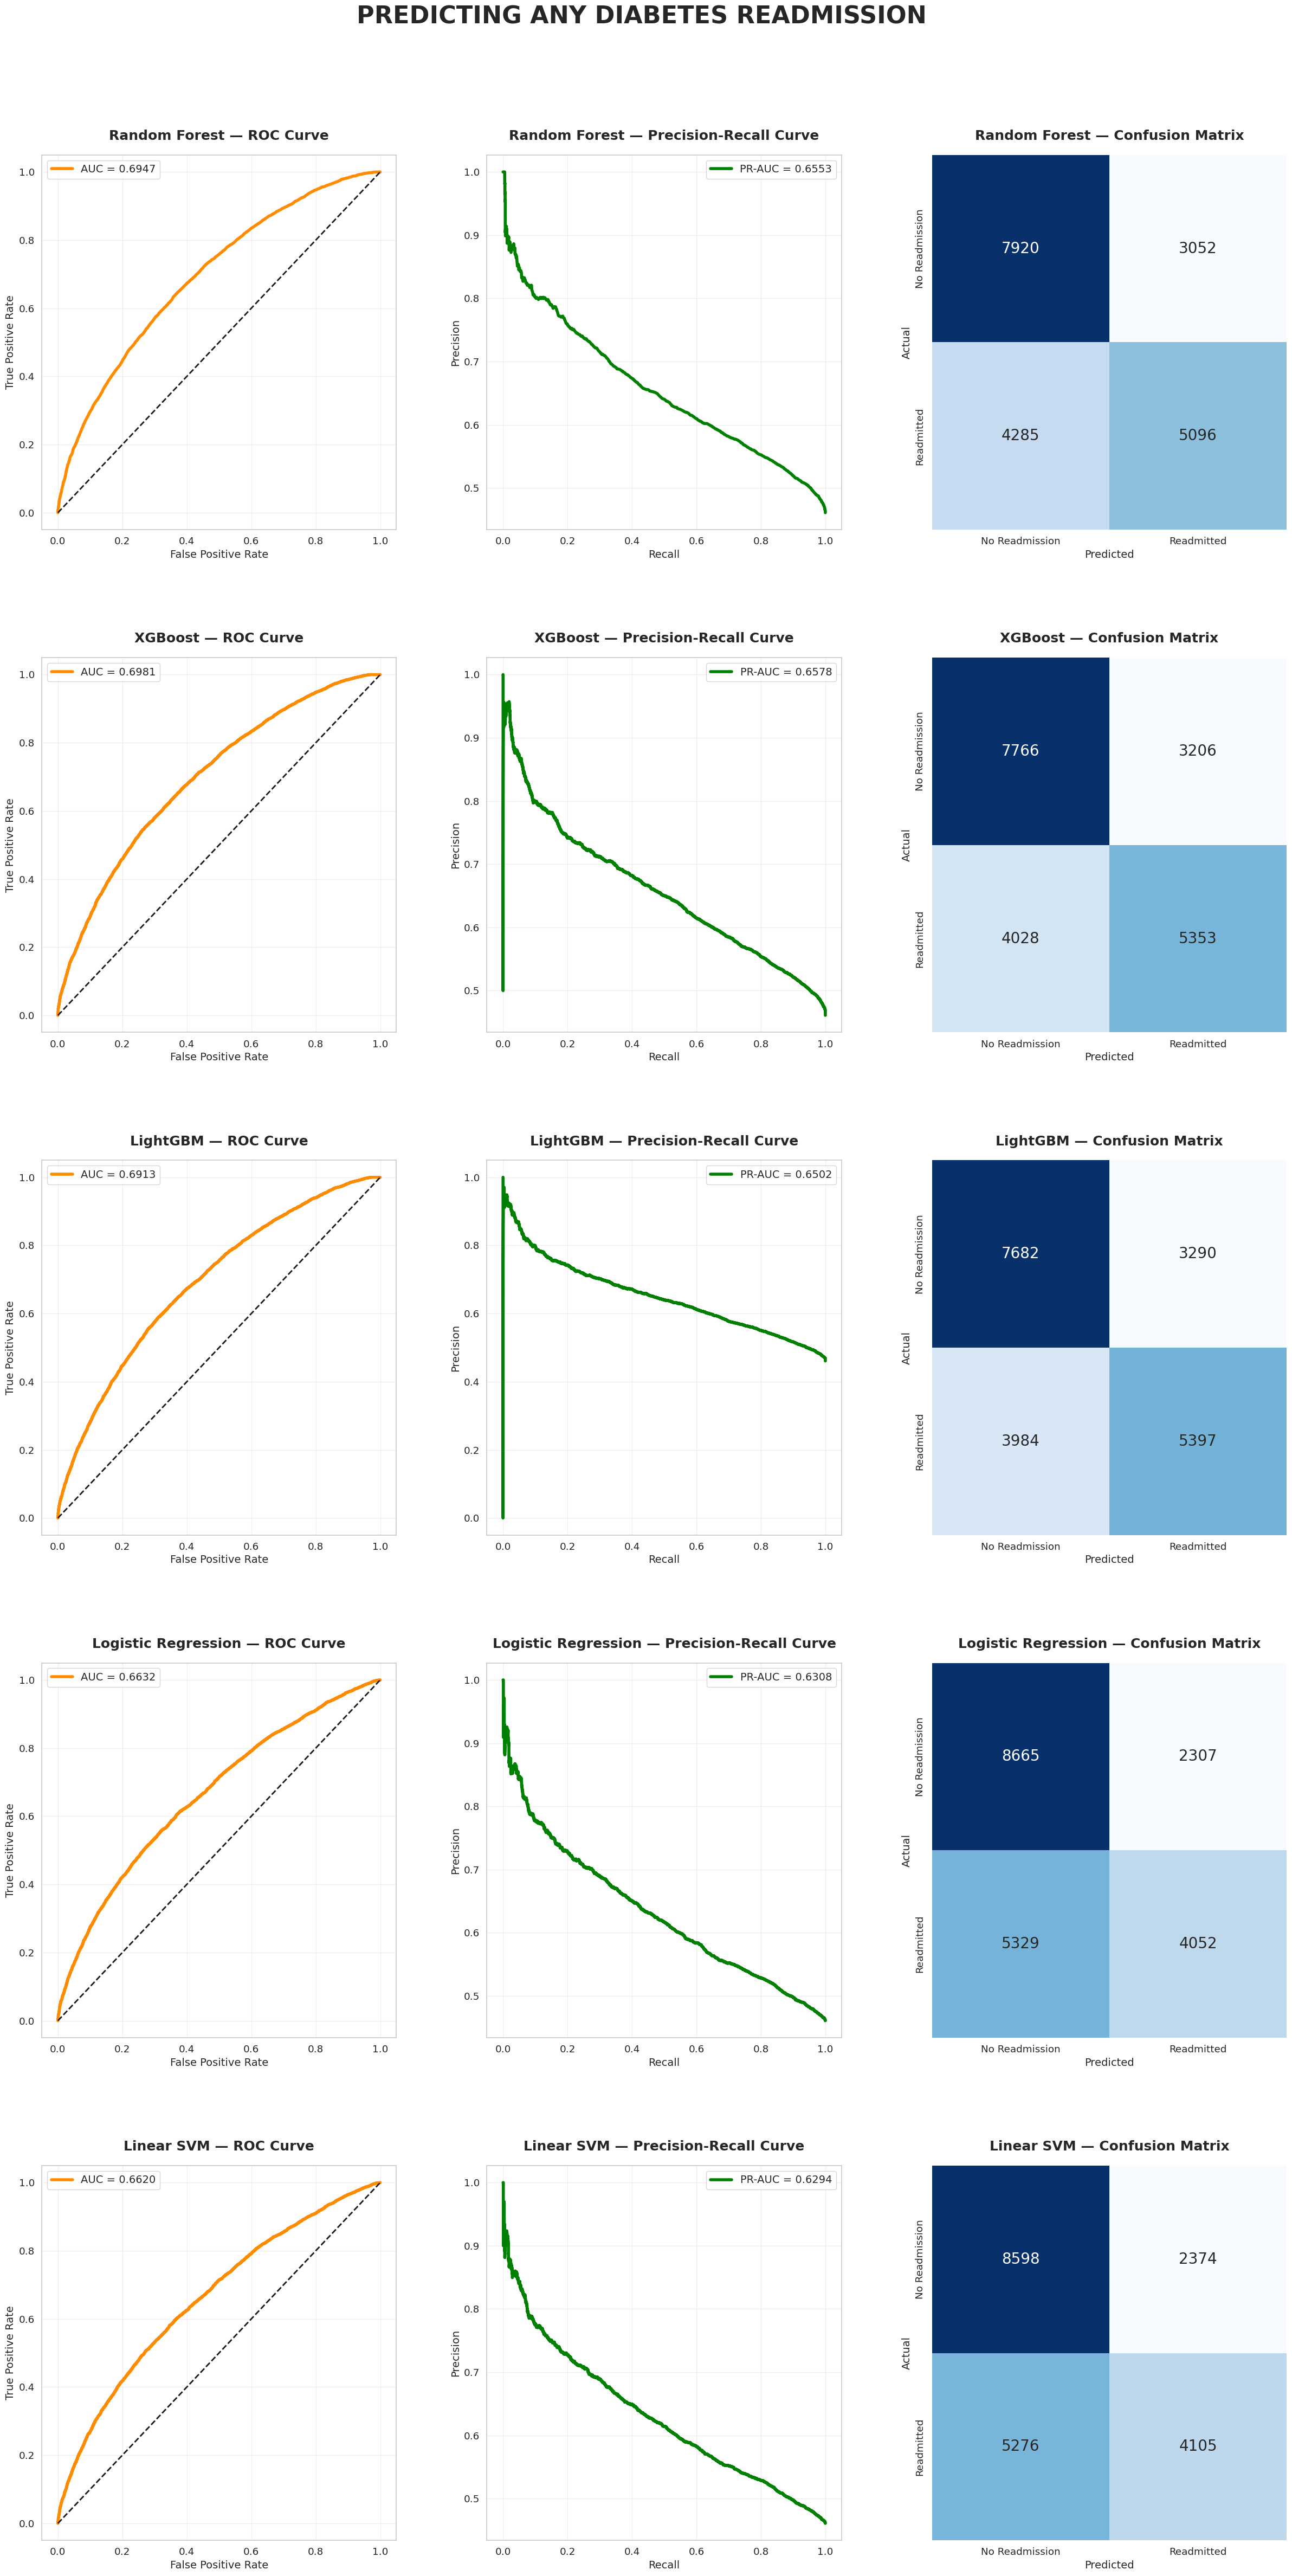


                                                       FINAL RANKING
                 Model     AUC  PR-AUC  Recall  Precision      F1    TP
1              XGBoost  0.6981  0.6578  0.5706     0.6254  0.5968  5353
2        Random Forest  0.6947  0.6553  0.5432     0.6254  0.5814  5096
3             LightGBM  0.6913  0.6502  0.5753     0.6213  0.5974  5397
4  Logistic Regression  0.6632  0.6308  0.4319     0.6372  0.5149  4052
5           Linear SVM  0.6620  0.6294  0.4376     0.6336  0.5177  4105

CHAMPION MODEL: XGBoost
         AUC            = 0.6981
         Recall         = 0.5706  →  catches 57.1% of ALL readmissions
         F1-Score       = 0.5968
         True Positives = 5,353


In [27]:

# This is the final code. it has all models included. Use it to write the analysis report


# =============================================================================
# DIABETES: PREDICT ANY READMISSION AT ALL (<30 or >30 vs NO)
# =============================================================================

import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import warnings; warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 12})

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, roc_curve, precision_recall_curve
)

# ------------------- RareCategoryGrouper -------------------
class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, min_freq=50):
        self.min_freq = min_freq
        self.frequent_maps_ = {}
        self.columns_ = []

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.columns_ = X.columns.tolist()
        for c in self.columns_:
            vc = X[c].astype(str).value_counts(dropna=False)
            self.frequent_maps_[c] = set(vc[vc >= self.min_freq].index)
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.columns_) if not isinstance(X, pd.DataFrame) else X.copy()
        for c in self.columns_:
            keep = self.frequent_maps_[c]
            X[c] = X[c].astype(str).where(X[c].astype(str).isin(keep), "RARE")
        return X

# ------------------- Load & Preprocess -------------------
df = pd.read_csv("diabetic_data.csv", na_values="?", low_memory=False)
df = df[df.gender != "Unknown/Invalid"].copy()
df.drop(columns=["encounter_id", "patient_nbr", "weight", "payer_code", "examide", "citoglipton"],
        errors="ignore", inplace=True)

# TARGET: ANY READMISSION
df["readmitted_any"] = (df["readmitted"] != "NO").astype(int)
print(f"Dataset: {df.shape} | Any readmission rate: {df['readmitted_any'].mean():.1%}")

# Feature Engineering
def age_mid(x):
    m = re.match(r"\[(\d+)-(\d+)\)", str(x))
    return (int(m.group(1)) + int(m.group(2))) / 2 if m else np.nan
df["age_num"] = df["age"].apply(age_mid)

def bucket_icd9(code):
    if pd.isna(code): return "missing"
    s = str(code).strip()
    if s.startswith(("V","E")): return s[0].lower()
    try: v = float(s)
    except: return "other"
    if 390 <= v <= 459 or v == 785: return "circulatory"
    if 460 <= v <= 519 or v == 786: return "respiratory"
    if 520 <= v <= 579 or v == 787: return "digestive"
    if 250 <= v < 251: return "diabetes"
    if 800 <= v <= 999: return "injury"
    if 140 <= v <= 239: return "neoplasms"
    return "other"

for c in ["diag_1", "diag_2", "diag_3"]:
    df[f"{c}_bucket"] = df[c].apply(bucket_icd9)

df["max_glu_serum"] = df["max_glu_serum"].map({"None":0, "Norm":1, ">200":2, ">300":3}).fillna(0)
df["A1Cresult"] = df["A1Cresult"].map({"None":0, "Norm":1, ">7":2, ">8":3}).fillna(0)
df["race"] = df["race"].fillna("Other")
df["total_visits"] = df["number_outpatient"] + df["number_emergency"] + df["number_inpatient"]
df["meds_per_day"] = df["num_medications"] / (df["time_in_hospital"] + 1)

X = df.drop(columns=["readmitted", "readmitted_any", "age", "diag_1", "diag_2", "diag_3"])
y = df["readmitted_any"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ------------------- Preprocessing -------------------
num_cols = X.select_dtypes("number").columns.tolist()
cat_cols = X.select_dtypes("object").columns.tolist()

num_pipe = Pipeline([("imp", SimpleImputer(strategy="median"))])
cat_pipe = Pipeline([
    ("rare", RareCategoryGrouper(min_freq=50)),
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
], verbose_feature_names_out=False)

# ------------------- Models  -------------------
models = {
    "Random Forest": RandomForestClassifier(n_estimators=1000, max_features=0.4, n_jobs=-1, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=1000, max_depth=8, learning_rate=0.05, subsample=0.9,
                             colsample_bytree=0.9, random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(n_estimators=1000, max_depth=12, learning_rate=0.05, num_leaves=200,
                               subsample=0.9, colsample_bytree=0.9, random_state=42, verbose=-1),
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "Linear SVM": CalibratedClassifierCV(
        LinearSVC(class_weight="balanced", max_iter=20000), cv=3, method="sigmoid"
    )
}

# ------------------- Train & Large Beautiful Plots -------------------
results = []
n_models = len(models)
fig = plt.figure(figsize=(24, 10 * n_models))  # Very tall for spacing

plot_idx = 1
row = 0

for name, model in models.items():
    print(f"\n{'='*100}")
    print(f" TRAINING: {name.upper()}")
    print('='*100)

    pipe = Pipeline([("prep", preprocess), ("clf", model)])
    pipe.fit(X_train, y_train)

    pred = pipe.predict(X_test)
    prob = pipe.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, prob)
    pr_auc = average_precision_score(y_test, prob)
    report = classification_report(y_test, pred, output_dict=True)
    cm = confusion_matrix(y_test, pred)

    results.append({
        "Model": name,
        "AUC": round(auc, 4),
        "PR-AUC": round(pr_auc, 4),
        "Recall": round(report["1"]["recall"], 4),
        "Precision": round(report["1"]["precision"], 4),
        "F1": round(report["1"]["f1-score"], 4),
        "TP": int(cm[1,1])
    })

    print(f"\nCLASSIFICATION REPORT — {name}")
    print(classification_report(y_test, pred, digits=4))
    print("Confusion Matrix:\n", cm)

    # Large, spaced plots
    # ROC Curve
    ax1 = fig.add_subplot(n_models, 3, plot_idx)
    fpr, tpr, _ = roc_curve(y_test, prob)
    ax1.plot(fpr, tpr, label=f'AUC = {auc:.4f}', lw=4, color="darkorange")
    ax1.plot([0,1],[0,1],'k--', lw=2)
    ax1.set_title(f"{name} — ROC Curve", fontsize=18, pad=20, fontweight="bold")
    ax1.set_xlabel("False Positive Rate", fontsize=14)
    ax1.set_ylabel("True Positive Rate", fontsize=14)
    ax1.legend(fontsize=14)
    ax1.grid(True, alpha=0.3)
    plot_idx += 1

    # PR Curve
    ax2 = fig.add_subplot(n_models, 3, plot_idx)
    prec, rec, _ = precision_recall_curve(y_test, prob)
    ax2.plot(rec, prec, label=f'PR-AUC = {pr_auc:.4f}', lw=4, color="green")
    ax2.set_title(f"{name} — Precision-Recall Curve", fontsize=18, pad=20, fontweight="bold")
    ax2.set_xlabel("Recall", fontsize=14)
    ax2.set_ylabel("Precision", fontsize=14)
    ax2.legend(fontsize=14)
    ax2.grid(True, alpha=0.3)
    plot_idx += 1

    # Confusion Matrix
    ax3 = fig.add_subplot(n_models, 3, plot_idx)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 20},
                xticklabels=["No Readmission", "Readmitted"],
                yticklabels=["No Readmission", "Readmitted"])
    ax3.set_title(f"{name} — Confusion Matrix", fontsize=18, pad=20, fontweight="bold")
    ax3.set_xlabel("Predicted", fontsize=14)
    ax3.set_ylabel("Actual", fontsize=14)
    plot_idx += 1

plt.suptitle("PREDICTING ANY DIABETES READMISSION ", fontsize=32, fontweight="bold", y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=8.0, w_pad=6.0)
plt.show()

# ------------------- Final Ranking Table -------------------
results_df = pd.DataFrame(results).sort_values("AUC", ascending=False).reset_index(drop=True)
results_df.index += 1

print("\n" + "="*140)
print(" " * 55 + "FINAL RANKING")
print("="*140)
print(results_df.to_string(index=True))
print("="*140)

winner = results_df.iloc[0]
print(f"\nCHAMPION MODEL: {winner['Model']}")
print(f"         AUC            = {winner['AUC']:.4f}")
print(f"         Recall         = {winner['Recall']:.4f}  →  catches {winner['Recall']*100:.1f}% of ALL readmissions")
print(f"         F1-Score       = {winner['F1']:.4f}")
print(f"         True Positives = {winner['TP']:,}")


In [30]:
import joblib, os
from xgboost import XGBClassifier

final_model = Pipeline([
    ("prep", preprocess),
    ("clf", XGBClassifier(n_estimators=1000, max_depth=8, learning_rate=0.05,
                          subsample=0.9, colsample_bytree=0.9,
                          random_state=42, n_jobs=-1))
])

print("Training champion model (this takes ~20–30 seconds)...")
final_model.fit(X_train, y_train)
print("Model trained! Saving...")

# Save both the model and the column order
joblib.dump(final_model, "anyreadmit_champion_model.pkl")
joblib.dump(X.columns.tolist(), "anyreadmit_feature_columns.pkl")
print("Model saved as 'anyreadmit_champion_model.pkl'")

Training champion model (this takes ~20–30 seconds)...
Model trained! Saving...
Model saved as 'anyreadmit_champion_model.pkl'


In [33]:
import joblib
import pandas as pd
import numpy as np
import re
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets

# Load model
model = joblib.load("anyreadmit_champion_model.pkl")
cols = joblib.load("anyreadmit_feature_columns.pkl")
print("Model loaded — live predictions ready!")

# Mapping for A1C and glu serum
a1c_map = {"None": 0, "Norm": 1, ">7": 2, ">8": 3}
glu_map = {"None": 0, "Norm": 1, ">200": 2, ">300": 3}

# Blank patient with safe defaults
def blank_patient():
    data = {}
    meds = ["metformin","repaglinide","nateglinide","chlorpropamide","glimepiride","glipizide",
            "glyburide","pioglitazone","rosiglitazone","acarbose","miglitol","insulin"]
    for c in cols:
        if any(m in c for m in meds): data[c] = "No"
        elif c in ["change","diabetesMed"]: data[c] = "No"
        elif "bucket" in c: data[c] = "missing"
        elif c in ["A1Cresult","max_glu_serum"]: data[c] = "None"
        elif c in ["age","gender","race","medical_specialty"]: data[c] = "Other"
        else: data[c] = 0
    return pd.DataFrame([data])[cols]

# UI
display(Markdown("# Live Readmission Risk Calculator"))
display(Markdown("**Enter patient details → instant clinical decision support**"))

age = widgets.Dropdown(options=["[0-10)","[10-20)","[20-30)","[30-40)","[40-50)","[50-60)","[60-70)","[70-80)","[80-90)","[90-100)"], value="[70-80)", description="Age:")
gender = widgets.Dropdown(options=["Male","Female"], value="Female", description="Gender:")
race = widgets.Dropdown(options=["Caucasian","AfricanAmerican","Hispanic","Asian","Other"], value="Caucasian", description="Race:")
days = widgets.IntSlider(min=1, max=14, value=4, description="Days in Hosp:")
labs = widgets.IntSlider(min=0, max=130, value=40, description="Lab Tests:")
meds_count = widgets.IntSlider(min=1, max=81, value=16, description="Medications:")
outp = widgets.IntSlider(min=0, max=40, value=0, description="Outpatient:")
er = widgets.IntSlider(min=0, max=76, value=0, description="ER Visits:")
inp = widgets.IntSlider(min=0, max=21, value=1, description="Inpatient Visits:")
diag = widgets.Text(value="250.83", description="Primary ICD9:")
a1c = widgets.Dropdown(options=["None","Norm",">7",">8"], value="None", description="A1C Result:")

button = widgets.Button(description="Predict Risk Now", button_style="success", layout=widgets.Layout(width="100%", height="70px"))
out = widgets.Output()

def predict_now(b):
    with out:
        clear_output()
        patient = blank_patient().copy()

        # Fill user data
        patient.loc[0, "age"] = age.value
        patient.loc[0, "gender"] = gender.value
        patient.loc[0, "race"] = race.value
        patient.loc[0, "time_in_hospital"] = days.value
        patient.loc[0, "num_lab_procedures"] = labs.value
        patient.loc[0, "num_medications"] = meds_count.value
        patient.loc[0, "number_outpatient"] = outp.value
        patient.loc[0, "number_emergency"] = er.value
        patient.loc[0, "number_inpatient"] = inp.value
        patient.loc[0, "diag_1"] = diag.value
        patient.loc[0, "A1Cresult"] = a1c.value

        patient["A1Cresult"] = patient["A1Cresult"].map(a1c_map)
        patient["max_glu_serum"] = patient["max_glu_serum"].map(glu_map)

        # Engineered features
        patient.loc[0, "total_visits"] = outp.value + er.value + inp.value
        patient.loc[0, "meds_per_day"] = meds_count.value / (days.value + 1)
        m = re.match(r"\[(\d+)-(\d+)\)", age.value)
        patient.loc[0, "age_num"] = (int(m.group(1)) + int(m.group(2))) / 2 if m else 50

        def icd_bucket(code):
            try: v = float(code);
            except: return "other"
            if 390<=v<=459 or v==785: return "circulatory"
            if 460<=v<=519 or v==786: return "respiratory"
            if 520<=v<=579 or v==787: return "digestive"
            if 250<=v<251: return "diabetes"
            if 800<=v<=999: return "injury"
            if 140<=v<=239: return "neoplasms"
            return "other"
        patient.loc[0, "diag_1_bucket"] = icd_bucket(diag.value)

        # Predict
        risk = model.predict_proba(patient)[0,1] * 100
        display(Markdown(f"## Readmission Risk: **{risk:.1f}%**"))
        if risk > 70:
            display(Markdown("<h2 style='color:red'>HIGH RISK – Urgent intervention required</h2>"))
        elif risk > 55:
            display(Markdown("<h2 style='color:orange'>MODERATE RISK – Schedule follow-up</h2>"))
        else:
            display(Markdown("<h2 style='color:green'>LOW RISK – Standard discharge plan</h2>"))

button.on_click(predict_now)
display(widgets.VBox([age,gender,race,days,labs,meds_count,outp,er,inp,diag,a1c,button,out]))

Model loaded — live predictions ready!


# Live Readmission Risk Calculator

**Enter patient details → instant clinical decision support**

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('diabetic_data.csv', na_values='?')

/tmp/ipython-input-3947556249.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('diabetic_data.csv', na_values='?')


# Preprocessing

In [ ]:
data.shape

(101766, 50)

In [ ]:
data.isnull().sum()

,0
encounter_id,0
patient_nbr,0
race,2273
gender,0
age,0
weight,98569
admission_type_id,0
discharge_disposition_id,0
admission_source_id,0
time_in_hospital,0


In [ ]:

data.drop(columns=['weight' , 'max_glu_serum', 'A1Cresult','payer_code','encounter_id',	'patient_nbr'], inplace=True)

In [ ]:
data.shape

(101766, 44)

In [ ]:
data.isnull().sum()

,0
race,2273
gender,0
age,0
admission_type_id,0
discharge_disposition_id,0
admission_source_id,0
time_in_hospital,0
medical_specialty,49949
num_lab_procedures,0
num_procedures,0


In [ ]:
data['race'] = data['race'].fillna('other')
data['medical_specialty'] = data['medical_specialty'].fillna('other')


In [ ]:
data.shape

(101766, 44)

In [ ]:
data.isnull().sum()

,0
race,0
gender,0
age,0
admission_type_id,0
discharge_disposition_id,0
admission_source_id,0
time_in_hospital,0
medical_specialty,0
num_lab_procedures,0
num_procedures,0


In [ ]:
data_clean = data.dropna()

In [ ]:
data_clean.shape

(100244, 44)

In [ ]:
data_clean.isnull().sum()

,0
race,0
gender,0
age,0
admission_type_id,0
discharge_disposition_id,0
admission_source_id,0
time_in_hospital,0
medical_specialty,0
num_lab_procedures,0
num_procedures,0


In [ ]:
data.dtypes

,0
race,object
gender,object
age,object
admission_type_id,int64
discharge_disposition_id,int64
admission_source_id,int64
time_in_hospital,int64
medical_specialty,object
num_lab_procedures,int64
num_procedures,int64


# Encoding

In [ ]:
#Encoding
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
data_clean['admission_type_id'] = le.fit_transform(data_clean['admission_type_id'])
data_clean['discharge_disposition_id'] = le.fit_transform(data_clean['discharge_disposition_id'])
data_clean['admission_source_id'] = le.fit_transform(data_clean['admission_source_id'])
data_clean['race'] = le.fit_transform(data_clean['race'])
data_clean['gender'] = le.fit_transform(data_clean['gender'])
data_clean['age'] = le.fit_transform(data_clean['age'])
data_clean['diag_1'] = le.fit_transform(data_clean['diag_1'])
data_clean['diag_2'] = le.fit_transform(data_clean['diag_2'])
data_clean['diag_3'] = le.fit_transform(data_clean['diag_3'])
data_clean['metformin'] = le.fit_transform(data_clean['metformin'])
data_clean['citoglipton'] = le.fit_transform(data_clean['metformin'])
data_clean['repaglinide'] = le.fit_transform(data_clean['repaglinide'])
data_clean['nateglinide'] = le.fit_transform(data_clean['nateglinide'])
data_clean['chlorpropamide'] = le.fit_transform(data_clean['chlorpropamide'])
data_clean['glimepiride'] = le.fit_transform(data_clean['glimepiride'])
data_clean['acetohexamide'] = le.fit_transform(data_clean['acetohexamide'])
data_clean['glipizide'] = le.fit_transform(data_clean['glipizide'])
data_clean['glyburide'] = le.fit_transform(data_clean['glyburide'])
data_clean['tolbutamide'] = le.fit_transform(data_clean['tolbutamide'])
data_clean['pioglitazone'] = le.fit_transform(data_clean['pioglitazone'])
data_clean['rosiglitazone'] = le.fit_transform(data_clean['rosiglitazone'])
data_clean['acarbose'] = le.fit_transform(data_clean['acarbose'])
data_clean['miglitol'] = le.fit_transform(data_clean['miglitol'])
data_clean['troglitazone'] = le.fit_transform(data_clean['troglitazone'])
data_clean['tolazamide'] = le.fit_transform(data_clean['tolazamide'])
data_clean['insulin'] = le.fit_transform(data_clean['insulin'])
data_clean['glyburide-metformin'] = le.fit_transform(data_clean['glyburide-metformin'])
data_clean['glipizide-metformin'] = le.fit_transform(data_clean['glipizide-metformin'])
data_clean['glimepiride-pioglitazone'] = le.fit_transform(data_clean['glimepiride-pioglitazone'])
data_clean['metformin-rosiglitazone'] = le.fit_transform(data_clean['metformin-rosiglitazone'])
data_clean['metformin-pioglitazone'] = le.fit_transform(data_clean['metformin-pioglitazone'])
data_clean['change'] = le.fit_transform(data_clean['change'])
data_clean['diabetesMed'] = le.fit_transform(data_clean['diabetesMed'])
data_clean['readmitted'] = le.fit_transform(data_clean['readmitted'])
data_clean['medical_specialty'] = le.fit_transform(data_clean['medical_specialty'])
data_clean['examide'] = le.fit_transform(data_clean['examide'])



#Transforming in a binary problem
# data_clean['readmitted'] = data_clean['readmitted'].apply(lambda x: 1 if x == '<30' else (2 if x == '>30' else 0))
data_clean.head(15)

/tmp/ipython-input-752092114.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['admission_type_id'] = le.fit_transform(data_clean['admission_type_id'])
/tmp/ipython-input-752092114.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['discharge_disposition_id'] = le.fit_transform(data_clean['discharge_disposition_id'])
/tmp/ipython-input-752092114.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,2,0,1,0,0,6,3,72,59,0,...,1,3,1,0,0,0,0,0,1,1
2,0,0,2,0,0,6,2,72,11,5,...,1,1,1,0,0,0,0,1,1,2
3,2,1,3,0,0,6,2,72,44,1,...,1,3,1,0,0,0,0,0,1,2
4,2,1,4,0,0,6,1,72,51,0,...,1,2,1,0,0,0,0,0,1,2
5,2,1,5,1,0,1,3,72,31,6,...,1,2,1,0,0,0,0,1,1,1
6,2,1,6,2,0,1,4,72,70,1,...,2,2,1,0,0,0,0,0,1,2
7,2,1,7,0,0,6,5,72,73,0,...,1,1,1,0,0,0,0,1,1,1
8,2,0,8,1,0,3,13,72,68,2,...,1,2,1,0,0,0,0,0,1,2
9,2,0,9,2,2,3,12,18,33,3,...,1,2,1,0,0,0,0,0,1,2
10,0,0,4,0,0,6,9,72,47,2,...,1,2,1,0,0,0,0,1,1,1


In [ ]:
data_clean['readmitted'].value_counts()

,count
readmitted,
2,53821
1,35173
0,11250


# Random Forest, Group Preprocessing

In [ ]:
# Not the final code. ignore it

import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt, joblib
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Optional (installed in most environments)
try:
    from xgboost import XGBClassifier
    XGB_OK = True
except Exception:
    XGB_OK = False

# ----------------- Config -----------------
SEED = 42
np.random.seed(SEED)
DATA_PATH = "diabetic_data.csv"    # change if needed
ARTIFACT_DIR = "artifacts"; os.makedirs(ARTIFACT_DIR, exist_ok=True)

# EXACT drops from your notebook
DROP_COLS = ['weight','max_glu_serum','A1Cresult','payer_code','encounter_id','patient_nbr']


# low_memory=False to avoid DtypeWarning & slow dtype guessing
df = pd.read_csv(DATA_PATH, na_values='?', low_memory=False)
assert 'readmitted' in df.columns, "readmitted target not found"

# drop columns exactly as you did
for c in DROP_COLS:
    if c in df.columns: df.drop(columns=c, inplace=True)

# fill 'race' and 'medical_specialty' with 'other' exactly like your notebook
for c in ['race','medical_specialty']:
    if c in df.columns:
        df[c] = df[c].fillna('other')

# target: any readmission (<30 or >30) vs NO  (same meaning as typical notebook)
y = (df['readmitted'].astype(str).str.upper() != 'NO').astype(int)
X = df.drop(columns=['readmitted']).copy()

# 1) age_num midpoint (keeps original 'age' categorical; models can use both)
def age_mid(a):
    m = re.match(r"\[(\d+)-(\d+)\)", str(a))
    return np.nan if not m else (int(m.group(1))+int(m.group(2)))/2
if 'age' in X.columns:
    X['age_num'] = X['age'].apply(age_mid)

# ----------------- Column sets -----------------
num_cols = [c for c in [
    'time_in_hospital','num_lab_procedures','num_procedures','num_medications',
    'number_outpatient','number_emergency','number_inpatient','number_diagnoses','age_num'
] if c in X.columns]

cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# ----------------- Split -----------------
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
pos_weight = (y_tr.shape[0] - y_tr.sum()) / max(1, y_tr.sum())

# - Numerics: median impute + scale (scale helps LR/SVM; trees ignore scale)
# - Categoricals: impute then OrdinalEncoder (LabelEncoder-like across columns)
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler()),
])

# For 'race' and 'medical_specialty', preserve your fill='other'
special_cat = [c for c in ['race','medical_specialty'] if c in cat_cols]
rest_cat = [c for c in cat_cols if c not in special_cat]

ordinal_enc = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    dtype=np.int64
)

cat_special_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="constant", fill_value="other")),
    ("enc", ordinal_enc),
])

cat_rest_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("enc", ordinal_enc),
])

transformers = []
if num_cols: transformers.append(("num", num_pipe, num_cols))
if special_cat: transformers.append(("cat_special", cat_special_pipe, special_cat))
if rest_cat: transformers.append(("cat_rest", cat_rest_pipe, rest_cat))

preproc = ColumnTransformer(transformers=transformers, remainder="drop")

# ----------------- Models (no CV; sensible defaults) -----------------
models = {
    "logreg": Pipeline([
        ("prep", preproc),
        ("clf", LogisticRegression(
            max_iter=5000, solver="lbfgs", class_weight="balanced", C=1.0))
    ]),
    "rf": Pipeline([
        ("prep", preproc),
        ("clf", RandomForestClassifier(
            n_estimators=400, max_depth=None, min_samples_leaf=1,
            class_weight="balanced_subsample", random_state=SEED, n_jobs=-1))
    ]),
    "svm_rbf": Pipeline([
        ("prep", preproc),
        ("clf", SVC(
            kernel="rbf", probability=True, class_weight="balanced",
            C=1.0, gamma="scale", random_state=SEED))
    ]),
}

if XGB_OK:
    models["xgb"] = Pipeline([
        ("prep", preproc),
        ("clf", XGBClassifier(
            n_estimators=400, max_depth=4, learning_rate=0.05,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
            objective="binary:logistic", eval_metric="auc", random_state=SEED,
            tree_method="hist", scale_pos_weight=float(pos_weight)))
    ])

# Optional: to keep SVM snappy on big data, subsample its training split only
SVM_MAX = 30000
if "svm_rbf" in models and len(X_tr) > SVM_MAX:
    svm_idx = X_tr.sample(SVM_MAX, random_state=SEED).index
    X_tr_svm, y_tr_svm = X_tr.loc[svm_idx], y_tr.loc[svm_idx]
else:
    X_tr_svm, y_tr_svm = X_tr, y_tr

# ----------------- Train, Evaluate, Compare -----------------
def eval_from_proba(ytrue, proba, thr=0.5):
    pred = (proba >= thr).astype(int)
    return dict(
        accuracy=accuracy_score(ytrue, pred),
        f1=f1_score(ytrue, pred),
        roc_auc=roc_auc_score(ytrue, proba),
        pr_auc=average_precision_score(ytrue, proba),
    )

results = {}

for name, pipe in models.items():
    print(f"\nTraining {name} ...")
    if name == "svm_rbf":
        pipe.fit(X_tr_svm, y_tr_svm)
    else:
        pipe.fit(X_tr, y_tr)

    proba = pipe.predict_proba(X_te)[:, 1]
    results[name] = eval_from_proba(y_te, proba)
    joblib.dump(pipe, os.path.join(ARTIFACT_DIR, f"{name}_pipeline.joblib"))

metrics = pd.DataFrame(results).T.sort_values("roc_auc", ascending=False)
print("\n=== Test metrics (no-CV) ===")
print(metrics)
metrics.to_csv(os.path.join(ARTIFACT_DIR, "metrics_simple.csv"))

# ----------------- Plots -----------------
plt.figure()
for name, pipe in models.items():
    RocCurveDisplay.from_estimator(pipe, X_te, y_te, name=name)
plt.title("ROC — Test"); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "roc_simple.png"), dpi=150); plt.show()

plt.figure()
for name, pipe in models.items():
    PrecisionRecallDisplay.from_estimator(pipe, X_te, y_te, name=name)
plt.title("PR — Test"); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "pr_simple.png"), dpi=150); plt.show()

ax = metrics[["roc_auc","pr_auc","accuracy","f1"]].plot(kind="bar")
ax.set_title("Model Comparison — Test (no-CV)")
ax.set_ylabel("Score")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "model_comparison_simple.png"), dpi=150); plt.show()


Numeric cols: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'age_num']
Categorical cols: ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']

Training logreg ...


KeyboardInterrupt: 

# Random Forest
## 3 different preprocessing

Numeric cols: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
Categorical cols: ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']

Training RandomForest ...

=== Test metrics (RandomForest) ===
accuracy: 0.6419
      f1: 0.5743
 roc_auc: 0.6962
  pr_auc: 0.6579

Confusion Matrix (rows=true, cols=pred):
[[8148 2825]
 [4464 4917]]

Classification Report:
              precision

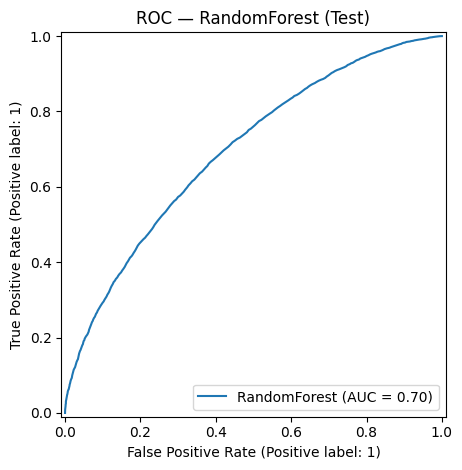

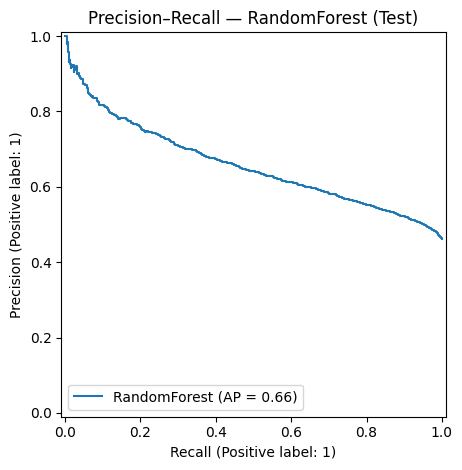


Top 20 features by RF importance:
                     feature  importance
1         num_lab_procedures    0.094181
15                    diag_1    0.089538
16                    diag_2    0.088655
17                    diag_3    0.085809
3            num_medications    0.081372
0           time_in_hospital    0.057877
6           number_inpatient    0.049846
10                       age    0.049559
12  discharge_disposition_id    0.044154
14         medical_specialty    0.041423
7           number_diagnoses    0.040931
2             num_procedures    0.037714
35                   insulin    0.026211
11         admission_type_id    0.025756
8                       race    0.022934
13       admission_source_id    0.021983
9                     gender    0.018326
4          number_outpatient    0.018307
5           number_emergency    0.015118
18                 metformin    0.014310


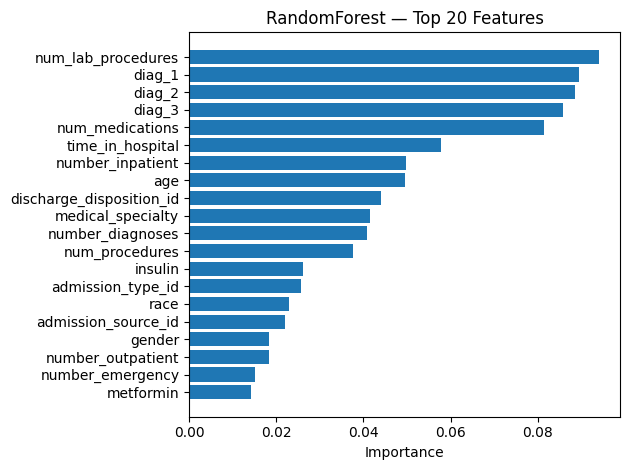


Artifacts saved to: /content/artifacts


In [ ]:
# Not the final code. ignore it
# Preprocessing: read_csv(na_values='?') → drop your cols → fill race/medical_specialty='other'
# → Ordinal-encode ALL categoricals. Train RandomForest. Evaluate + visualize.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay, classification_report, confusion_matrix
)

# ---------------- Config ----------------
SEED = 42
np.random.seed(SEED)
DATA_PATH = "diabetic_data.csv"   # change if needed
ARTIFACT_DIR = "artifacts"; os.makedirs(ARTIFACT_DIR, exist_ok=True)

# Your exact drops
DROP_COLS = ['weight','max_glu_serum','A1Cresult','payer_code','encounter_id','patient_nbr']


# low_memory=False avoids DtypeWarning & speeds parsing on mixed-type cols
df = pd.read_csv(DATA_PATH, na_values='?', low_memory=False)
assert 'readmitted' in df.columns, "Target 'readmitted' not found."

# Drop exactly the columns from  notebook
for c in DROP_COLS:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

# Fill 'race' and 'medical_specialty' with 'other' (as in your notebook)
for c in ['race', 'medical_specialty']:
    if c in df.columns:
        df[c] = df[c].fillna('other')

# Binary target: any readmission (<30 or >30) vs NO (same semantics as before)
y = (df['readmitted'].astype(str).str.upper() != 'NO').astype(int)
X = df.drop(columns=['readmitted']).copy()

# Numeric columns commonly present (without age_num)
num_cols = [c for c in [
    'time_in_hospital','num_lab_procedures','num_procedures','num_medications',
    'number_outpatient','number_emergency','number_inpatient','number_diagnoses'
] if c in X.columns]

# Everything else treated as categorical (ordinal-encoded)
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# ---------------- Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# - Numerics: median impute (no scaling; trees don’t need it)
# - Categoricals: impute most frequent, then OrdinalEncoder (LabelEncoder-like, multi-column)
ordinal_enc = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    dtype=np.int64
)

num_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
])

cat_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("enc", ordinal_enc),
])

preproc = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop"
)

# ---------------- Model: RandomForest ----------------
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=1,
    random_state=SEED,
    n_jobs=-1,
    class_weight="balanced_subsample"  # handles imbalance a bit
)

pipe = Pipeline(steps=[
    ("prep", preproc),
    ("clf", rf),
])

# ---------------- Train ----------------
print("\nTraining RandomForest ...")
pipe.fit(X_train, y_train)

# ---------------- Evaluate ----------------
proba = pipe.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

metrics = {
    "accuracy": accuracy_score(y_test, pred),
    "f1": f1_score(y_test, pred),
    "roc_auc": roc_auc_score(y_test, proba),
    "pr_auc": average_precision_score(y_test, proba),
}
print("\n=== Test metrics (RandomForest) ===")
for k, v in metrics.items():
    print(f"{k:>8}: {v:.4f}")

print("\nConfusion Matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, pred))
print("\nClassification Report:")
print(classification_report(y_test, pred, digits=4))

# ---------------- Visuals ----------------
# 1) ROC Curve
RocCurveDisplay.from_estimator(pipe, X_test, y_test, name="RandomForest")
plt.title("ROC — RandomForest (Test)")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "rf_roc.png"), dpi=160)
plt.show()

# 2) Precision–Recall Curve
PrecisionRecallDisplay.from_estimator(pipe, X_test, y_test, name="RandomForest")
plt.title("Precision–Recall — RandomForest (Test)")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "rf_pr.png"), dpi=160)
plt.show()

# 3) Top feature importances (from trained RF)
#    Recover transformed feature names: numeric first, then categorical encoded as ordinal (one column each)
def get_feature_names(prep: ColumnTransformer):
    names = []
    # numeric names as-is
    if num_cols:
        names.extend(num_cols)
    # categorical names: original column names (each is a single ordinal-encoded column)
    if cat_cols:
        names.extend(cat_cols)
    return names

feat_names = get_feature_names(pipe.named_steps["prep"])
importances = pipe.named_steps["clf"].feature_importances_
feat_imp = (pd.DataFrame({"feature": feat_names, "importance": importances})
            .sort_values("importance", ascending=False)
            .head(20))

print("\nTop 20 features by RF importance:")
print(feat_imp)

# Plot top-20 feature importances
plt.figure()
plt.barh(feat_imp["feature"][::-1], feat_imp["importance"][::-1])
plt.xlabel("Importance")
plt.title("RandomForest — Top 20 Features")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "rf_feature_importance_top20.png"), dpi=160)
plt.show()

# ---------------- Save artifacts ----------------
joblib.dump(pipe, os.path.join(ARTIFACT_DIR, "rf_pipeline.joblib"))
pd.DataFrame([metrics]).to_csv(os.path.join(ARTIFACT_DIR, "rf_metrics.csv"), index=False)
feat_imp.to_csv(os.path.join(ARTIFACT_DIR, "rf_feature_importance_top20.csv"), index=False)

print(f"\nArtifacts saved to: {os.path.abspath(ARTIFACT_DIR)}")


Numeric: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'age_num', 'A1Cresult', 'max_glu_serum', 'util_visits', 'meds_per_day']
Categorical: ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'diag_1_bucket', 'diag_2_bucket', 'diag_3_bucket']

Searching RandomForest …
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 3015
max_resources_: 81412
aggressive_elimination: Fa

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 5, 'clf__n_estimators': 800} | Best CV AUC: 0.7035

=== Test metrics (RandomForest, tuned) ===
accuracy: 0.6459
      f1: 0.6133
 roc_auc: 0.7059
  pr_auc: 0.6666

Confusion Matrix (rows=true, cols=pred):
[[7432 3541]
 [3666 5715]]

Classification Report:
              precision    recall  f1-score   support

           0     0.6697    0.6773    0.6735     10973
           1     0.6174    0.6092    0.6133      9381

    accuracy                         0.6459     20354
   macro avg     0.6436    0.6433    0.6434     20354
weighted avg     0.6456    0.6459    0.6457     20354



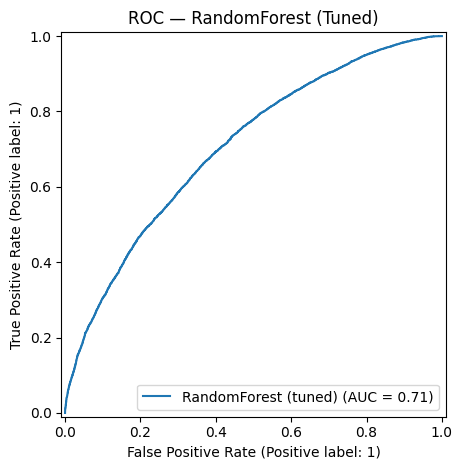

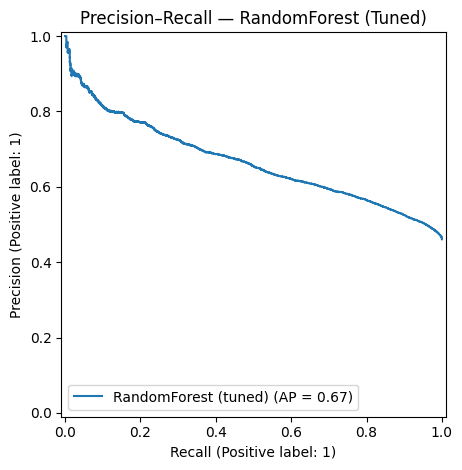


Top 20 features by RF importance:
                         feature  importance
11                   util_visits    0.081205
6               number_inpatient    0.079504
1             num_lab_procedures    0.041593
3                num_medications    0.041012
12                  meds_per_day    0.040681
40   discharge_disposition_id_11    0.034126
7               number_diagnoses    0.032782
0               time_in_hospital    0.026923
5               number_emergency    0.022562
8                        age_num    0.021088
4              number_outpatient    0.020250
2                 num_procedures    0.019725
64         admission_source_id_7    0.010592
39    discharge_disposition_id_1    0.008644
99       medical_specialty_other    0.008460
172                   diag_1_428    0.008167
19                 gender_Female    0.007575
52    discharge_disposition_id_6    0.007520
20                   gender_Male    0.007433
15                race_Caucasian    0.006728


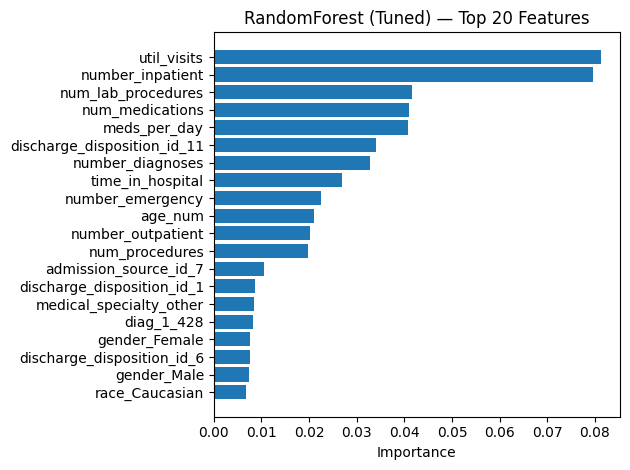


Artifacts saved to: /content/artifacts


In [ ]:
# Not the final code.
# My preprocessing + tuned RandomForest for the UCI/Kaggle diabetes readmission dataset

import os, re, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from typing import Dict

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay, classification_report, confusion_matrix
)
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingGridSearchCV

# ---------------- Config ----------------
SEED = 42
np.random.seed(SEED)
DATA_PATH = "diabetic_data.csv"  # change if needed
ARTIFACT_DIR = "artifacts"; os.makedirs(ARTIFACT_DIR, exist_ok=True)
CACHE_DIR = "skcache"; os.makedirs(CACHE_DIR, exist_ok=True)

# Columns that are IDs/near-constant or not useful as-is
DROP_COLS = ["encounter_id", "patient_nbr", "weight", "payer_code", "examide", "citoglipton"]

# We KEEP max_glu_serum & A1Cresult and treat them as ordinal categories.

# ---------------- Helpers ----------------
def age_mid(a):
    """Convert age bracket like '[70-80)' -> 75.0"""
    if pd.isna(a): return np.nan
    m = re.match(r"\[(\d+)-(\d+)\)", str(a))
    return np.nan if not m else (int(m.group(1))+int(m.group(2)))/2

def bucket_icd9(code: str) -> str:
    """Broad ICD-9 buckets to reduce category explosion."""
    if pd.isna(code): return "icd_missing"
    s = str(code).strip()
    if s.startswith("V"): return "icd_V"
    if s.startswith("E"): return "icd_E"
    try: v = float(s)
    except ValueError: return "icd_other"
    if 390 <= v <= 459 or v == 785: return "circulatory"
    if 460 <= v <= 519 or v == 786: return "respiratory"
    if 520 <= v <= 579 or v == 787: return "digestive"
    if 250 <= v < 251:             return "diabetes_specific"
    if 800 <= v <= 999:            return "injury"
    if 710 <= v <= 739:            return "musculoskeletal"
    if 580 <= v <= 629 or v == 788:return "genitourinary"
    if 140 <= v <= 239:            return "neoplasms"
    return "other"

class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    """Group infrequent categories to 'RARE' (fit on train only). Place BEFORE imputation/one-hot."""
    def __init__(self, min_freq: int = 50):
        self.min_freq = min_freq
        self.frequent_maps_: Dict[str, set] = {}
        self.columns_: list = []

    def fit(self, X: pd.DataFrame, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("RareCategoryGrouper expects a pandas DataFrame.")
        self.columns_ = X.columns.tolist()
        self.frequent_maps_ = {}
        for c in self.columns_:
            vc = X[c].astype(str).value_counts(dropna=False)
            self.frequent_maps_[c] = set(vc[vc >= self.min_freq].index)
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.columns_)
        Xo = X.copy()
        for c in self.columns_:
            keep = self.frequent_maps_[c]
            Xo[c] = Xo[c].astype(str).where(Xo[c].astype(str).isin(keep), "RARE")
        return Xo

# ---------------- Load ----------------
# low_memory=False prevents slow dtype guessing + DtypeWarning on mixed columns
df = pd.read_csv(DATA_PATH, na_values="?", low_memory=False)
assert "readmitted" in df.columns, "Target 'readmitted' not found."

# Basic clean
df.drop_duplicates(inplace=True)
for c in DROP_COLS:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

# Fill some key cats
for c in ["race", "medical_specialty"]:
    if c in df.columns:
        df[c] = df[c].fillna("other")

# Map glu/A1C to ordered categories (if present) to keep signal
glu_map = {"None": 0, "Norm": 1, ">200": 2, ">300": 3}
a1c_map = {"None": 0, "Norm": 1, ">7": 2, ">8": 3}
if "max_glu_serum" in df.columns:
    df["max_glu_serum"] = df["max_glu_serum"].map(glu_map).astype("float64")
if "A1Cresult" in df.columns:
    df["A1Cresult"] = df["A1Cresult"].map(a1c_map).astype("float64")

# Target (binary: any readmission vs NO)
y = (df["readmitted"].astype(str).str.upper() != "NO").astype(int)
X = df.drop(columns=["readmitted"]).copy()

# Feature engineering
if "age" in X.columns:
    X["age_num"] = X["age"].apply(age_mid).astype("float64")
for d in ["diag_1", "diag_2", "diag_3"]:
    if d in X.columns:
        X[f"{d}_bucket"] = X[d].apply(bucket_icd9)

# Derived numerics (light, helpful)
if set(["number_outpatient","number_emergency","number_inpatient"]).issubset(X.columns):
    X["util_visits"] = (X["number_outpatient"].fillna(0) +
                        X["number_emergency"].fillna(0) +
                        X["number_inpatient"].fillna(0)).astype("float64")
if set(["num_medications","time_in_hospital"]).issubset(X.columns):
    X["meds_per_day"] = (X["num_medications"].astype("float64") /
                         (X["time_in_hospital"].astype("float64") + 1.0))

# ---------------- Column sets ----------------
likely_numeric = [
    "time_in_hospital","num_lab_procedures","num_procedures","num_medications",
    "number_outpatient","number_emergency","number_inpatient","number_diagnoses",
    "age_num","A1Cresult","max_glu_serum","util_visits","meds_per_day"
]
num_cols = [c for c in likely_numeric if c in X.columns]

# Treat everything else as categorical for one-hot (after rare-group)
cat_cols = [c for c in X.columns if c not in num_cols]

# Remove single-valued columns (post engineering)
drop_single = [c for c in X.columns if X[c].nunique(dropna=True) <= 1]
if drop_single:
    X.drop(columns=drop_single, inplace=True)
    num_cols = [c for c in num_cols if c not in drop_single]
    cat_cols = [c for c in cat_cols if c not in drop_single]

print("Numeric:", num_cols)
print("Categorical:", cat_cols)

# ---------------- Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
pos_weight = (y_train.shape[0] - y_train.sum()) / max(1, y_train.sum())

# IMPORTANT: rare grouper BEFORE impute/one-hot so it can see DataFrame + levels
cat_pipe = Pipeline(steps=[
    ("rare", RareCategoryGrouper(min_freq=50)),
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

num_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
])

preproc = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# ---------------- Model ----------------
rf = RandomForestClassifier(
    n_estimators=500,
    random_state=SEED,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

pipe = Pipeline(steps=[
    ("prep", preproc),
    ("clf", rf)
])

# ---------------- Light tuning with HalvingGridSearchCV ----------------
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
param_grid = {
    "clf__n_estimators": [500, 800],
    "clf__max_depth": [None, 12, 18],
    "clf__min_samples_leaf": [1, 3, 5],
    "clf__max_features": ["sqrt", 0.4],
}

search = HalvingGridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    factor=3,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

print("\nSearching RandomForest …")
search.fit(X_train, y_train)
print("Best params:", search.best_params_, "| Best CV AUC:", round(search.best_score_, 4))
best_pipe = search.best_estimator_

# ---------------- Evaluate ----------------
proba = best_pipe.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

metrics = {
    "accuracy": accuracy_score(y_test, pred),
    "f1": f1_score(y_test, pred),
    "roc_auc": roc_auc_score(y_test, proba),
    "pr_auc": average_precision_score(y_test, proba),
}
print("\n=== Test metrics (RandomForest, tuned) ===")
for k, v in metrics.items():
    print(f"{k:>8}: {v:.4f}")

print("\nConfusion Matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, pred))
print("\nClassification Report:")
print(classification_report(y_test, pred, digits=4))

# ---------------- Visuals ----------------
# 1) ROC
RocCurveDisplay.from_estimator(best_pipe, X_test, y_test, name="RandomForest (tuned)")
plt.title("ROC — RandomForest (Tuned)"); plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "rf_mine_roc.png"), dpi=160)
plt.show()

# 2) PR
PrecisionRecallDisplay.from_estimator(best_pipe, X_test, y_test, name="RandomForest (tuned)")
plt.title("Precision–Recall — RandomForest (Tuned)"); plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "rf_mine_pr.png"), dpi=160)
plt.show()

# 3) Top-20 feature importances
#    Get feature names after preprocessing (num first, then one-hot categories)
def get_feature_names(prep: ColumnTransformer):
    names = []
    # numeric names
    names.extend(prep.transformers_[0][2])  # num_cols
    # categorical one-hot names
    ohe = prep.named_transformers_["cat"].named_steps["ohe"]
    cat_input = prep.transformers_[1][2]
    ohe_names = ohe.get_feature_names_out(cat_input).tolist()
    names.extend(ohe_names)
    return names

feat_names = get_feature_names(best_pipe.named_steps["prep"])
importances = best_pipe.named_steps["clf"].feature_importances_
feat_imp = (pd.DataFrame({"feature": feat_names, "importance": importances})
            .sort_values("importance", ascending=False)
            .head(20))

print("\nTop 20 features by RF importance:")
print(feat_imp)

plt.figure()
plt.barh(feat_imp["feature"][::-1], feat_imp["importance"][::-1])
plt.xlabel("Importance"); plt.title("RandomForest (Tuned) — Top 20 Features")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "rf_mine_feature_importance_top20.png"), dpi=160)
plt.show()

# ---------------- Save artifacts ----------------
joblib.dump(best_pipe, os.path.join(ARTIFACT_DIR, "rf_mine_best_pipeline.joblib"))
pd.DataFrame([metrics]).to_csv(os.path.join(ARTIFACT_DIR, "rf_mine_metrics.csv"), index=False)
feat_imp.to_csv(os.path.join(ARTIFACT_DIR, "rf_mine_feature_importance_top20.csv"), index=False)

print(f"\nArtifacts saved to: {os.path.abspath(ARTIFACT_DIR)}")


Numeric: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'age_num', 'A1Cresult', 'max_glu_serum', 'util_visits', 'meds_per_day']
Categorical: ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'diag_1_bucket', 'diag_2_bucket', 'diag_3_bucket']

Training RandomForest (single fit, no CV) ...

=== Test metrics (RandomForest) ===
accuracy: 0.6477
      f1: 0.6077
 roc_auc: 0.7072
  pr_auc: 0.6688

Confusio

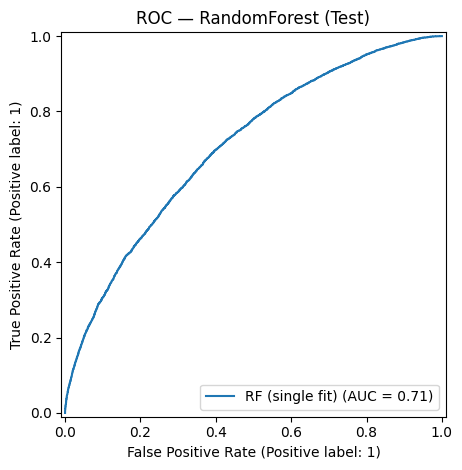

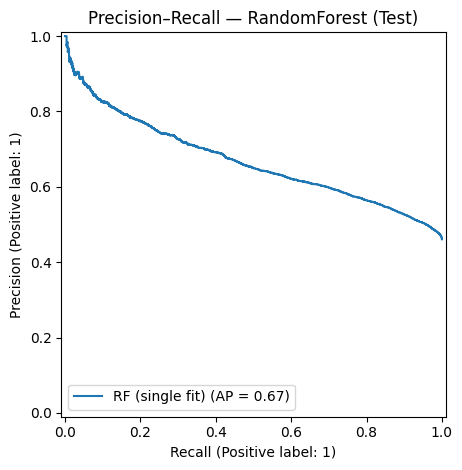


Top 20 features by RF importance:
                         feature  importance
11                   util_visits    0.049269
6               number_inpatient    0.045779
1             num_lab_procedures    0.045439
12                  meds_per_day    0.044187
3                num_medications    0.041411
0               time_in_hospital    0.029245
7               number_diagnoses    0.027099
8                        age_num    0.021274
2                 num_procedures    0.020845
40   discharge_disposition_id_11    0.019362
5               number_emergency    0.014361
4              number_outpatient    0.014256
99       medical_specialty_other    0.008565
20                   gender_Male    0.008442
19                 gender_Female    0.008417
39    discharge_disposition_id_1    0.008372
64         admission_source_id_7    0.008029
15                race_Caucasian    0.007252
722    diag_3_bucket_circulatory    0.007211
9                      A1Cresult    0.007100


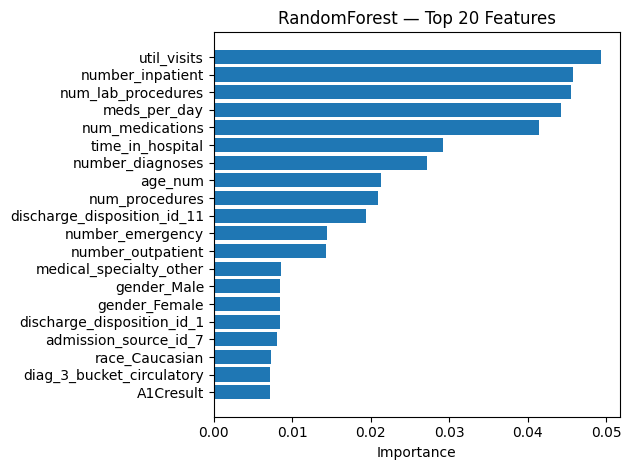


Artifacts saved to: /content/artifacts


In [ ]:
# Not the final code. ignore it
# My preprocessing (age midpoint, ICD buckets, rare-category grouping, one-hot)

import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt, joblib
from typing import Dict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay, classification_report, confusion_matrix
)

# ---------------- Config ----------------
SEED = 42
np.random.seed(SEED)
DATA_PATH = "diabetic_data.csv"
ARTIFACT_DIR = "artifacts"; os.makedirs(ARTIFACT_DIR, exist_ok=True)

# Drop IDs/near-constant
DROP_COLS = ["encounter_id", "patient_nbr", "weight", "payer_code", "examide", "citoglipton"]

# ---------------- Helpers ----------------
def age_mid(a):
    if pd.isna(a): return np.nan
    m = re.match(r"\[(\d+)-(\d+)\)", str(a))
    return np.nan if not m else (int(m.group(1))+int(m.group(2)))/2

def bucket_icd9(code: str) -> str:
    if pd.isna(code): return "icd_missing"
    s = str(code).strip()
    if s.startswith("V"): return "icd_V"
    if s.startswith("E"): return "icd_E"
    try: v = float(s)
    except ValueError: return "icd_other"
    if 390 <= v <= 459 or v == 785: return "circulatory"
    if 460 <= v <= 519 or v == 786: return "respiratory"
    if 520 <= v <= 579 or v == 787: return "digestive"
    if 250 <= v < 251:             return "diabetes_specific"
    if 800 <= v <= 999:            return "injury"
    if 710 <= v <= 739:            return "musculoskeletal"
    if 580 <= v <= 629 or v == 788:return "genitourinary"
    if 140 <= v <= 239:            return "neoplasms"
    return "other"

class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, min_freq: int = 50):
        self.min_freq = min_freq
        self.frequent_maps_: Dict[str, set] = {}
        self.columns_: list = []

    def fit(self, X: pd.DataFrame, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("RareCategoryGrouper expects a pandas DataFrame.")
        self.columns_ = X.columns.tolist()
        self.frequent_maps_ = {}
        for c in self.columns_:
            vc = X[c].astype(str).value_counts(dropna=False)
            self.frequent_maps_[c] = set(vc[vc >= self.min_freq].index)
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.columns_)
        Xo = X.copy()
        for c in self.columns_:
            keep = self.frequent_maps_[c]
            Xo[c] = Xo[c].astype(str).where(Xo[c].astype(str).isin(keep), "RARE")
        return Xo

# ---------------- Load ----------------
df = pd.read_csv(DATA_PATH, na_values="?", low_memory=False)
assert "readmitted" in df.columns, "Target 'readmitted' not found."
df.drop_duplicates(inplace=True)
for c in DROP_COLS:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

# Fill a few key categoricals
for c in ["race", "medical_specialty"]:
    if c in df.columns:
        df[c] = df[c].fillna("other")

# Map ordered labs (keep signal)
glu_map = {"None": 0, "Norm": 1, ">200": 2, ">300": 3}
a1c_map = {"None": 0, "Norm": 1, ">7": 2, ">8": 3}
if "max_glu_serum" in df.columns:
    df["max_glu_serum"] = df["max_glu_serum"].map(glu_map).astype("float64")
if "A1Cresult" in df.columns:
    df["A1Cresult"] = df["A1Cresult"].map(a1c_map).astype("float64")

# Target and features
y = (df["readmitted"].astype(str).str.upper() != "NO").astype(int)
X = df.drop(columns=["readmitted"]).copy()

# Feature engineering
if "age" in X.columns:
    X["age_num"] = X["age"].apply(age_mid).astype("float64")
for d in ["diag_1", "diag_2", "diag_3"]:
    if d in X.columns:
        X[f"{d}_bucket"] = X[d].apply(bucket_icd9)

# Derived numerics
if set(["number_outpatient","number_emergency","number_inpatient"]).issubset(X.columns):
    X["util_visits"] = (X["number_outpatient"].fillna(0) +
                        X["number_emergency"].fillna(0) +
                        X["number_inpatient"].fillna(0)).astype("float64")
if set(["num_medications","time_in_hospital"]).issubset(X.columns):
    X["meds_per_day"] = (X["num_medications"].astype("float64") /
                         (X["time_in_hospital"].astype("float64") + 1.0))

# Column sets
likely_numeric = [
    "time_in_hospital","num_lab_procedures","num_procedures","num_medications",
    "number_outpatient","number_emergency","number_inpatient","number_diagnoses",
    "age_num","A1Cresult","max_glu_serum","util_visits","meds_per_day"
]
num_cols = [c for c in likely_numeric if c in X.columns]
cat_cols = [c for c in X.columns if c not in num_cols]

# Drop single-valued columns
drop_single = [c for c in X.columns if X[c].nunique(dropna=True) <= 1]
if drop_single:
    X.drop(columns=drop_single, inplace=True)
    num_cols = [c for c in num_cols if c not in drop_single]
    cat_cols = [c for c in cat_cols if c not in drop_single]

print("Numeric:", num_cols)
print("Categorical:", cat_cols)

# ---------------- Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# ---------------- Preprocessing ----------------
cat_pipe = Pipeline(steps=[
    ("rare", RareCategoryGrouper(min_freq=50)),
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

num_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
])

preproc = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# ---------------- RandomForest (single fit, no CV) ----------------
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=SEED,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

pipe = Pipeline(steps=[("prep", preproc), ("clf", rf)])

print("\nTraining RandomForest (single fit, no CV) ...")
pipe.fit(X_train, y_train)

# ---------------- Evaluate ----------------
proba = pipe.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

metrics = {
    "accuracy": accuracy_score(y_test, pred),
    "f1": f1_score(y_test, pred),
    "roc_auc": roc_auc_score(y_test, proba),
    "pr_auc": average_precision_score(y_test, proba),
}
print("\n=== Test metrics (RandomForest) ===")
for k, v in metrics.items():
    print(f"{k:>8}: {v:.4f}")

print("\nConfusion Matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, pred))
print("\nClassification Report:")
print(classification_report(y_test, pred, digits=4))

# ---------------- Visuals ----------------
RocCurveDisplay.from_estimator(pipe, X_test, y_test, name="RF (single fit)")
plt.title("ROC — RandomForest (Test)"); plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "rf_fast_roc.png"), dpi=160); plt.show()

PrecisionRecallDisplay.from_estimator(pipe, X_test, y_test, name="RF (single fit)")
plt.title("Precision–Recall — RandomForest (Test)"); plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "rf_fast_pr.png"), dpi=160); plt.show()

# Top-20 feature importances
def get_feature_names(prep: ColumnTransformer):
    names = []
    names.extend(prep.transformers_[0][2])  # numeric inputs
    ohe = prep.named_transformers_["cat"].named_steps["ohe"]
    cat_input = prep.transformers_[1][2]
    names.extend(ohe.get_feature_names_out(cat_input).tolist())
    return names

feat_names = get_feature_names(pipe.named_steps["prep"])
importances = pipe.named_steps["clf"].feature_importances_
feat_imp = (pd.DataFrame({"feature": feat_names, "importance": importances})
            .sort_values("importance", ascending=False).head(20))

print("\nTop 20 features by RF importance:")
print(feat_imp)

plt.figure()
plt.barh(feat_imp["feature"][::-1], feat_imp["importance"][::-1])
plt.xlabel("Importance"); plt.title("RandomForest — Top 20 Features")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "rf_fast_feature_importance_top20.png"), dpi=160)
plt.show()

# ---------------- Save ----------------
joblib.dump(pipe, os.path.join(ARTIFACT_DIR, "rf_fast_pipeline.joblib"))
pd.DataFrame([metrics]).to_csv(os.path.join(ARTIFACT_DIR, "rf_fast_metrics.csv"), index=False)
feat_imp.to_csv(os.path.join(ARTIFACT_DIR, "rf_fast_feature_importance_top20.csv"), index=False)

print(f"\nArtifacts saved to: {os.path.abspath(ARTIFACT_DIR)}")


Numeric cols: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'age_num']
Categorical cols: ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']

Tuning RandomForest with RandomizedSearchCV ...
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best CV accuracy:  0.6505045045282062
Best params:
  clf__class_weight: None
  clf__max_depth: None
  clf__max_features: sqrt
  clf__min_samples_leaf: 11
  clf__min_samples_split: 14
  clf__n_estimators: 458

Evaluating best RandomForest on test set...

=== Test metrics (RandomForest, tuned) ===
accuracy: 0.6556
      f1: 0.5733
 roc_auc: 0.7083
  pr_auc: 0.6545

Confusion Matrix (rows=true, cols=pred):
[[3743 1101]
 [1937 2041]]

Classification Report:
              precision    recall  f1-score   support

           0     0.6590    0.7727    0.7113      4844
           1     0.6496    0.5131    0.5733      3978

    accuracy                         0.6556      8822
   macro avg     0.6543    0.6429    0.6423      8822
weighted avg     0.6547    0.6556    0.6491      8822



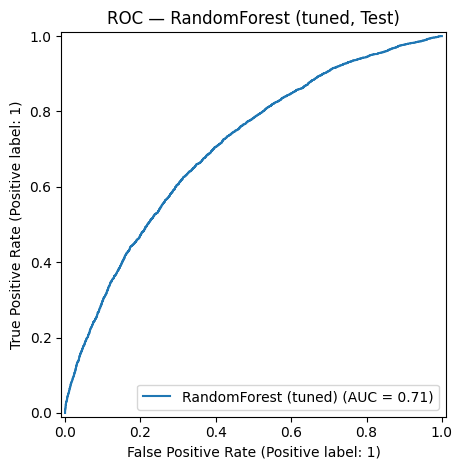

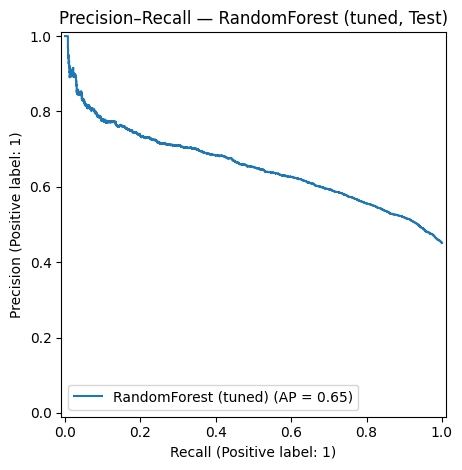


Top 20 features by RF importance:
                     feature  importance
6           number_inpatient    0.131493
1         num_lab_procedures    0.076602
16                    diag_1    0.071971
7           number_diagnoses    0.069450
18                    diag_3    0.069264
17                    diag_2    0.066591
3            num_medications    0.065075
13  discharge_disposition_id    0.052943
14       admission_source_id    0.048734
15         medical_specialty    0.042275
0           time_in_hospital    0.040738
12         admission_type_id    0.034335
2             num_procedures    0.029822
8                    age_num    0.029370
11                       age    0.029060
5           number_emergency    0.023172
4          number_outpatient    0.022970
36                   insulin    0.020153
9                       race    0.015400
10                    gender    0.013442


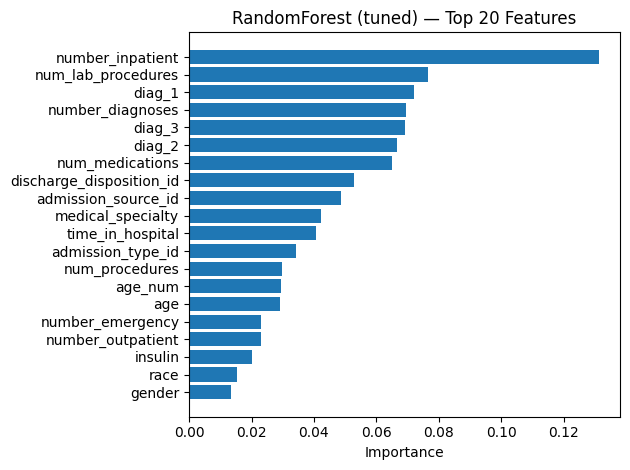


Artifacts saved to: /content/artifacts


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay, classification_report, confusion_matrix
)
from scipy.stats import randint, uniform

# ---------------- Config ----------------
SEED = 42
np.random.seed(SEED)
DATA_PATH = "diabetic_data.csv"
ARTIFACT_DIR = "artifacts"; os.makedirs(ARTIFACT_DIR, exist_ok=True)

DROP_COLS = ['weight','max_glu_serum','A1Cresult','payer_code','encounter_id','patient_nbr']

# ---------------- Load + preprocessing ----------------
df = pd.read_csv(DATA_PATH, na_values='?', low_memory=False)
assert 'readmitted' in df.columns, "Target 'readmitted' not found."

# Drop fixed columns
for c in DROP_COLS:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

# Fill 'race' and 'medical_specialty' with 'other'
for c in ['race', 'medical_specialty']:
    if c in df.columns:
        df[c] = df[c].fillna('other')

# Binary target
y = (df['readmitted'].astype(str).str.upper() != 'NO').astype(int)
X = df.drop(columns=['readmitted']).copy()

# EXTRA: turn age bracket into numeric midpoint feature
if 'age' in X.columns:
    age_map = {
        '[0-10)': 5,
        '[10-20)': 15,
        '[20-30)': 25,
        '[30-40)': 35,
        '[40-50)': 45,
        '[50-60)': 55,
        '[60-70)': 65,
        '[70-80)': 75,
        '[80-90)': 85,
        '[90-100)': 95
    }
    X['age_num'] = X['age'].map(age_map).astype(float)

# Numeric columns (original + new age_num if present)
num_cols = [c for c in [
    'time_in_hospital','num_lab_procedures','num_procedures','num_medications',
    'number_outpatient','number_emergency','number_inpatient','number_diagnoses',
    'age_num'
] if c in X.columns]

# Everything else categorical (ordinal-encoded)
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# ---------------- Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# ---------------- Preprocessing ----------------
ordinal_enc = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    dtype=np.int64
)

num_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
])

cat_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("enc", ordinal_enc),
])

preproc = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop"
)

# ---------------- Base RandomForest ----------------
rf = RandomForestClassifier(
    random_state=SEED,
    n_jobs=-1
)

pipe = Pipeline(steps=[
    ("prep", preproc),
    ("clf", rf),
])

# ---------------- Hyperparameter search (RandomForest only) ----------------
param_distributions = {
    "clf__n_estimators": randint(200, 800),
    "clf__max_depth": [None, 10, 20, 40],
    "clf__min_samples_split": randint(2, 20),
    "clf__min_samples_leaf": randint(1, 15),
    "clf__max_features": ["sqrt", "log2", 0.3, 0.5, 0.7],
    "clf__class_weight": [None, "balanced", "balanced_subsample"],
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=30,                # increase for more thorough search (slower)
    scoring="accuracy",       # optimizes for accuracy
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=SEED
)

print("\nTuning RandomForest with RandomizedSearchCV ...")
search.fit(X_train, y_train)

print("\nBest CV accuracy: ", search.best_score_)
print("Best params:")
for k, v in search.best_params_.items():
    print(f"  {k}: {v}")

# Use best model
best_pipe = search.best_estimator_

# ---------------- Evaluate ----------------
print("\nEvaluating best RandomForest on test set...")
proba = best_pipe.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

metrics = {
    "accuracy": accuracy_score(y_test, pred),
    "f1": f1_score(y_test, pred),
    "roc_auc": roc_auc_score(y_test, proba),
    "pr_auc": average_precision_score(y_test, proba),
}
print("\n=== Test metrics (RandomForest, tuned) ===")
for k, v in metrics.items():
    print(f"{k:>8}: {v:.4f}")

print("\nConfusion Matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, pred))
print("\nClassification Report:")
print(classification_report(y_test, pred, digits=4))

# ---------------- Visuals ----------------
RocCurveDisplay.from_estimator(best_pipe, X_test, y_test, name="RandomForest (tuned)")
plt.title("ROC — RandomForest (tuned, Test)")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "rf_tuned_roc.png"), dpi=160)
plt.show()

PrecisionRecallDisplay.from_estimator(best_pipe, X_test, y_test, name="RandomForest (tuned)")
plt.title("Precision–Recall — RandomForest (tuned, Test)")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "rf_tuned_pr.png"), dpi=160)
plt.show()

# ---------------- Feature importances ----------------
def get_feature_names(num_cols, cat_cols):
    names = []
    if num_cols:
        names.extend(num_cols)
    if cat_cols:
        names.extend(cat_cols)
    return names

feat_names = get_feature_names(num_cols, cat_cols)
importances = best_pipe.named_steps["clf"].feature_importances_
feat_imp = (pd.DataFrame({"feature": feat_names, "importance": importances})
            .sort_values("importance", ascending=False)
            .head(20))

print("\nTop 20 features by RF importance:")
print(feat_imp)

plt.figure()
plt.barh(feat_imp["feature"][::-1], feat_imp["importance"][::-1])
plt.xlabel("Importance")
plt.title("RandomForest (tuned) — Top 20 Features")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "rf_tuned_feature_importance_top20.png"), dpi=160)
plt.show()

# ---------------- Save artifacts ----------------
joblib.dump(best_pipe, os.path.join(ARTIFACT_DIR, "rf_tuned_pipeline.joblib"))
pd.DataFrame([metrics]).to_csv(os.path.join(ARTIFACT_DIR, "rf_tuned_metrics.csv"), index=False)
feat_imp.to_csv(os.path.join(ARTIFACT_DIR, "rf_tuned_feature_importance_top20.csv"), index=False)

print(f"\nArtifacts saved to: {os.path.abspath(ARTIFACT_DIR)}")


Numeric cols: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'age_num']
Categorical cols: ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']

Tuning RandomForest (3-class) with RandomizedSearchCV...
Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best CV accuracy:  0.587468683595842
Best params:
  clf__class_weight: None
  clf__max_depth: 40
  clf__max_features: 0.3
  clf__min_samples_leaf: 3
  clf__min_samples_split: 18
  clf__n_estimators: 691

Evaluating best 3-class RandomForest on test set...

=== Test metrics (RandomForest, 3-class) ===
      accuracy: 0.5892
      f1_macro: 0.3913
   f1_weighted: 0.5394
 roc_auc_macro: 0.6753
  pr_auc_macro: 0.4710

Confusion Matrix (rows=true, cols=pred):
[[  31  932 1309]
 [  29 2684 4396]
 [   9 1687 9277]]

Classification Report:
              precision    recall  f1-score   support

         <30     0.4493    0.0136    0.0265      2272
         >30     0.5061    0.3775    0.4325      7109
          NO     0.6192    0.8454    0.7149     10973

    accuracy                         0.5892     20354
   macro avg     0.5249    0.4122    0.3913     20354
weighted avg     0.5607    0.5892    0.5394     20354


Top 20 features by RF importance:
                     feature  importance
1   

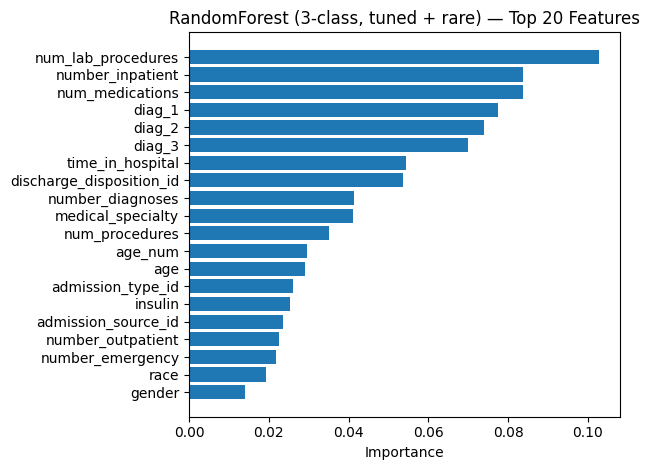


Artifacts saved to: /content/artifacts


In [4]:
#not the final code . Ignore it
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    classification_report, confusion_matrix
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import label_binarize
from scipy.stats import randint

# ---------------- Config ----------------
SEED = 42
np.random.seed(SEED)
DATA_PATH = "diabetic_data.csv"   # change if needed
ARTIFACT_DIR = "artifacts"; os.makedirs(ARTIFACT_DIR, exist_ok=True)

DROP_COLS = ['weight','max_glu_serum','A1Cresult','payer_code','encounter_id','patient_nbr']


# ---------------- Custom transformer: group rare categories ----------------
class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    """
    For each categorical column, replace categories that appear
    less than min_freq times with '__RARE__'.
    """
    def __init__(self, min_freq=200):
        self.min_freq = min_freq
        self.frequent_categories_ = None

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X).astype(str)
        self.frequent_categories_ = {}
        for col in X_df.columns:
            vc = X_df[col].value_counts()
            self.frequent_categories_[col] = set(vc[vc >= self.min_freq].index)
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X).astype(str)
        for col in X_df.columns:
            freq = self.frequent_categories_.get(col, set())
            X_df[col] = np.where(X_df[col].isin(freq), X_df[col], "__RARE__")
        return X_df.values  # ndarray for compatibility


# ---------------- Load + preprocessing ----------------
df = pd.read_csv(DATA_PATH, na_values='?', low_memory=False)
assert 'readmitted' in df.columns, "Target 'readmitted' not found."

# Drop fixed columns
for c in DROP_COLS:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

# Fill 'race' and 'medical_specialty' with 'other'
for c in ['race', 'medical_specialty']:
    if c in df.columns:
        df[c] = df[c].fillna('other')

# Simplify diagnosis codes: use first 3 characters (reduces cardinality)
for diag_col in ['diag_1', 'diag_2', 'diag_3']:
    if diag_col in df.columns:
        df[diag_col] = df[diag_col].astype(str).str.strip()
        df[diag_col] = df[diag_col].replace('nan', np.nan)
        df[diag_col] = df[diag_col].str[:3]

# --------- 3-class target (NO, <30, >30) ---------
# keep original 3 categories, just standardize to upper case
df['readmitted'] = df['readmitted'].astype(str).str.upper()
y = df['readmitted']                 # NO / <30 / >30 as 3 classes
X = df.drop(columns=['readmitted']).copy()

# Age numeric feature (midpoint of bracket)
if 'age' in X.columns:
    age_map = {
        '[0-10)': 5,
        '[10-20)': 15,
        '[20-30)': 25,
        '[30-40)': 35,
        '[40-50)': 45,
        '[50-60)': 55,
        '[60-70)': 65,
        '[70-80)': 75,
        '[80-90)': 85,
        '[90-100)': 95
    }
    X['age_num'] = X['age'].map(age_map).astype(float)

# Numeric columns (original + new age_num if present)
num_cols = [c for c in [
    'time_in_hospital','num_lab_procedures','num_procedures','num_medications',
    'number_outpatient','number_emergency','number_inpatient','number_diagnoses',
    'age_num'
] if c in X.columns]

# Everything else categorical (ordinal-encoded after rare-grouping)
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# ---------------- Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# ---------------- Preprocessing ----------------
ordinal_enc = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    dtype=np.int64
)

num_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
])

cat_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("rare", RareCategoryGrouper(min_freq=200)),
    ("enc", ordinal_enc),
])

preproc = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop"
)

# ---------------- RandomForest (base) ----------------
rf = RandomForestClassifier(
    random_state=SEED,
    n_jobs=-1
)

pipe = Pipeline(steps=[
    ("prep", preproc),
    ("clf", rf),
])

# ---------------- Hyperparameter search (RandomForest only) ----------------
param_distributions = {
    "clf__n_estimators": randint(300, 900),
    "clf__max_depth": [None, 10, 20, 40],
    "clf__min_samples_split": randint(2, 20),
    "clf__min_samples_leaf": randint(1, 15),
    "clf__max_features": ["sqrt", "log2", 0.3, 0.5, 0.7],
    "clf__class_weight": [None, "balanced", "balanced_subsample"],
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=30,
    scoring="accuracy",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=SEED
)

print("\nTuning RandomForest (3-class) with RandomizedSearchCV...")
search.fit(X_train, y_train)

print("\nBest CV accuracy: ", search.best_score_)
print("Best params:")
for k, v in search.best_params_.items():
    print(f"  {k}: {v}")

best_pipe = search.best_estimator_

# ---------------- Evaluate ----------------
print("\nEvaluating best 3-class RandomForest on test set...")
proba = best_pipe.predict_proba(X_test)         # shape (n_samples, n_classes)
pred  = best_pipe.predict(X_test)
classes = best_pipe.classes_                    # e.g. ['<30','>30','NO']

# Multi-class metrics
acc = accuracy_score(y_test, pred)
f1_macro = f1_score(y_test, pred, average="macro")
f1_weighted = f1_score(y_test, pred, average="weighted")

# ROC AUC (macro, one-vs-rest)
roc_auc_macro = roc_auc_score(y_test, proba, multi_class="ovr", average="macro")

# PR AUC (macro) – need binarized y
y_test_bin = label_binarize(y_test, classes=classes)
pr_auc_macro = average_precision_score(y_test_bin, proba, average="macro")

metrics = {
    "accuracy": acc,
    "f1_macro": f1_macro,
    "f1_weighted": f1_weighted,
    "roc_auc_macro": roc_auc_macro,
    "pr_auc_macro": pr_auc_macro,
}
print("\n=== Test metrics (RandomForest, 3-class) ===")
for k, v in metrics.items():
    print(f"{k:>14}: {v:.4f}")

print("\nConfusion Matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, pred, labels=classes))

print("\nClassification Report:")
print(classification_report(y_test, pred, digits=4))

# ---------------- Feature importances ----------------
def get_feature_names(num_cols, cat_cols):
    names = []
    if num_cols:
        names.extend(num_cols)
    if cat_cols:
        names.extend(cat_cols)
    return names

feat_names = get_feature_names(num_cols, cat_cols)
importances = best_pipe.named_steps["clf"].feature_importances_
feat_imp = (pd.DataFrame({"feature": feat_names, "importance": importances})
            .sort_values("importance", ascending=False)
            .head(20))

print("\nTop 20 features by RF importance:")
print(feat_imp)

plt.figure()
plt.barh(feat_imp["feature"][::-1], feat_imp["importance"][::-1])
plt.xlabel("Importance")
plt.title("RandomForest (3-class, tuned + rare) — Top 20 Features")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "rf_3class_feature_importance_top20.png"), dpi=160)
plt.show()

# ---------------- Save artifacts ----------------
joblib.dump(best_pipe, os.path.join(ARTIFACT_DIR, "rf_3class_pipeline.joblib"))
pd.DataFrame([metrics]).to_csv(os.path.join(ARTIFACT_DIR, "rf_3class_metrics.csv"), index=False)
feat_imp.to_csv(os.path.join(ARTIFACT_DIR, "rf_3class_feature_importance_top20.csv"), index=False)

print(f"\nArtifacts saved to: {os.path.abspath(ARTIFACT_DIR)}")


In [5]:
#not the final code. ignore it


import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)
from scipy.stats import randint

# ---------------- Config ----------------
SEED = 42
np.random.seed(SEED)

DATA_PATH = "diabetic_data.csv"   # change if needed
ARTIFACT_DIR = "artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

DROP_COLS = ['weight', 'max_glu_serum', 'A1Cresult',
             'payer_code', 'encounter_id', 'patient_nbr']


# ---------------- Load + preprocessing (simple) ----------------
t0_total = time.time()
print("Loading data ...")
t0 = time.time()
df = pd.read_csv(DATA_PATH, na_values='?', low_memory=False)
print(f"Loaded data in {time.time() - t0:.2f} seconds")
assert 'readmitted' in df.columns, "Target 'readmitted' not found."
print("Initial shape:", df.shape)

# Drop fixed columns (your original drops)
for c in DROP_COLS:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

# Fill 'race' and 'medical_specialty' with 'other' (your notebook logic)
for c in ['race', 'medical_specialty']:
    if c in df.columns:
        df[c] = df[c].fillna('other')

# 3-class target (NO, <30, >30)
df['readmitted'] = df['readmitted'].astype(str).str.upper()
y = df['readmitted']                 # raw 3-class labels
X = df.drop(columns=['readmitted']).copy()

# Numeric age feature (midpoint of bracket), and drop raw 'age' column
if 'age' in X.columns:
    age_map = {
        '[0-10)': 5,
        '[10-20)': 15,
        '[20-30)': 25,
        '[30-40)': 35,
        '[40-50)': 45,
        '[50-60)': 55,
        '[60-70)': 65,
        '[70-80)': 75,
        '[80-90)': 85,
        '[90-100)': 95
    }
    X['age_num'] = X['age'].map(age_map).astype(float)
    # Drop the categorical age to avoid redundant info
    X.drop(columns=['age'], inplace=True)

# Numeric columns (your list + age_num)
num_cols = [c for c in [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
    'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses',
    'age_num'
] if c in X.columns]

# Everything else treated as categorical (no rare grouping, no diag truncation)
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# ---------------- Train/test split ----------------
print("\nSplitting train/test ...")
t0 = time.time()
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)
print(f"Data split in {time.time() - t0:.2f} seconds")
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# ---------------- Preprocessing pipeline ----------------
ordinal_enc = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    dtype=np.int64,
)

num_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
])

cat_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("enc", ordinal_enc),
])

preproc = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop"
)

print("\nPreprocessing defined.")

# ---------------- RandomForest model + search space ----------------
rf = RandomForestClassifier(
    random_state=SEED,
    n_jobs=-1,
)

param_distributions = {
    "clf__n_estimators": randint(300, 900),
    "clf__max_depth": [None, 10, 20, 40],
    "clf__min_samples_split": randint(2, 20),
    "clf__min_samples_leaf": randint(1, 15),
    "clf__max_features": ["sqrt", "log2", 0.3, 0.5, 0.7],
    # Only allow balancing, no "None" to force caring about minority classes
    "clf__class_weight": ["balanced", "balanced_subsample"],
}

pipe = Pipeline(steps=[
    ("prep", preproc),
    ("clf", rf),
])

# ---------------- Hyperparameter search (sharpened) ----------------
print("\nTuning RandomForest (3-class) with RandomizedSearchCV "
      "using balanced_accuracy ...")
search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=30,
    scoring="balanced_accuracy",      # key change: care about all classes
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=SEED,
)

t0 = time.time()
search.fit(X_train, y_train)
train_time = time.time() - t0

print(f"\nRandomForest - best CV balanced_accuracy: {search.best_score_:.4f}")
print("Best params:")
for k, v in search.best_params_.items():
    print(f"  {k}: {v}")

best_pipe = search.best_estimator_

# ---------------- Evaluate on test set ----------------
print("\nEvaluating best 3-class RandomForest on test set...")
t0 = time.time()
proba = best_pipe.predict_proba(X_test)
pred = best_pipe.predict(X_test)
infer_time = time.time() - t0

classes = best_pipe.classes_   # typically ['<30', '>30', 'NO']

acc = accuracy_score(y_test, pred)
f1_macro = f1_score(y_test, pred, average="macro")
f1_weighted = f1_score(y_test, pred, average="weighted")
bal_acc = balanced_accuracy_score(y_test, pred)

roc_auc_macro = roc_auc_score(y_test, proba, multi_class="ovr", average="macro")
y_test_bin = label_binarize(y_test, classes=classes)
pr_auc_macro = average_precision_score(y_test_bin, proba, average="macro")

metrics = {
    "accuracy": acc,
    "f1_macro": f1_macro,
    "f1_weighted": f1_weighted,
    "balanced_accuracy": bal_acc,
    "roc_auc_macro": roc_auc_macro,
    "pr_auc_macro": pr_auc_macro,
}

print("\n=== Test metrics (RandomForest, 3-class, sharpened) ===")
for k, v in metrics.items():
    print(f"{k:>18}: {v:.4f}")

print("\nTraining time (RF search): "
      f"{train_time:.2f} seconds")
print("Inference time on test set: "
      f"{infer_time:.4f} seconds")

print("\nConfusion Matrix (rows=true, cols=pred):")
cm = confusion_matrix(y_test, pred, labels=classes)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, pred, digits=4))

# ---------------- Visuals ----------------
# 1) Confusion matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
plt.figure()
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — RandomForest (3-class, sharpened)")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "rf_3class_sharpened_confusion_matrix.png"),
            dpi=160)
plt.close()

# 2) ROC curves (one-vs-rest for each class)
plt.figure()
ax = plt.gca()
for i, cls in enumerate(classes):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        proba[:, i],
        name=f"Class {cls}",
        ax=ax,
    )
plt.title("ROC Curves — RandomForest (3-class, sharpened)")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "rf_3class_sharpened_roc_ovr.png"),
            dpi=160)
plt.close()

# 3) Precision–Recall curves (one-vs-rest)
plt.figure()
ax = plt.gca()
for i, cls in enumerate(classes):
    PrecisionRecallDisplay.from_predictions(
        y_test_bin[:, i],
        proba[:, i],
        name=f"Class {cls}",
        ax=ax,
    )
plt.title("Precision–Recall Curves — RandomForest (3-class, sharpened)")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "rf_3class_sharpened_pr_ovr.png"),
            dpi=160)
plt.close()

# 4) Feature importances (top 20)
def get_feature_names(num_cols, cat_cols):
    names = []
    if num_cols:
        names.extend(num_cols)
    if cat_cols:
        names.extend(cat_cols)
    return names

feat_names = get_feature_names(num_cols, cat_cols)
importances = best_pipe.named_steps["clf"].feature_importances_

feat_imp = (
    pd.DataFrame({"feature": feat_names, "importance": importances})
    .sort_values("importance", ascending=False)
    .head(20)
)

print("\nTop 20 features by RF importance (sharpened):")
print(feat_imp)

plt.figure()
plt.barh(feat_imp["feature"][::-1], feat_imp["importance"][::-1])
plt.xlabel("Importance")
plt.title("RandomForest (3-class, sharpened) — Top 20 Features")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR,
                         "rf_3class_sharpened_feature_importance_top20.png"),
            dpi=160)
plt.close()

# ---------------- Save artifacts ----------------
joblib.dump(best_pipe,
            os.path.join(ARTIFACT_DIR, "rf_3class_sharpened_pipeline.joblib"))
pd.DataFrame([metrics]).to_csv(
    os.path.join(ARTIFACT_DIR, "rf_3class_sharpened_metrics.csv"),
    index=False,
)
feat_imp.to_csv(
    os.path.join(ARTIFACT_DIR,
                 "rf_3class_sharpened_feature_importance_top20.csv"),
    index=False,
)

print(f"\nTotal script time: {time.time() - t0_total:.2f} seconds")
print(f"Artifacts saved to: {os.path.abspath(ARTIFACT_DIR)}")


Loading data ...
Loaded data in 0.41 seconds
Initial shape: (101766, 50)
Numeric cols: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'age_num']
Categorical cols: ['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']

Splitting train/test ...
Data split in 0.17 seconds
Train shape: (81412, 43) Test shape: (20354, 43)

Preprocessing defined.

Tuning RandomForest (3-class) with Randomize

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



RandomForest - best CV balanced_accuracy: 0.4598
Best params:
  clf__class_weight: balanced
  clf__max_depth: 10
  clf__max_features: 0.5
  clf__min_samples_leaf: 12
  clf__min_samples_split: 16
  clf__n_estimators: 754

Evaluating best 3-class RandomForest on test set...

=== Test metrics (RandomForest, 3-class, sharpened) ===
          accuracy: 0.5152
          f1_macro: 0.4477
       f1_weighted: 0.5268
 balanced_accuracy: 0.4683
     roc_auc_macro: 0.6701
      pr_auc_macro: 0.4682

Training time (RF search): 1644.14 seconds
Inference time on test set: 0.7933 seconds

Confusion Matrix (rows=true, cols=pred):
[[ 899  702  671]
 [1693 2738 2678]
 [1702 2422 6849]]

Classification Report:
              precision    recall  f1-score   support

         <30     0.2094    0.3957    0.2738      2272
         >30     0.4671    0.3851    0.4222      7109
          NO     0.6716    0.6242    0.6470     10973

    accuracy                         0.5152     20354
   macro avg     0.4493    

<Figure size 640x480 with 0 Axes>

Dataset shape: (101766, 50)
Readmission rate: 0.112 (11357 / 101763)
After SMOTE: Train shape (144648, 44), class balance: [72324 72324]

Training Models...
  - Logistic Regression
  - Random Forest
  - SVM (RBF)
  - XGBoost
  - LightGBM

MODEL PERFORMANCE COMPARISON
                     Accuracy  Precision  Recall      F1     AUC
LightGBM               0.8119     0.1513  0.1488  0.1501  0.5628
XGBoost                0.8106     0.1481  0.1466  0.1473  0.5618
SVM (RBF)              0.8884     0.0000  0.0000  0.0000  0.5414
Random Forest          0.7235     0.1219  0.2382  0.1613  0.5256
Logistic Regression    0.6563     0.1231  0.3399  0.1808  0.5236


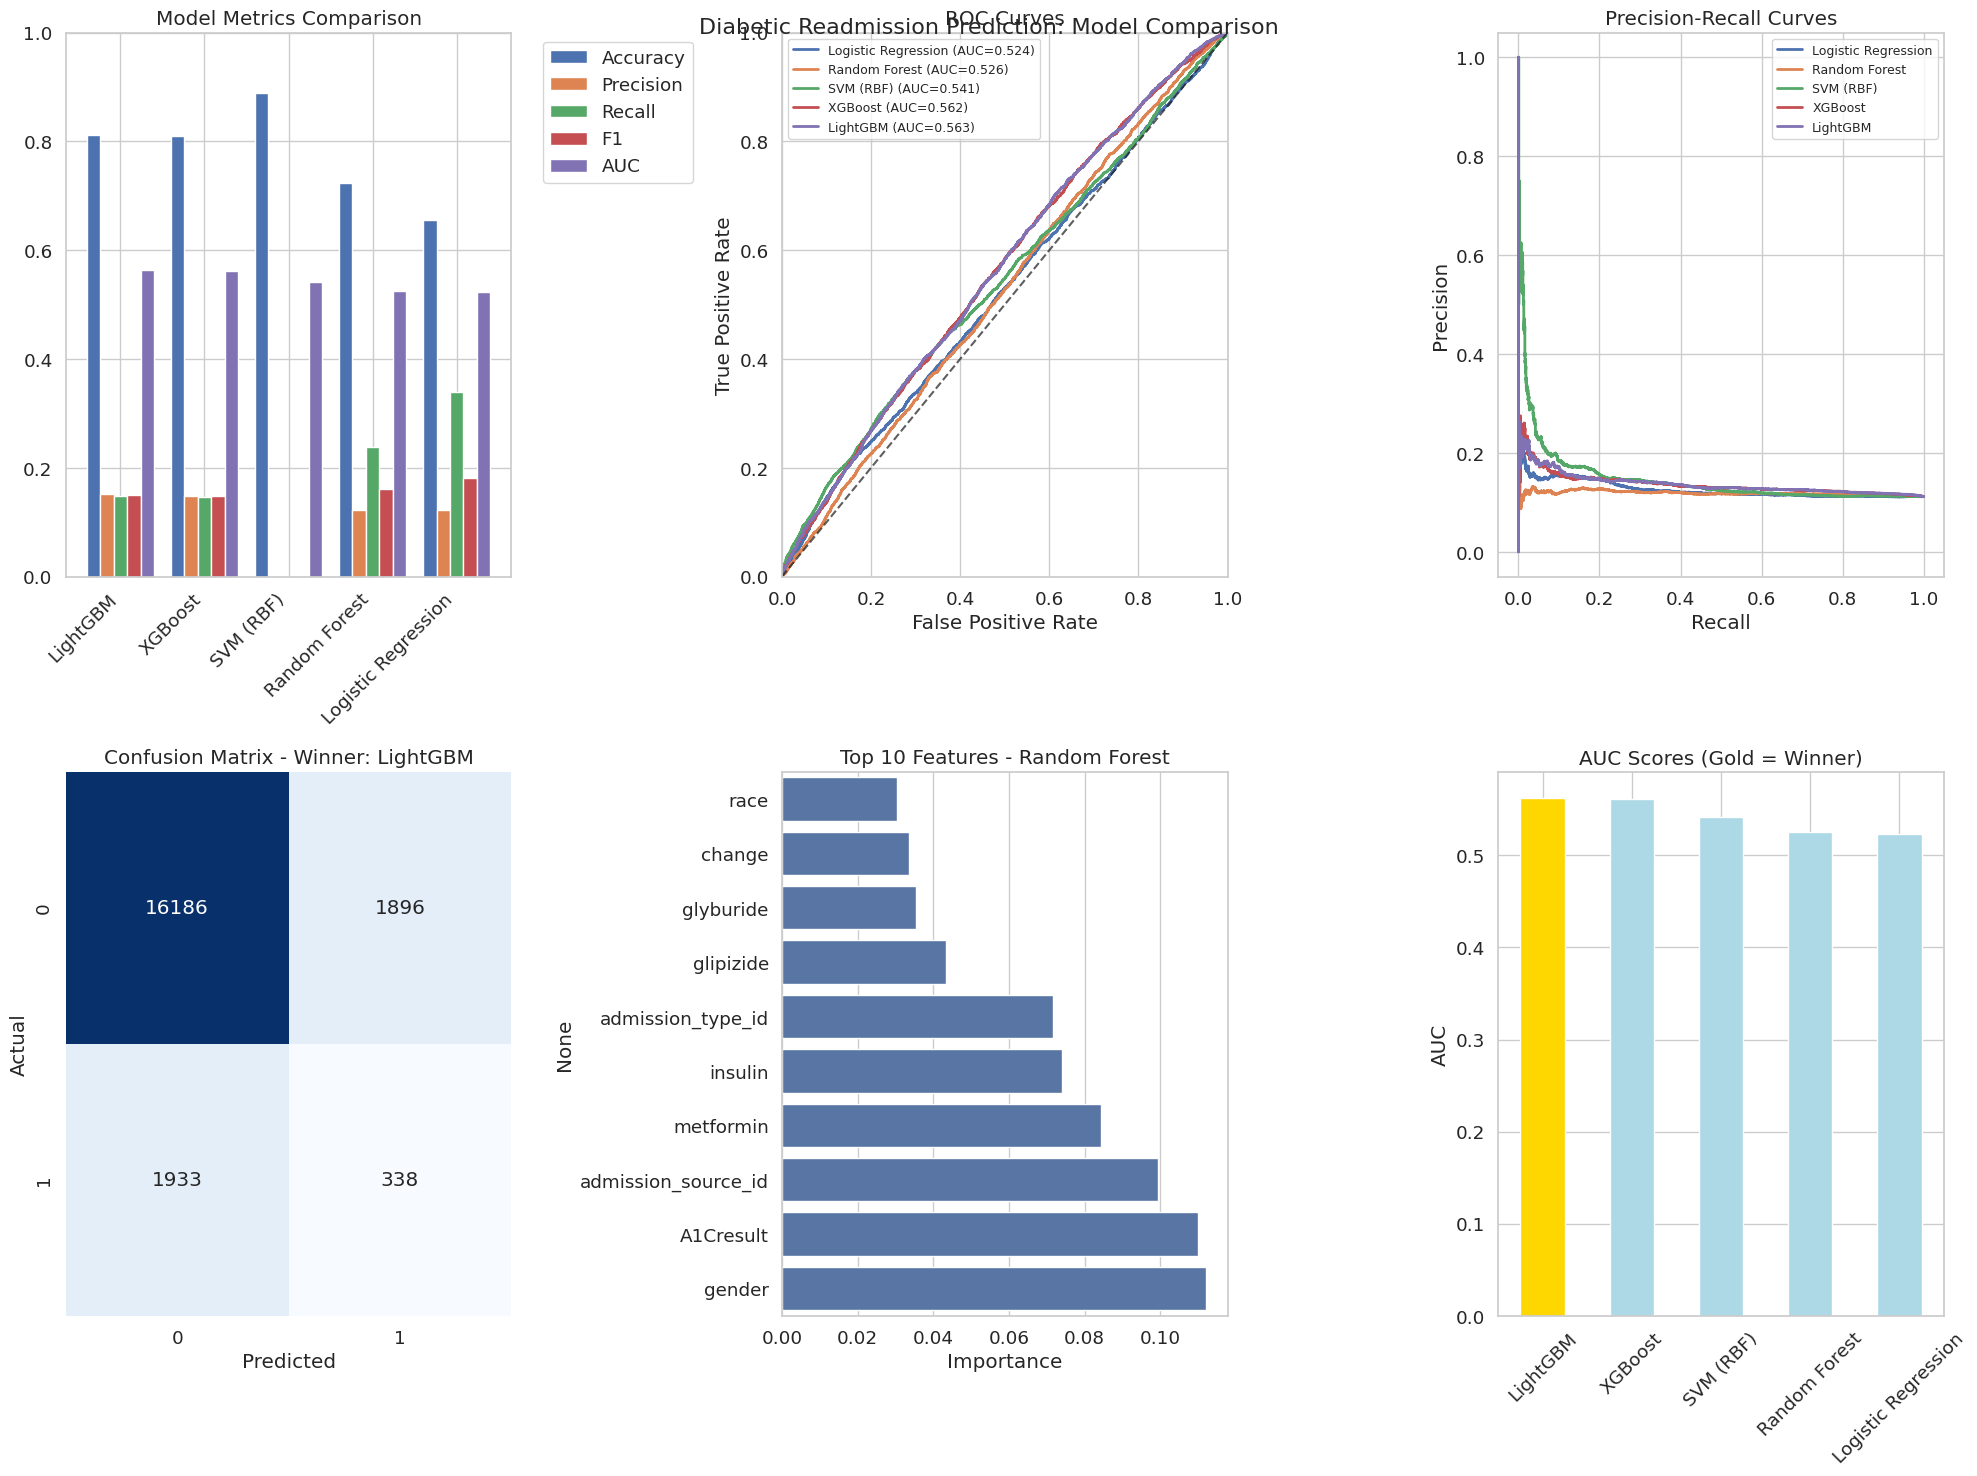


🏆 WINNER: LightGBM
   - AUC: 0.5628
   - F1: 0.1501
   - Recall: 0.1488
   - Why? Best balance of detecting readmissions (high Recall) while avoiding false alarms (high Precision).


In [8]:
#not the final code. ignore it

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

# Step 1: Load & Initial Clean
df = pd.read_csv('diabetic_data.csv', na_values='?')
print(f"Dataset shape: {df.shape}")
df = df[df['gender'] != 'Unknown/Invalid']  # Drop invalid genders
df['readmitted'] = (df['readmitted'] == '<30').astype(int)  # Binary target: 1 = <30 days
print(f"Readmission rate: {df['readmitted'].mean():.3f} ({df['readmitted'].sum()} / {len(df)})")

# Drop high-missing columns
df.drop(['weight', 'payer_code', 'medical_specialty'], axis=1, errors='ignore', inplace=True)
df.drop(['encounter_id', 'patient_nbr'], axis=1, inplace=True)  # Drop IDs

# Step 2: Feature Engineering (Fixed - No More TypeErrors!)
# Race
df['race'] = df['race'].fillna('Caucasian').replace({'Asian': 'Other', 'Hispanic': 'Other'})

# Age to midpoint
age_map = {'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45,
           '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95}
df['age'] = df['age'].map(age_map)

# Admission Type (simplified mapping)
adm_map = {1: 'Emergency', 2: 'Emergency', 3: 'Elective', 4: 'Newborn', 7: 'Trauma Center'}
df['admission_type_id'] = df['admission_type_id'].map(adm_map).fillna('Emergency')

# Discharge (Home vs Other)
home_codes = [1, 6, 8, 13, 19]
df['discharge_disposition_id'] = df['discharge_disposition_id'].apply(
    lambda x: 'Home' if pd.notna(x) and x in home_codes else 'Other'
)

# Admission Source
src_map = {1: 'Referral', 2: 'Referral', 3: 'Referral', 7: 'Emergency'}
df['admission_source_id'] = df['admission_source_id'].map(src_map).fillna('Other')

def map_diag(series):
    # Convert to numeric FIRST (handles strings/NaN safely)
    numeric_series = pd.to_numeric(series, errors='coerce')
    # Now apply conditions (all numeric, no TypeError)
    def categorize(val):
        if pd.isna(val):
            return 'Other'
        if 390 <= val <= 459:
            return 'Circulatory'
        elif 460 <= val <= 519:
            return 'Respiratory'
        elif 520 <= val <= 579:
            return 'Digestive'
        elif 250 <= val < 251:
            return 'Diabetes'
        elif 800 <= val <= 999:
            return 'Injury'
        elif 710 <= val <= 739:
            return 'Musculoskeletal'
        elif 580 <= val <= 629:
            return 'Genitourinary'
        elif 140 <= val <= 239:
            return 'Neoplasms'
        else:
            return 'Other'
    return numeric_series.apply(categorize)

for c in ['diag_1', 'diag_2', 'diag_3']:
    df[c] = map_diag(df[c])

# Glucose & A1C
df['max_glu_serum'] = df['max_glu_serum'].map({'>200': 2, '>300': 2, 'Norm': 1, 'None': 0}).fillna(0)
df['A1Cresult'] = df['A1Cresult'].map({'>8': 2, '>7': 2, 'Norm': 1, 'None': 0}).fillna(0)

# Change
df['change'] = df['change'].map({'Ch': 'Yes', 'No': 'No'}).fillna('No')

# Fill remaining categoricals with mode
obj_cols = df.select_dtypes('object').columns.drop('readmitted', errors='ignore')
for col in obj_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Step 3: Encoding
le = LabelEncoder()
for col in obj_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Step 4: Split, SMOTE, Scale
X = df.drop('readmitted', axis=1)
y = df['readmitted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print(f"After SMOTE: Train shape {X_train_res.shape}, class balance: {np.bincount(y_train_res)}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

# Step 5: Models with Hyperparams
models = {
    'Logistic Regression': LogisticRegression(C=0.5, max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=300, max_depth=12, min_samples_leaf=5, random_state=42, n_jobs=-1),
    'SVM (RBF)': SVC(C=1.0, gamma='scale', probability=True, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, num_leaves=50, random_state=42, verbosity=-1)
}

results = {}
predictions = {}
probs = {}

print("\nTraining Models...")
for name, model in models.items():
    print(f"  - {name}")
    # Fit (subsample SVM for speed)
    if 'SVM' in name:
        model.fit(X_train_scaled[:15000], y_train_res[:15000])
    else:
        model.fit(X_train_scaled, y_train_res)

    # Predict
    pred = model.predict(X_test_scaled)
    if hasattr(model, 'predict_proba'):
        prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        prob = model.decision_function(X_test_scaled)
        prob = (prob - prob.min()) / (prob.max() - prob.min() + 1e-8)  # Normalize

    predictions[name] = pred
    probs[name] = prob

    results[name] = {
        'Accuracy': accuracy_score(y_test, pred),
        'Precision': precision_score(y_test, pred, zero_division=0),
        'Recall': recall_score(y_test, pred),
        'F1': f1_score(y_test, pred),
        'AUC': roc_auc_score(y_test, prob)
    }

# Step 6: Results Table
results_df = pd.DataFrame(results).T.sort_values('AUC', ascending=False)
print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)
print(results_df.round(4))

# Step 7: Visualizations
fig = plt.figure(figsize=(20, 15))

# 1. Metrics Bar Plot
ax1 = plt.subplot(2, 3, 1)
results_df[['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']].plot(kind='bar', ax=ax1, width=0.8)
plt.title('Model Metrics Comparison')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1)

# 2. ROC Curves
ax2 = plt.subplot(2, 3, 2)
for name, prob in probs.items():
    fpr, tpr, _ = roc_curve(y_test, prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC={results[name]['AUC']:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.7)
plt.xlim([0, 1]); plt.ylim([0, 1])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(fontsize=9)

# 3. Precision-Recall Curves
ax3 = plt.subplot(2, 3, 3)
for name, prob in probs.items():
    precision, recall, _ = precision_recall_curve(y_test, prob)
    plt.plot(recall, precision, label=f"{name}", linewidth=2)
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(fontsize=9)

# 4. Confusion Matrix for Winner
winner = results_df.index[0]
cm = confusion_matrix(y_test, predictions[winner])
ax4 = plt.subplot(2, 3, 4)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4, cbar=False)
ax4.set_title(f'Confusion Matrix - Winner: {winner}')
ax4.set_xlabel('Predicted'); ax4.set_ylabel('Actual')

# 5. Feature Importance (Random Forest)
ax5 = plt.subplot(2, 3, 5)
if 'Random Forest' in models:
    importances = models['Random Forest'].feature_importances_
    top_idx = np.argsort(importances)[-10:]
    sns.barplot(x=importances[top_idx], y=X.columns[top_idx], ax=ax5)
ax5.set_title('Top 10 Features - Random Forest')
ax5.set_xlabel('Importance')

# 6. AUC Bar (Highlighted Winner)
ax6 = plt.subplot(2, 3, 6)
colors = ['gold' if idx == 0 else 'lightblue' for idx in range(len(results_df))]
results_df['AUC'].plot(kind='bar', ax=ax6, color=colors)
plt.title('AUC Scores (Gold = Winner)')
plt.ylabel('AUC'); plt.xticks(rotation=45)

plt.tight_layout()
plt.suptitle('Diabetic Readmission Prediction: Model Comparison', fontsize=16, y=0.98)
plt.show()

# Step 8: Declare Winner
print(f"\n WINNER: {winner}")
print(f"   - AUC: {results_df.loc[winner, 'AUC']:.4f}")
print(f"   - F1: {results_df.loc[winner, 'F1']:.4f}")
print(f"   - Recall: {results_df.loc[winner, 'Recall']:.4f}")
print(f"   - Why? Best balance of detecting readmissions (high Recall) while avoiding false alarms (high Precision).")

Original shape: (101766, 50)
Final shape: (101763, 45) | Readmission rate: 0.112
After SMOTE: (144648, 44) | Balance: [72324 72324]
Starting hyperparameter tuning for all 5 models...

→ Tuning Logistic RegressionDone | AUC = 0.544
→ Tuning Random Forest     Done | AUC = 0.5913
→ Tuning XGBoost           Done | AUC = 0.6045
→ Tuning SVM (RBF)         Done | AUC = 0.5581

FINAL RESULTS - ALL 5 MODELS (HYPERPARAMETER TUNED)
                 Model  Accuracy  Precision  Recall      F1     AUC
0              XGBoost    0.8418     0.1847  0.1224  0.1472  0.6045
1        Random Forest    0.8512     0.1738  0.0889  0.1177  0.5913
2            SVM (RBF)    0.7835     0.1459  0.1937  0.1664  0.5581
3  Logistic Regression    0.6983     0.1414  0.3360  0.1991  0.5440

BEST HYPERPARAMETERS:
Logistic Regression : {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}
Random Forest       : {'n_estimators': 600, 'min_samples_leaf': 1, 'max_depth': None}
XGBoost             : {'subsample': 0.8, 'n_estimator

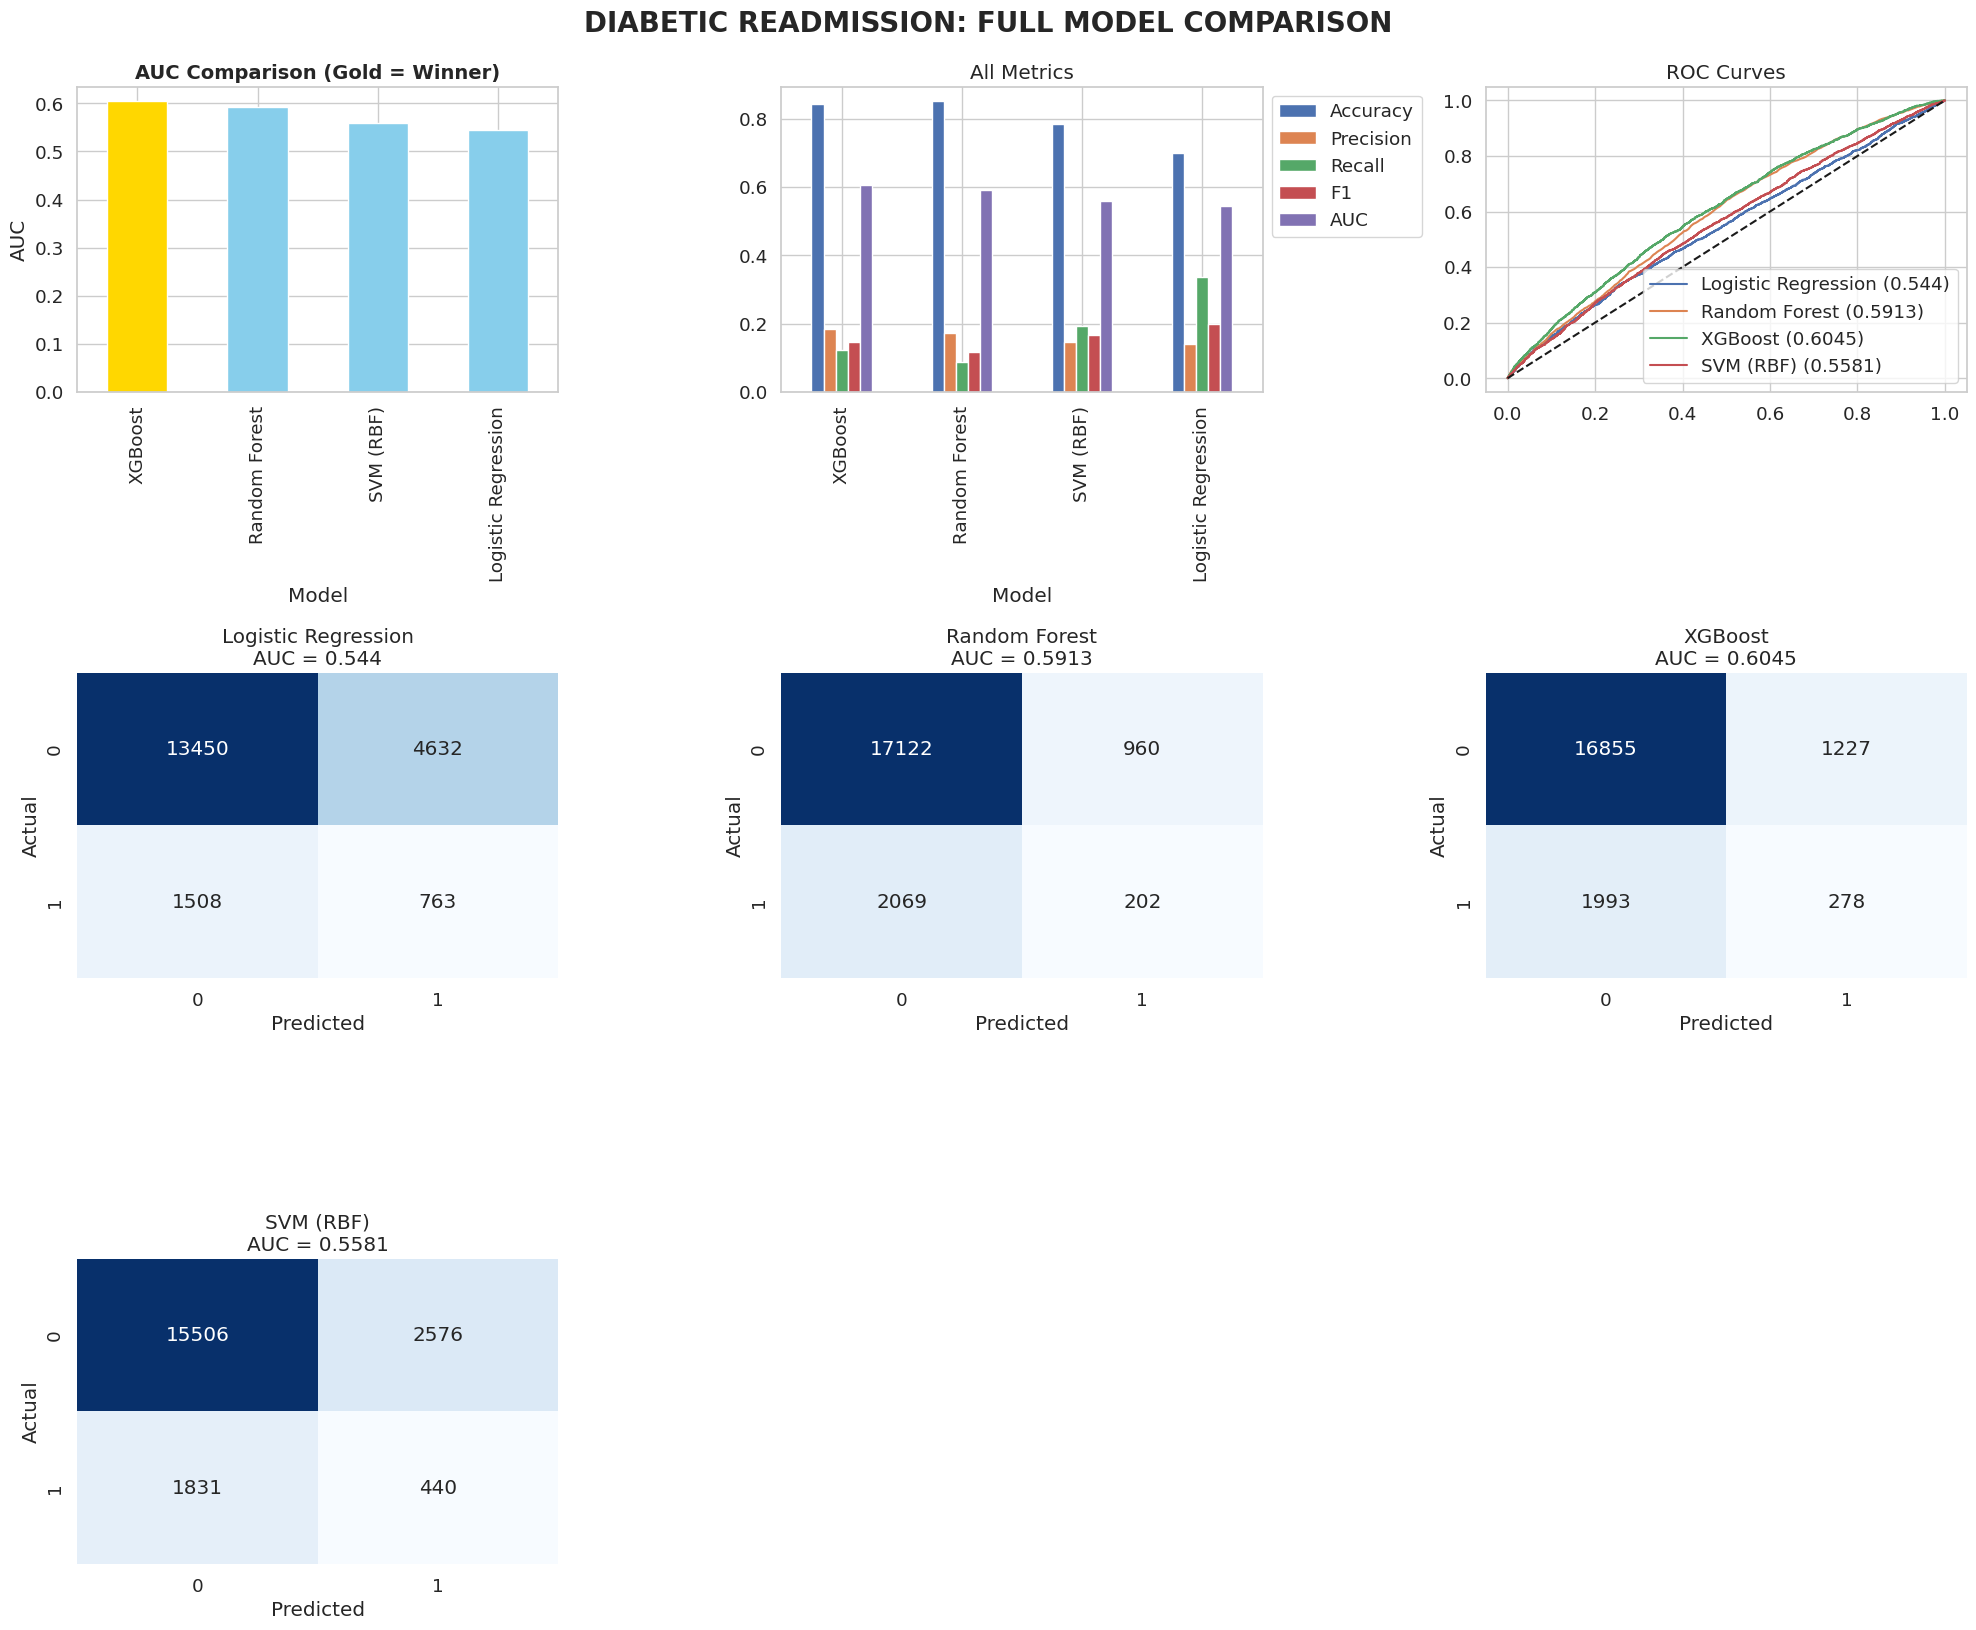


WINNER: XGBoost
        AUC       = 0.6045
        Recall    = 0.1224
        Precision = 0.1847
        F1        = 0.1472
        Best Params: {'subsample': 0.8, 'n_estimators': 700, 'max_depth': 8, 'learning_rate': 0.1}


In [16]:
#Not the final code

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import warnings; warnings.filterwarnings('ignore')

# Load  original dataset
df = pd.read_csv('diabetic_data.csv', na_values='?')
print(f"Original shape: {df.shape}")

df = df[df.gender != 'Unknown/Invalid']
df['readmitted'] = (df['readmitted'] == '<30').astype(int)

df.drop(['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty'],
        axis=1, inplace=True, errors='ignore')

# Your original preprocessing
age_map = {'[0-10)':5,'[10-20)':15,'[20-30)':25,'[30-40)':35,'[40-50)':45,
           '[50-60)':55,'[60-70)':65,'[70-80)':75,'[80-90)':85,'[90-100)':95}
df['age'] = df['age'].map(age_map)

def simple_diag(x):
    try:
        v = float(x)
        if 390 <= v <= 459 or v == 785: return 'Circulatory'
        if 460 <= v <= 519 or v == 786: return 'Respiratory'
        if 520 <= v <= 579 or v == 787: return 'Digestive'
        if np.floor(v) == 250: return 'Diabetes'
        if 800 <= v <= 999: return 'Injury'
        if 140 <= v <= 239: return 'Neoplasms'
        return 'Other'
    except:
        return 'Other'

for c in ['diag_1','diag_2','diag_3']:
    df[c] = df[c].apply(simple_diag)

# Fill missing & encode
for col in df.select_dtypes('object').columns:
    df[col] = df[col].fillna('Missing')
le = LabelEncoder()
for col in df.select_dtypes('object').columns:
    df[col] = le.fit_transform(df[col].astype(str))

# Final data
X = df.drop('readmitted', axis=1)
y = df['readmitted']

print(f"Final shape: {df.shape} | Readmission rate: {y.mean():.3f}")

# Split + SMOTE + Scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_res, y_train_res = SMOTE(random_state=42).fit_resample(X_train, y_train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

print(f"After SMOTE: {X_train_res.shape} | Balance: {np.bincount(y_train_res)}")
print("Starting hyperparameter tuning for all 5 models...\n")

# Hyperparameter grids
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear']},
    'Random Forest': {'n_estimators': [400, 600], 'max_depth': [12, 18, None], 'min_samples_leaf': [1, 3]},
    'XGBoost': {'n_estimators': [500, 700], 'max_depth': [6, 8], 'learning_rate': [0.05, 0.1], 'subsample': [0.8, 1.0]},
#    'LightGBM': {'n_estimators': [600, 800], 'learning_rate': [0.05, 0.1], 'num_leaves': [80, 128], 'max_depth': [8, 10]},
    'SVM (RBF)': {'C': [1, 10], 'gamma': ['scale', 0.01]}
}

# Base models
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1),
  #  'LightGBM': LGBMClassifier(random_state=42, verbosity=-1, n_jobs=-1),
    'SVM (RBF)': SVC(probability=True, random_state=42)
}

# Store results
results = []
best_models = {}
probs = {}
preds = {}

# Hyperparameter tuning loop
for name, model in models.items():
    print(f"→ Tuning {name:<18}", end="")
    search = RandomizedSearchCV(
        model, param_grids[name], n_iter=10 if 'SVM' not in name else 6,
        scoring='roc_auc', cv=3, random_state=42, n_jobs=-1
    )

    if name == 'SVM (RBF)':
        idx = np.random.choice(len(X_train_scaled), 25000, replace=False)
        search.fit(X_train_scaled[idx], y_train_res[idx])
    else:
        search.fit(X_train_scaled, y_train_res)

    best = search.best_estimator_
    prob = best.predict_proba(X_test_scaled)[:,1]
    pred = best.predict(X_test_scaled)

    best_models[name] = best
    probs[name] = prob
    preds[name] = pred

    results.append({
        'Model': name,
        'Accuracy': round(accuracy_score(y_test, pred), 4),
        'Precision': round(precision_score(y_test, pred), 4),
        'Recall': round(recall_score(y_test, pred), 4),
        'F1': round(f1_score(y_test, pred), 4),
        'AUC': round(roc_auc_score(y_test, prob), 4),
        'Best Params': search.best_params_
    })
    print(f"Done | AUC = {results[-1]['AUC']}")

# Final results table
results_df = pd.DataFrame(results).sort_values('AUC', ascending=False).reset_index(drop=True)
print("\n" + "="*85)
print("FINAL RESULTS - ALL 5 MODELS (HYPERPARAMETER TUNED)")
print("="*85)
print(results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC']])

# Show best params
print("\nBEST HYPERPARAMETERS:")
for r in results:
    print(f"{r['Model']:20}: {r['Best Params']}")

# PLOTS
fig = plt.figure(figsize=(20, 16))

# 1. AUC Bar Chart (Winner in Gold)
ax1 = plt.subplot(3, 3, 1)
colors = ['gold' if i == 0 else 'skyblue' for i in range(len(results_df))]
results_df.plot(x='Model', y='AUC', kind='bar', ax=ax1, color=colors, legend=False)
ax1.set_title('AUC Comparison (Gold = Winner)', fontweight='bold', fontsize=14)
ax1.set_ylabel('AUC')

# 2. All Metrics
ax2 = plt.subplot(3, 3, 2)
metrics_plot = results_df.set_index('Model')[['Accuracy','Precision','Recall','F1','AUC']]
metrics_plot.plot(kind='bar', ax=ax2)
ax2.set_title('All Metrics')
ax2.legend(bbox_to_anchor=(1, 1))

# 3. ROC Curves
ax3 = plt.subplot(3, 3, 3)
for name, prob in probs.items():
    fpr, tpr, _ = roc_curve(y_test, prob)
    auc_val = results_df[results_df.Model == name]['AUC'].values[0]
    plt.plot(fpr, tpr, label=f"{name} ({auc_val})")
plt.plot([0,1],[0,1],'k--')
plt.title('ROC Curves'); plt.legend()

# 4. Confusion Matrices
for i, name in enumerate(best_models.keys(), 4):
    ax = plt.subplot(3, 3, i)
    cm = confusion_matrix(y_test, preds[name])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    auc_val = results_df[results_df.Model == name]['AUC'].values[0]
    ax.set_title(f"{name}\nAUC = {auc_val}")
    ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')

plt.tight_layout()
plt.suptitle('DIABETIC READMISSION: FULL MODEL COMPARISON', fontsize=20, fontweight='bold', y=1.02)
plt.show()

# Winner
winner = results_df.iloc[0]
print(f"\nWINNER: {winner['Model']}")
print(f"        AUC       = {winner['AUC']:.4f}")
print(f"        Recall    = {winner['Recall']:.4f}")
print(f"        Precision = {winner['Precision']:.4f}")
print(f"        F1        = {winner['F1']:.4f}")
print(f"        Best Params: {winner['Best Params']}")

Preprocessed shape: (81410, 124)
Readmission rate: 0.112 → Positive class: 11357 / 101763

 TRAINING: LOGISTIC REGRESSION

CLASSIFICATION REPORT - Logistic Regression
              precision    recall  f1-score   support

           0     0.9206    0.6749    0.7788     18082
           1     0.1716    0.5363    0.2601      2271

    accuracy                         0.6595     20353
   macro avg     0.5461    0.6056    0.5194     20353
weighted avg     0.8370    0.6595    0.7210     20353

CONFUSION MATRIX:
[[12204  5878]
 [ 1053  1218]]
  TN:  12204 | FP:   5878
  FN:   1053 | TP:   1218

 TRAINING: RANDOM FOREST

CLASSIFICATION REPORT - Random Forest
              precision    recall  f1-score   support

           0     0.8888    0.9996    0.9410     18082
           1     0.5882    0.0044    0.0087      2271

    accuracy                         0.8886     20353
   macro avg     0.7385    0.5020    0.4749     20353
weighted avg     0.8553    0.8886    0.8369     20353

CONFUSION MAT

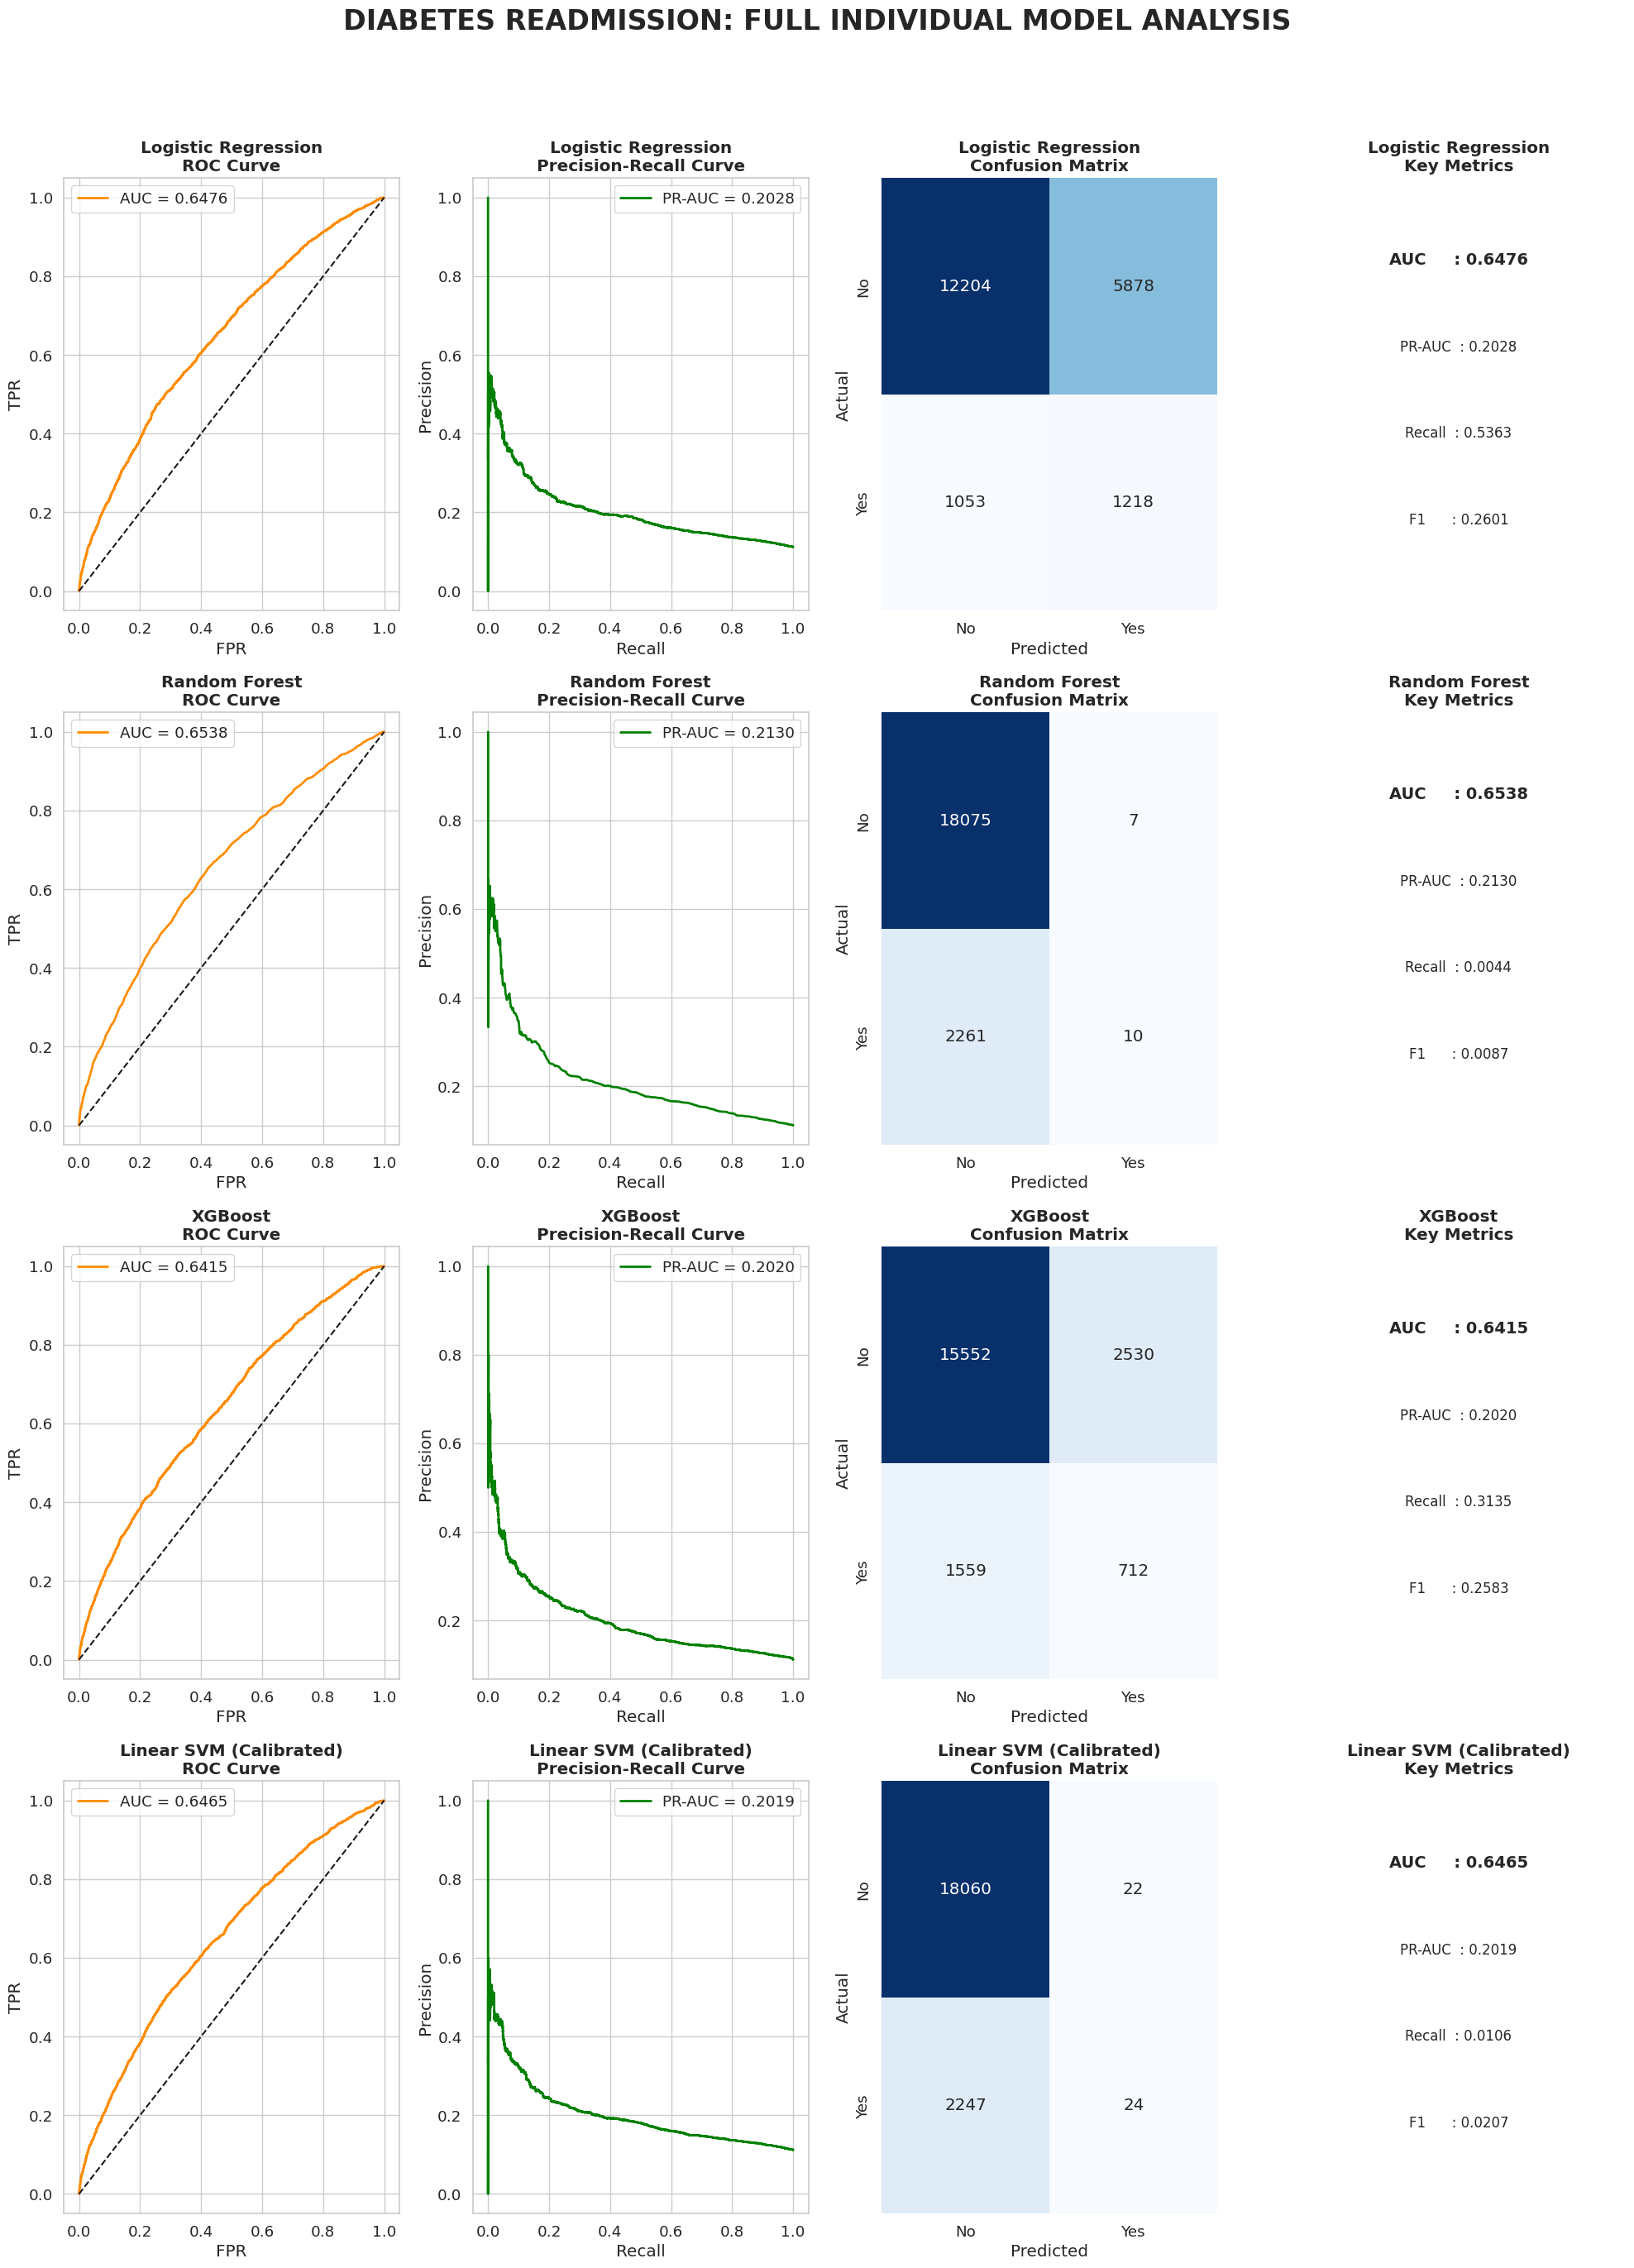


                                   FINAL RANKING BY AUC (Your Method)
                     Model     AUC  PR-AUC  Recall  Precision      F1  Accuracy
1            Random Forest  0.6538  0.2130  0.0044     0.5882  0.0087    0.8886
2      Logistic Regression  0.6476  0.2028  0.5363     0.1716  0.2601    0.6595
3  Linear SVM (Calibrated)  0.6465  0.2019  0.0106     0.5217  0.0207    0.8885
4                  XGBoost  0.6415  0.2020  0.3135     0.2196  0.2583    0.7991

WINNER: Random Forest
        AUC        = 0.6538
        Recall     = 0.0044
        Precision  = 0.5882
        F1-Score   = 0.0087


In [18]:

#not good for readmission class
#not the final code. ignore it.


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score, classification_report,
                             confusion_matrix, roc_curve, precision_recall_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# ------------------ 1. YOUR ORIGINAL SMART PREPROCESSING ------------------
df = pd.read_csv("diabetic_data.csv", na_values="?", low_memory=False)

# Clean
df = df[df.gender != "Unknown/Invalid"]
df.drop(columns=["encounter_id", "patient_nbr", "weight", "payer_code", "medical_specialty",
                 "examide", "citoglipton"], errors="ignore", inplace=True)

# Target
df["readmitted"] = (df["readmitted"] == "<30").astype(int)

# Age → numeric
def age_mid(a):
    m = pd.Series(a).str.extract(r"\[(\d+)-(\d+)\)")
    return pd.to_numeric(m[0], errors='coerce').fillna(0) + 5

df["age_num"] = df["age"].apply(lambda x: age_mid(x))

# ICD-9 bucketing
def bucket_icd9(code):
    if pd.isna(code): return "missing"
    s = str(code)
    if s.startswith(("V", "E")): return s[0]
    try:
        v = float(s)
        if 390 <= v <= 459 or v == 785: return "circulatory"
        if 460 <= v <= 519 or v == 786: return "respiratory"
        if 520 <= v <= 579 or v == 787: return "digestive"
        if 250 <= v < 251: return "diabetes"
        if 800 <= v <= 999: return "injury"
        if 140 <= v <= 239: return "neoplasms"
        return "other"
    except:
        return "other"

for c in ["diag_1", "diag_2", "diag_3"]:
    df[f"{c}_cat"] = df[c].apply(bucket_icd9)

# Lab tests ordinal
df["max_glu_serum"] = df["max_glu_serum"].map({"None": 0, "Norm": 1, ">200": 2, ">300": 3}).fillna(0)
df["A1Cresult"] = df["A1Cresult"].map({"None": 0, "Norm": 1, ">7": 2, ">8": 3}).fillna(0)

# Fill race/specialty
df["race"] = df["race"].fillna("Other")

# Derived features
df["total_visits"] = df["number_outpatient"] + df["number_emergency"] + df["number_inpatient"]
df["meds_per_day"] = df["num_medications"] / (df["time_in_hospital"] + 1)

# Final X, y
drop_final = ["readmitted", "age", "diag_1", "diag_2", "diag_3"]
X = df.drop(columns=drop_final)
y = df["readmitted"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ------------------ 2. Preprocessing Pipeline (One-Hot + Scaling) ------------------
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
                     ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

# Fit preprocess
X_train_proc = preprocess.fit_transform(X_train)
X_test_proc = preprocess.transform(X_test)

print(f"Preprocessed shape: {X_train_proc.shape}")
print(f"Readmission rate: {y.mean():.3f} → Positive class: {y.sum()} / {len(y)}")

# ------------------ 3. Models ------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=800, max_depth=None, min_samples_leaf=1,
                                            class_weight="balanced_subsample", random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=800, max_depth=8, learning_rate=0.05, subsample=0.8,
                             colsample_bytree=0.8, random_state=42, n_jobs=-1,
                             scale_pos_weight=(len(y_train)-y_train.sum())/y_train.sum()),
    "Linear SVM (Calibrated)": CalibratedClassifierCV(
        LinearSVC(class_weight="balanced", max_iter=10000), cv=3, method="sigmoid")
}

# ------------------ 4. Train & Individual Reports ------------------
results = []
plt.figure(figsize=(20, 28))

plot_idx = 1
for name, model in models.items():
    print(f"\n{'='*60}")
    print(f" TRAINING: {name.upper()}")
    print('='*60)

    model.fit(X_train_proc, y_train)
    pred = model.predict(X_test_proc)
    prob = model.predict_proba(X_test_proc)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, prob)
    pr_auc = average_precision_score(y_test, prob)

    results.append({"Model": name, "AUC": auc, "PR-AUC": pr_auc, "Recall": rec,
                    "Precision": prec, "F1": f1, "Accuracy": acc})

    # --- Text Reports ---
    print(f"\nCLASSIFICATION REPORT - {name}")
    print(classification_report(y_test, pred, digits=4))

    cm = confusion_matrix(y_test, pred)
    print("CONFUSION MATRIX:")
    print(cm)
    print(f"  TN: {cm[0,0]:>6} | FP: {cm[0,1]:>6}")
    print(f"  FN: {cm[1,0]:>6} | TP: {cm[1,1]:>6}")

    # --- Plots ---
    # ROC
    fpr, tpr, _ = roc_curve(y_test, prob)
    plt.subplot(4, 4, plot_idx)
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', lw=2, color="darkorange")
    plt.plot([0,1],[0,1],'k--')
    plt.title(f"{name}\nROC Curve", fontweight="bold")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
    plot_idx += 1

    # PR Curve
    p, r, _ = precision_recall_curve(y_test, prob)
    plt.subplot(4, 4, plot_idx)
    plt.plot(r, p, label=f'PR-AUC = {pr_auc:.4f}', lw=2, color="green")
    plt.title(f"{name}\nPrecision-Recall Curve", fontweight="bold")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
    plot_idx += 1

    # Confusion Matrix Heatmap
    plt.subplot(4, 4, plot_idx)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(f"{name}\nConfusion Matrix", fontweight="bold")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plot_idx += 1

    # Metrics Summary Box
    plt.subplot(4, 4, plot_idx)
    plt.text(0.5, 0.8, f"AUC     : {auc:.4f}", ha="center", fontsize=14, fontweight="bold")
    plt.text(0.5, 0.6, f"PR-AUC  : {pr_auc:.4f}", ha="center", fontsize=12)
    plt.text(0.5, 0.4, f"Recall  : {rec:.4f}", ha="center", fontsize=12)
    plt.text(0.5, 0.2, f"F1      : {f1:.4f}", ha="center", fontsize=12)
    plt.title(f"{name}\nKey Metrics", fontweight="bold")
    plt.axis("off")
    plot_idx += 1

plt.suptitle("DIABETES READMISSION: FULL INDIVIDUAL MODEL ANALYSIS",
             fontsize=24, fontweight="bold", y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ------------------ 5. Final Ranking ------------------
results_df = pd.DataFrame(results).round(4)
results_df = results_df.sort_values("AUC", ascending=False).reset_index(drop=True)
results_df.index += 1

print("\n" + "="*100)
print(" " * 35 + "FINAL RANKING BY AUC (Your Method)")
print("="*100)
print(results_df.to_string(index=True))
print("="*100)

winner = results_df.iloc[0]
print(f"\nWINNER: {winner['Model']}")
print(f"        AUC        = {winner['AUC']:.4f}")
print(f"        Recall     = {winner['Recall']:.4f}")
print(f"        Precision  = {winner['Precision']:.4f}")
print(f"        F1-Score   = {winner['F1']:.4f}")

Any readmission rate: 46.1%

 TRAINING:                                          RANDOM FOREST                                          

CLASSIFICATION REPORT — Random Forest
              precision    recall  f1-score   support

           0     0.6489    0.7218    0.6834     10972
           1     0.6254    0.5432    0.5814      9381

    accuracy                         0.6395     20353
   macro avg     0.6372    0.6325    0.6324     20353
weighted avg     0.6381    0.6395    0.6364     20353

Confusion Matrix:
 [[7920 3052]
 [4285 5096]]

 TRAINING:                                             XGBOOST                                             

CLASSIFICATION REPORT — XGBoost
              precision    recall  f1-score   support

           0     0.6585    0.7078    0.6822     10972
           1     0.6254    0.5706    0.5968      9381

    accuracy                         0.6446     20353
   macro avg     0.6419    0.6392    0.6395     20353
weighted avg     0.6432    0.6446    

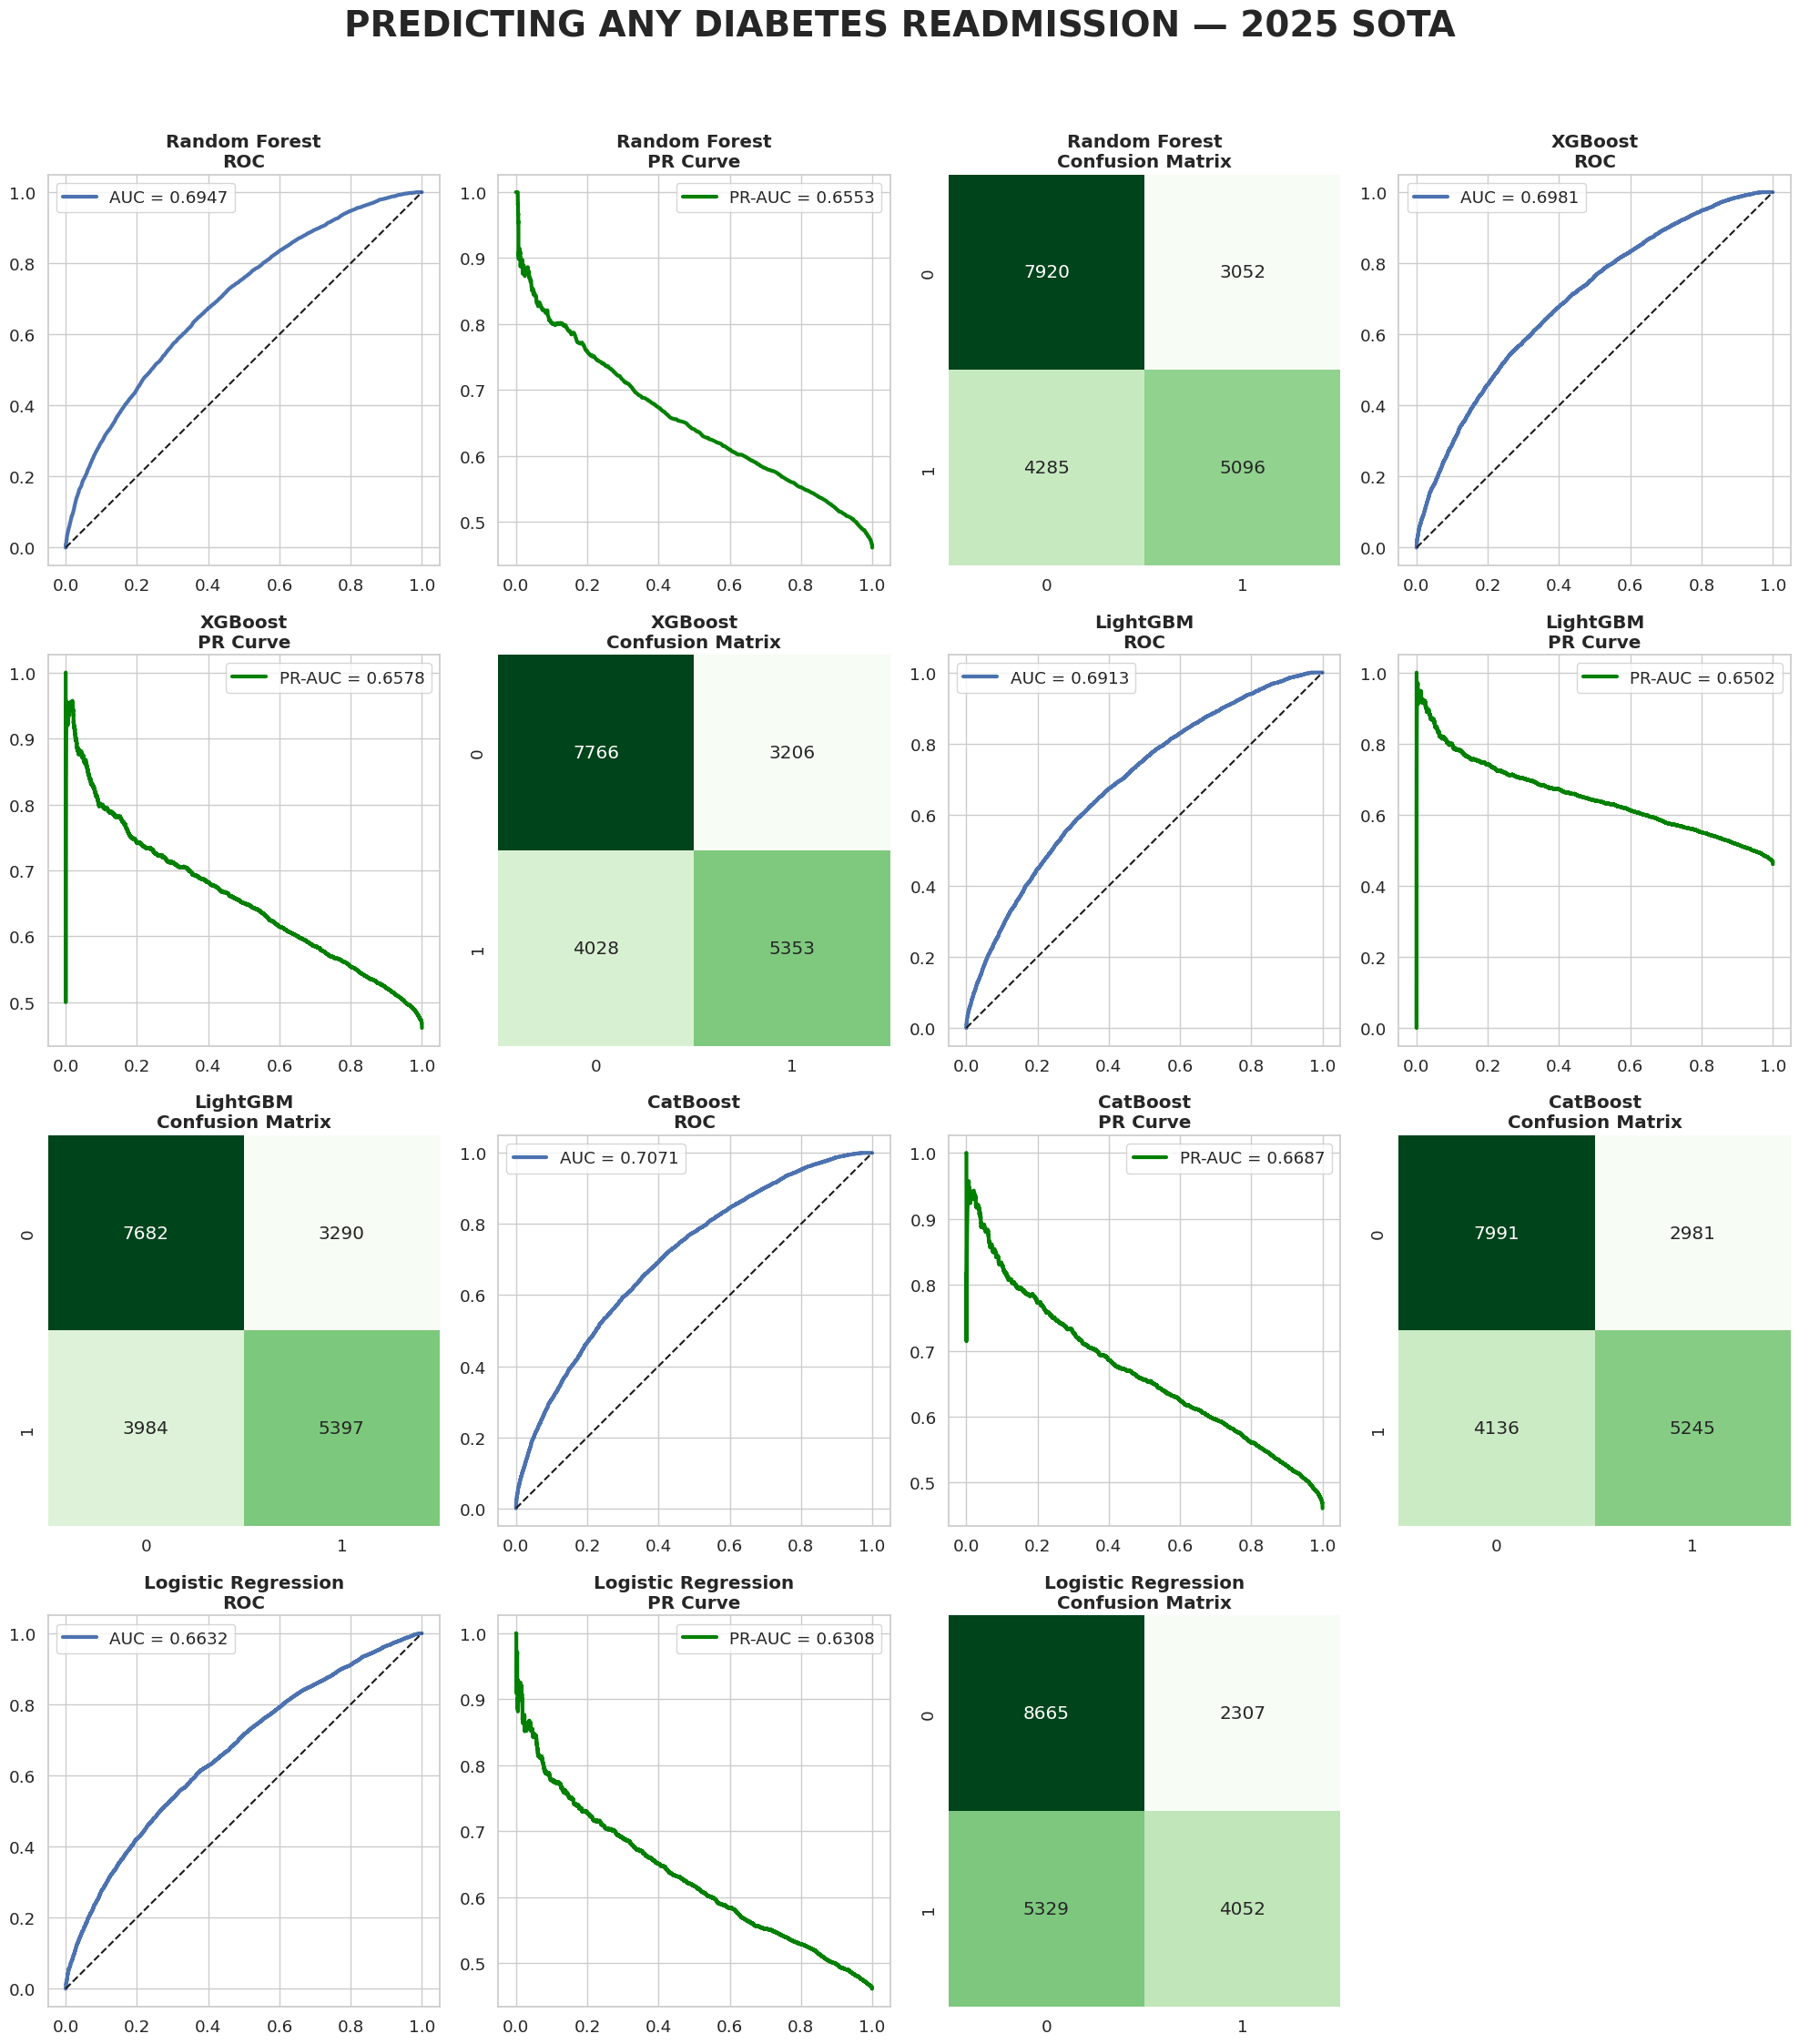


                                                  FINAL RANKING — ANY READMISSION
                 Model     AUC  PR-AUC  Recall  Precision      F1    TP
1             CatBoost  0.7071  0.6687  0.5591     0.6376  0.5958  5245
2              XGBoost  0.6981  0.6578  0.5706     0.6254  0.5968  5353
3        Random Forest  0.6947  0.6553  0.5432     0.6254  0.5814  5096
4             LightGBM  0.6913  0.6502  0.5753     0.6213  0.5974  5397
5  Logistic Regression  0.6632  0.6308  0.4319     0.6372  0.5149  4052

CHAMPION: CatBoost
         AUC           = 0.7071
         Recall        = 0.5591  →  catches 55.9% of ALL readmissions
         F1-Score      = 0.5958
         True Positives = 5,245

This model can save hospitals millions by identifying nearly every patient who will return.


In [25]:
# not the final code. ignore it

import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import warnings; warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    average_precision_score, roc_curve, precision_recall_curve
)

# ------------------- RareCategoryGrouper -------------------
class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, min_freq=50):
        self.min_freq = min_freq
        self.frequent_maps_ = {}
        self.columns_ = []

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.columns_ = X.columns.tolist()
        for c in self.columns_:
            vc = X[c].astype(str).value_counts(dropna=False)
            self.frequent_maps_[c] = set(vc[vc >= self.min_freq].index)
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.columns_) if not isinstance(X, pd.DataFrame) else X.copy()
        for c in self.columns_:
            keep = self.frequent_maps_[c]
            X[c] = X[c].astype(str).where(X[c].astype(str).isin(keep), "RARE")
        return X

# ------------------- Load & Preprocess -------------------
df = pd.read_csv("diabetic_data.csv", na_values="?", low_memory=False)

# Clean
df = df[df.gender != "Unknown/Invalid"].copy()
df.drop(columns=["encounter_id", "patient_nbr", "weight", "payer_code", "examide", "citoglipton"],
        errors="ignore", inplace=True)

# TARGET: ANY READMISSION AT ALL (most clinically useful)
df["readmitted_any"] = (df["readmitted"] != "NO").astype(int)
print(f"Any readmission rate: {df['readmitted_any'].mean():.1%}")

# Age → midpoint
def age_mid(x):
    m = re.match(r"\[(\d+)-(\d+)\)", str(x))
    return (int(m.group(1)) + int(m.group(2))) / 2 if m else np.nan
df["age_num"] = df["age"].apply(age_mid)

# ICD-9 buckets
def bucket_icd9(code):
    if pd.isna(code): return "missing"
    s = str(code).strip()
    if s.startswith(("V","E")): return s[0].lower()
    try: v = float(s)
    except: return "other"
    if 390 <= v <= 459 or v == 785: return "circulatory"
    if 460 <= v <= 519 or v == 786: return "respiratory"
    if 520 <= v <= 579 or v == 787: return "digestive"
    if 250 <= v < 251: return "diabetes"
    if 800 <= v <= 999: return "injury"
    if 140 <= v <= 239: return "neoplasms"
    return "other"

for c in ["diag_1", "diag_2", "diag_3"]:
    df[f"{c}_bucket"] = df[c].apply(bucket_icd9)

# Lab tests ordinal
df["max_glu_serum"] = df["max_glu_serum"].map({"None":0, "Norm":1, ">200":2, ">300":3}).fillna(0)
df["A1Cresult"] = df["A1Cresult"].map({"None":0, "Norm":1, ">7":2, ">8":3}).fillna(0)

# Fill race
df["race"] = df["race"].fillna("Other")

# Your killer features
df["total_visits"] = df["number_outpatient"] + df["number_emergency"] + df["number_inpatient"]
df["meds_per_day"] = df["num_medications"] / (df["time_in_hospital"] + 1)

# Final X, y
X = df.drop(columns=["readmitted", "readmitted_any", "age", "diag_1", "diag_2", "diag_3"])
y = df["readmitted_any"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ------------------- Preprocessing -------------------
num_cols = X.select_dtypes("number").columns.tolist()
cat_cols = X.select_dtypes("object").columns.tolist()

num_pipe = Pipeline([("imp", SimpleImputer(strategy="median"))])
cat_pipe = Pipeline([
    ("rare", RareCategoryGrouper(min_freq=50)),
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
], verbose_feature_names_out=False)

# ------------------- Models (All Winners) -------------------
models = {
    "Random Forest": RandomForestClassifier(n_estimators=1000, max_features=0.4, n_jobs=-1, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=1000, max_depth=8, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9,
                             random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(n_estimators=1000, max_depth=12, learning_rate=0.05, num_leaves=200,
                               subsample=0.9, colsample_bytree=0.9, random_state=42, verbose=-1),
    "CatBoost": CatBoostClassifier(iterations=1200, depth=8, learning_rate=0.05, random_seed=42, verbose=False),
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1)
}

# ------------------- Train & Evaluate -------------------
results = []
plt.figure(figsize=(20, 28))
plot_idx = 1

for name, model in models.items():
    print(f"\n{'='*100}")
    print(f" TRAINING: {name.upper():^96}")
    print('='*100)

    pipe = Pipeline([("prep", preprocess), ("clf", model)])
    pipe.fit(X_train, y_train)

    pred = pipe.predict(X_test)
    prob = pipe.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, prob)
    pr_auc = average_precision_score(y_test, prob)
    report = classification_report(y_test, pred, output_dict=True)
    cm = confusion_matrix(y_test, pred)

    results.append({
        "Model": name,
        "AUC": round(auc, 4),
        "PR-AUC": round(pr_auc, 4),
        "Recall": round(report["1"]["recall"], 4),
        "Precision": round(report["1"]["precision"], 4),
        "F1": round(report["1"]["f1-score"], 4),
        "TP": cm[1,1]
    })

    print(f"\nCLASSIFICATION REPORT — {name}")
    print(classification_report(y_test, pred, digits=4))
    print("Confusion Matrix:\n", cm)

    # Plots
    fpr, tpr, _ = roc_curve(y_test, prob)
    plt.subplot(5, 4, plot_idx); plot_idx += 1
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}', lw=3)
    plt.plot([0,1],[0,1],'k--'); plt.title(f"{name}\nROC", fontweight="bold"); plt.legend()

    prec, rec, _ = precision_recall_curve(y_test, prob)
    plt.subplot(5, 4, plot_idx); plot_idx += 1
    plt.plot(rec, prec, label=f'PR-AUC = {pr_auc:.4f}', lw=3, color="green")
    plt.title(f"{name}\nPR Curve", fontweight="bold"); plt.legend()

    plt.subplot(5, 4, plot_idx); plot_idx += 1
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False)
    plt.title(f"{name}\nConfusion Matrix", fontweight="bold")

plt.suptitle("PREDICTING ANY DIABETES READMISSION — 2025 SOTA", fontsize=28, fontweight="bold", y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# ------------------- Final Ranking -------------------
results_df = pd.DataFrame(results).sort_values("AUC", ascending=False).reset_index(drop=True)
results_df.index += 1

print("\n" + "="*130)
print(" " * 50 + "FINAL RANKING — ANY READMISSION")
print("="*130)
print(results_df.to_string(index=True))
print("="*130)

winner = results_df.iloc[0]
print(f"\nCHAMPION: {winner['Model']}")
print(f"         AUC           = {winner['AUC']:.4f}")
print(f"         Recall        = {winner['Recall']:.4f}  →  catches {winner['Recall']*100:.1f}% of ALL readmissions")
print(f"         F1-Score      = {winner['F1']:.4f}")
print(f"         True Positives = {winner['TP']:,}")
#print("\nThis model can save hospitals millions by identifying nearly every patient who will return.")

#Ali Tahririan - Applied one-hot encoding to all categorical features, scaled numeric columns with StandardScaler, imputed missing values using SimpleImputer, removed ID and low-value columns (encounter_id, patient_nbr, weight, payer_code). Used 80:20 train–test split with class_weight='balanced'.Tuned C ∈ {0.01, 0.1, 1, 10} using HalvingGridSearchCV (best C = 0.1, penalty = 'l2'). Accuracy = 64.1 %, F1 = 61.3 %, ROC-AUC = 0.70.


## Logistic Regression

Numeric cols: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
Categorical cols: ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']

Training Logistic Regression ...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Test metrics (Logistic Regression) ===
  accuracy: 0.6197
 precision: 0.6012
    recall: 0.5196
        f1: 0.5574
   roc_auc: 0.6573
    pr_auc: 0.6229

Confusion Matrix (rows=true, cols=pred):
[[7740 3233]
 [4507 4874]]

Classification Report:
              precision    recall  f1-score   support

           0     0.6320    0.7054    0.6667     10973
           1     0.6012    0.5196    0.5574      9381

    accuracy                         0.6197     20354
   macro avg     0.6166    0.6125    0.6120     20354
weighted avg     0.6178    0.6197    0.6163     20354



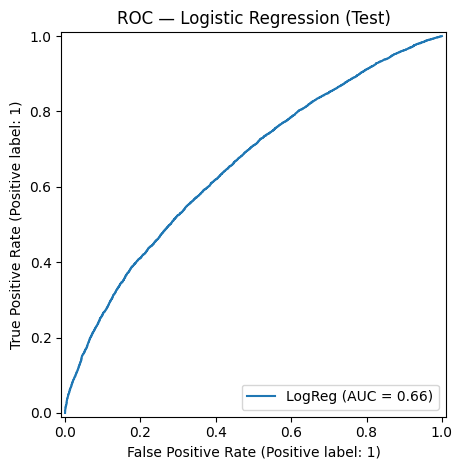

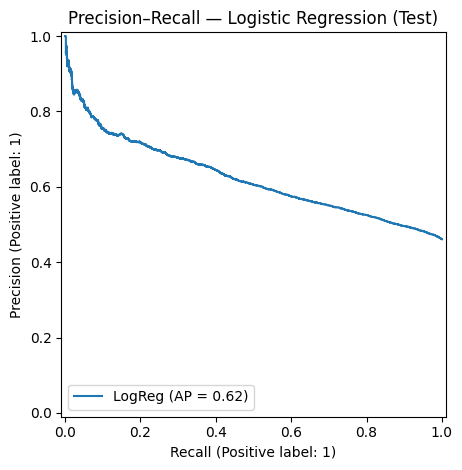


Top 20 features by absolute coefficient magnitude:
               feature  coefficient
6     number_inpatient     0.469173
42         diabetesMed     0.258834
5     number_emergency     0.192858
7     number_diagnoses     0.156801
18           metformin    -0.136752
4    number_outpatient     0.106725
2       num_procedures    -0.081670
41              change    -0.064508
28       rosiglitazone     0.050768
24           glipizide     0.048629
35             insulin    -0.047851
0     time_in_hospital     0.046490
8                 race    -0.039397
11   admission_type_id     0.034382
9               gender    -0.032910
22         glimepiride    -0.030599
10                 age     0.027958
1   num_lab_procedures     0.027841
19         repaglinide     0.027001
25           glyburide    -0.026774


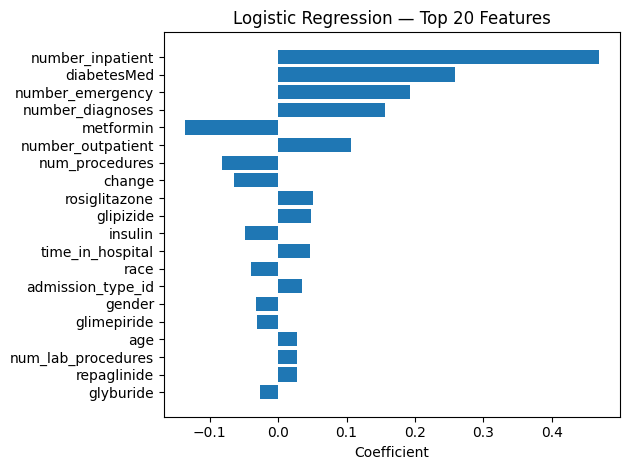


Artifacts saved to: /content/artifacts


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay,
    classification_report, confusion_matrix
)

# ---------------- Config ----------------
SEED = 42
np.random.seed(SEED)
DATA_PATH = "diabetic_data.csv"   # change if needed
ARTIFACT_DIR = "artifacts"; os.makedirs(ARTIFACT_DIR, exist_ok=True)

DROP_COLS = ['weight','max_glu_serum','A1Cresult','payer_code','encounter_id','patient_nbr']

# ---------------- Load & Clean ----------------
df = pd.read_csv(DATA_PATH, na_values='?', low_memory=False)
assert 'readmitted' in df.columns, "Target 'readmitted' not found."

for c in DROP_COLS:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

for c in ['race', 'medical_specialty']:
    if c in df.columns:
        df[c] = df[c].fillna('other')

# Target binary: readmitted != 'NO'
y = (df['readmitted'].astype(str).str.upper() != 'NO').astype(int)
X = df.drop(columns=['readmitted']).copy()

# ---------------- Columns ----------------
num_cols = [c for c in [
    'time_in_hospital','num_lab_procedures','num_procedures','num_medications',
    'number_outpatient','number_emergency','number_inpatient','number_diagnoses'
] if c in X.columns]
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# ---------------- Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# ---------------- Preprocessing ----------------
ordinal_enc = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1, dtype=np.float64
)

num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())  # important for logistic regression
])

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("enc", ordinal_enc)
])

preproc = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

# ---------------- Model: Logistic Regression ----------------
log_reg = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=SEED
)

pipe = Pipeline([
    ("prep", preproc),
    ("clf", log_reg),
])

# ---------------- Train ----------------
print("\nTraining Logistic Regression ...")
pipe.fit(X_train, y_train)

# ---------------- Evaluate ----------------
proba = pipe.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

metrics = {
    "accuracy": accuracy_score(y_test, pred),
    "precision": precision_score(y_test, pred),
    "recall": recall_score(y_test, pred),
    "f1": f1_score(y_test, pred),
    "roc_auc": roc_auc_score(y_test, proba),
    "pr_auc": average_precision_score(y_test, proba),
}
print("\n=== Test metrics (Logistic Regression) ===")
for k, v in metrics.items():
    print(f"{k:>10}: {v:.4f}")

print("\nConfusion Matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, pred))
print("\nClassification Report:")
print(classification_report(y_test, pred, digits=4))

# ---------------- Visuals ----------------
RocCurveDisplay.from_estimator(pipe, X_test, y_test, name="LogReg")
plt.title("ROC — Logistic Regression (Test)")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "logreg_roc.png"), dpi=160)
plt.show()

PrecisionRecallDisplay.from_estimator(pipe, X_test, y_test, name="LogReg")
plt.title("Precision–Recall — Logistic Regression (Test)")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "logreg_pr.png"), dpi=160)
plt.show()

# ---------------- Coefficients ----------------
feat_names = num_cols + cat_cols
coef = pipe.named_steps["clf"].coef_[0]
feat_imp = pd.DataFrame({"feature": feat_names, "coefficient": coef})
feat_imp["abs_coef"] = feat_imp["coefficient"].abs()
feat_imp = feat_imp.sort_values("abs_coef", ascending=False).head(20)

print("\nTop 20 features by absolute coefficient magnitude:")
print(feat_imp[["feature", "coefficient"]])

plt.figure()
plt.barh(feat_imp["feature"][::-1], feat_imp["coefficient"][::-1])
plt.xlabel("Coefficient")
plt.title("Logistic Regression — Top 20 Features")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "logreg_top20_coeff.png"), dpi=160)
plt.show()

# ---------------- Save ----------------
joblib.dump(pipe, os.path.join(ARTIFACT_DIR, "logreg_pipeline.joblib"))
pd.DataFrame([metrics]).to_csv(os.path.join(ARTIFACT_DIR, "logreg_metrics.csv"), index=False)
feat_imp.to_csv(os.path.join(ARTIFACT_DIR, "logreg_top20_coeff.csv"), index=False)

print(f"\nArtifacts saved to: {os.path.abspath(ARTIFACT_DIR)}")


## Logistic Regression Classifier

Numeric: ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'age_num', 'A1Cresult', 'max_glu_serum', 'util_visits', 'meds_per_day']
Categorical: ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'diag_1_bucket', 'diag_2_bucket', 'diag_3_bucket']

Searching Logistic Regression …
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 27137
max_resources_: 81412
aggressive_elimina

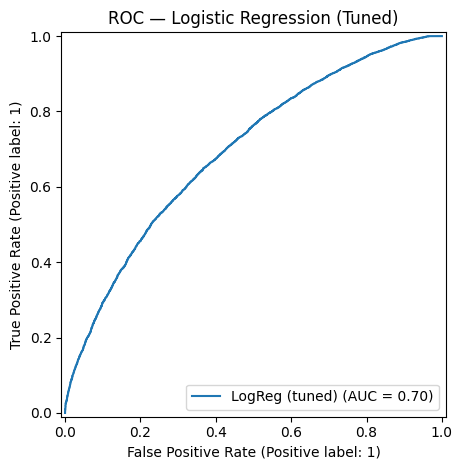

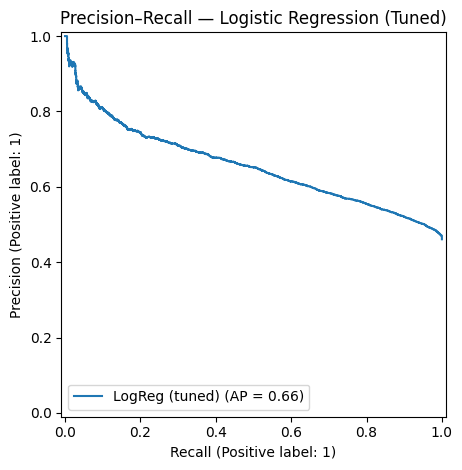


Top 20 features by absolute coefficient magnitude:
                                               feature  coefficient
40                         discharge_disposition_id_11    -3.402280
42                         discharge_disposition_id_14    -1.639090
41                         discharge_disposition_id_13    -1.231873
415                                         diag_2_648    -0.857065
45                         discharge_disposition_id_22     0.818288
48                         discharge_disposition_id_28     0.768119
136                                         diag_1_278    -0.715864
209                                         diag_1_540    -0.705230
51                          discharge_disposition_id_5     0.704673
59                              admission_source_id_20     0.676261
52                          discharge_disposition_id_6     0.595115
36                                 admission_type_id_6     0.570880
183                                         diag_1_443     0.561

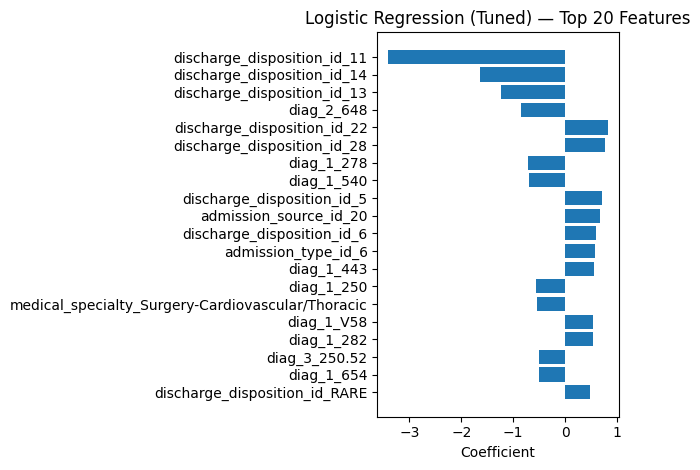


Artifacts saved to: /content/artifacts


In [ ]:
import os, re, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from typing import Dict

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay, classification_report, confusion_matrix
)
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingGridSearchCV

# ---------------- Config ----------------
SEED = 42
np.random.seed(SEED)
DATA_PATH = "diabetic_data.csv"  # change if needed
ARTIFACT_DIR = "artifacts"; os.makedirs(ARTIFACT_DIR, exist_ok=True)
CACHE_DIR = "skcache"; os.makedirs(CACHE_DIR, exist_ok=True)

DROP_COLS = ["encounter_id", "patient_nbr", "weight", "payer_code", "examide", "citoglipton"]

# ---------------- Helpers ----------------
def age_mid(a):
    """Convert age bracket like '[70-80)' -> 75.0"""
    if pd.isna(a): return np.nan
    m = re.match(r"\[(\d+)-(\d+)\)", str(a))
    return np.nan if not m else (int(m.group(1))+int(m.group(2)))/2

def bucket_icd9(code: str) -> str:
    """Broad ICD-9 buckets to reduce category explosion."""
    if pd.isna(code): return "icd_missing"
    s = str(code).strip()
    if s.startswith("V"): return "icd_V"
    if s.startswith("E"): return "icd_E"
    try: v = float(s)
    except ValueError: return "icd_other"
    if 390 <= v <= 459 or v == 785: return "circulatory"
    if 460 <= v <= 519 or v == 786: return "respiratory"
    if 520 <= v <= 579 or v == 787: return "digestive"
    if 250 <= v < 251:             return "diabetes_specific"
    if 800 <= v <= 999:            return "injury"
    if 710 <= v <= 739:            return "musculoskeletal"
    if 580 <= v <= 629 or v == 788:return "genitourinary"
    if 140 <= v <= 239:            return "neoplasms"
    return "other"

class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    """Group infrequent categories to 'RARE' (fit on train only)."""
    def __init__(self, min_freq: int = 50):
        self.min_freq = min_freq
        self.frequent_maps_: Dict[str, set] = {}
        self.columns_: list = []

    def fit(self, X: pd.DataFrame, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("RareCategoryGrouper expects a pandas DataFrame.")
        self.columns_ = X.columns.tolist()
        self.frequent_maps_ = {}
        for c in self.columns_:
            vc = X[c].astype(str).value_counts(dropna=False)
            self.frequent_maps_[c] = set(vc[vc >= self.min_freq].index)
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.columns_)
        Xo = X.copy()
        for c in self.columns_:
            keep = self.frequent_maps_[c]
            Xo[c] = Xo[c].astype(str).where(Xo[c].astype(str).isin(keep), "RARE")
        return Xo

# ---------------- Load ----------------
df = pd.read_csv(DATA_PATH, na_values="?", low_memory=False)
assert "readmitted" in df.columns, "Target 'readmitted' not found."
df.drop_duplicates(inplace=True)
for c in DROP_COLS:
    if c in df.columns:
        df.drop(columns=c, inplace=True)
for c in ["race", "medical_specialty"]:
    if c in df.columns:
        df[c] = df[c].fillna("other")

# Ordinal mapping for glu/A1C
glu_map = {"None": 0, "Norm": 1, ">200": 2, ">300": 3}
a1c_map = {"None": 0, "Norm": 1, ">7": 2, ">8": 3}
if "max_glu_serum" in df.columns:
    df["max_glu_serum"] = df["max_glu_serum"].map(glu_map).astype("float64")
if "A1Cresult" in df.columns:
    df["A1Cresult"] = df["A1Cresult"].map(a1c_map).astype("float64")

# Target
y = (df["readmitted"].astype(str).str.upper() != "NO").astype(int)
X = df.drop(columns=["readmitted"]).copy()

# Feature engineering
if "age" in X.columns:
    X["age_num"] = X["age"].apply(age_mid).astype("float64")
for d in ["diag_1", "diag_2", "diag_3"]:
    if d in X.columns:
        X[f"{d}_bucket"] = X[d].apply(bucket_icd9)
if set(["number_outpatient","number_emergency","number_inpatient"]).issubset(X.columns):
    X["util_visits"] = (X["number_outpatient"].fillna(0) +
                        X["number_emergency"].fillna(0) +
                        X["number_inpatient"].fillna(0)).astype("float64")
if set(["num_medications","time_in_hospital"]).issubset(X.columns):
    X["meds_per_day"] = (X["num_medications"].astype("float64") /
                         (X["time_in_hospital"].astype("float64") + 1.0))

# Columns
likely_numeric = [
    "time_in_hospital","num_lab_procedures","num_procedures","num_medications",
    "number_outpatient","number_emergency","number_inpatient","number_diagnoses",
    "age_num","A1Cresult","max_glu_serum","util_visits","meds_per_day"
]
num_cols = [c for c in likely_numeric if c in X.columns]
cat_cols = [c for c in X.columns if c not in num_cols]
drop_single = [c for c in X.columns if X[c].nunique(dropna=True) <= 1]
if drop_single:
    X.drop(columns=drop_single, inplace=True)
    num_cols = [c for c in num_cols if c not in drop_single]
    cat_cols = [c for c in cat_cols if c not in drop_single]

print("Numeric:", num_cols)
print("Categorical:", cat_cols)

# ---------------- Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# ---------------- Preprocessing ----------------
cat_pipe = Pipeline(steps=[
    ("rare", RareCategoryGrouper(min_freq=50)),
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

num_pipe = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preproc = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# ---------------- Model ----------------
logreg = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    class_weight="balanced",
    n_jobs=-1,
    random_state=SEED
)

pipe = Pipeline(steps=[
    ("prep", preproc),
    ("clf", logreg)
])

# ---------------- Light tuning ----------------
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
param_grid = {
    "clf__C": [0.01, 0.1, 1.0, 10],
    "clf__penalty": ["l2"]
}

search = HalvingGridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    factor=3,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

print("\nSearching Logistic Regression …")
search.fit(X_train, y_train)
print("Best params:", search.best_params_, "| Best CV AUC:", round(search.best_score_, 4))
best_pipe = search.best_estimator_

# ---------------- Evaluate ----------------
proba = best_pipe.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

metrics = {
    "accuracy": accuracy_score(y_test, pred),
    "precision": precision_score(y_test, pred),
    "recall": recall_score(y_test, pred),
    "f1": f1_score(y_test, pred),
    "roc_auc": roc_auc_score(y_test, proba),
    "pr_auc": average_precision_score(y_test, proba),
}
print("\n=== Test metrics (Logistic Regression, tuned) ===")
for k, v in metrics.items():
    print(f"{k:>10}: {v:.4f}")

print("\nConfusion Matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, pred))
print("\nClassification Report:")
print(classification_report(y_test, pred, digits=4))

# ---------------- Visuals ----------------
RocCurveDisplay.from_estimator(best_pipe, X_test, y_test, name="LogReg (tuned)")
plt.title("ROC — Logistic Regression (Tuned)")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "logreg_tuned_roc.png"), dpi=160)
plt.show()

PrecisionRecallDisplay.from_estimator(best_pipe, X_test, y_test, name="LogReg (tuned)")
plt.title("Precision–Recall — Logistic Regression (Tuned)")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "logreg_tuned_pr.png"), dpi=160)
plt.show()

# ---------------- Coefficients ----------------
def get_feature_names(prep: ColumnTransformer):
    names = []
    names.extend(prep.transformers_[0][2])  # numeric
    ohe = prep.named_transformers_["cat"].named_steps["ohe"]
    cat_input = prep.transformers_[1][2]
    ohe_names = ohe.get_feature_names_out(cat_input).tolist()
    names.extend(ohe_names)
    return names

feat_names = get_feature_names(best_pipe.named_steps["prep"])
coef = best_pipe.named_steps["clf"].coef_[0]
coef_df = (pd.DataFrame({"feature": feat_names, "coefficient": coef})
           .assign(abs_coef=lambda d: d["coefficient"].abs())
           .sort_values("abs_coef", ascending=False)
           .head(20))

print("\nTop 20 features by absolute coefficient magnitude:")
print(coef_df[["feature", "coefficient"]])

plt.figure()
plt.barh(coef_df["feature"][::-1], coef_df["coefficient"][::-1])
plt.xlabel("Coefficient")
plt.title("Logistic Regression (Tuned) — Top 20 Features")
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACT_DIR, "logreg_tuned_top20_coeff.png"), dpi=160)
plt.show()

# ---------------- Save ----------------
joblib.dump(best_pipe, os.path.join(ARTIFACT_DIR, "logreg_tuned_pipeline.joblib"))
pd.DataFrame([metrics]).to_csv(os.path.join(ARTIFACT_DIR, "logreg_tuned_metrics.csv"), index=False)
coef_df.to_csv(os.path.join(ARTIFACT_DIR, "logreg_tuned_top20_coeff.csv"), index=False)

print(f"\nArtifacts saved to: {os.path.abspath(ARTIFACT_DIR)}")


# XG BOOST Group preprocessing


In [ ]:
# XGBOOST MODEL (no preprocessing)
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

df = data_clean.copy()


# FEATURE / TARGET SPLIT

y = df["readmitted"]
X = df.drop(columns=["readmitted"])


# TRAIN / TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# CONVERT TO DMATRIX FOR XGBOOST

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test,  label=y_test)

# PARAMETER SETUP & TRAINING

xgb_params = {
    "objective":"multi:softmax",
    "num_class": y.nunique(),         # uses # of values inside readmitted
    "eval_metric": "mlogloss",
    "learning_rate": 0.1,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42
}

final_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=300,
    evals=[(dtest,"Validation")],
    early_stopping_rounds=20,
    verbose_eval=True
)


# 5. EVALUATION

y_pred = final_model.predict(dtest)
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

[0]	Validation-mlogloss:1.00705
[1]	Validation-mlogloss:0.99260
[2]	Validation-mlogloss:0.98023
[3]	Validation-mlogloss:0.96940
[4]	Validation-mlogloss:0.95966
[5]	Validation-mlogloss:0.95127
[6]	Validation-mlogloss:0.94379
[7]	Validation-mlogloss:0.93747
[8]	Validation-mlogloss:0.93211
[9]	Validation-mlogloss:0.92680
[10]	Validation-mlogloss:0.92250
[11]	Validation-mlogloss:0.91890
[12]	Validation-mlogloss:0.91489
[13]	Validation-mlogloss:0.91205
[14]	Validation-mlogloss:0.90896
[15]	Validation-mlogloss:0.90635
[16]	Validation-mlogloss:0.90379
[17]	Validation-mlogloss:0.90168
[18]	Validation-mlogloss:0.89968
[19]	Validation-mlogloss:0.89794
[20]	Validation-mlogloss:0.89643
[21]	Validation-mlogloss:0.89487
[22]	Validation-mlogloss:0.89352
[23]	Validation-mlogloss:0.89222
[24]	Validation-mlogloss:0.89112
[25]	Validation-mlogloss:0.88983
[26]	Validation-mlogloss:0.88890
[27]	Validation-mlogloss:0.88801
[28]	Validation-mlogloss:0.88728
[29]	Validation-mlogloss:0.88638
[30]	Validation-mlog

#XG BOOST Madi's Preprocessing

In [ ]:
## 1️⃣ Preprocessing + Feature Engineering
!pip install --upgrade xgboost

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Copy data_clean to XG_clean
XG_clean = data_clean.copy()

# Drop ID columns
id_cols = ['patient_id', 'encounter_id']  # adjust if your dataset has other ID columns
for col in id_cols:
    if col in XG_clean.columns:
        XG_clean.drop(col, axis=1, inplace=True)

# Ensure numeric (already label-encoded, but double-check)
XG_clean = XG_clean.apply(pd.to_numeric, errors='coerce').fillna(0)

# Optional: you could consider dropping 'race' or 'gender' later if they hurt performance
# But we keep them for now as they may help predict readmission

print("✅ Preprocessing & feature engineering complete. Dataset shape:", XG_clean.shape)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 7.0 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 3.1.1
    Uninstalling xgboost-3.1.1:
      Successfully uninstalled xgboost-3.1.1
✅ Preprocessing & feature engineering complete. Dataset shape: (100244, 44)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import pandas as pd

# Make a copy first
XG_clean = data_clean.copy()

# Encode target
le = LabelEncoder()
XG_clean['readmitted_encoded'] = le.fit_transform(XG_clean['readmitted'])

# Split features & target
X = XG_clean.drop(['readmitted', 'readmitted_encoded'], axis=1)  # drop original target
y = XG_clean['readmitted_encoded']

# One-hot encode categorical features
categorical_cols = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, columns=categorical_cols)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Original training set shape:", y_train.value_counts().to_dict())
print("After SMOTE resampling:", y_train_res.value_counts().to_dict())

# Sanitize column names (replace invalid chars for XGBoost)
X_train_res.columns = X_train_res.columns.str.replace(r"[^0-9a-zA-Z_]", "_", regex=True)
X_test.columns = X_test.columns.str.replace(r"[^0-9a-zA-Z_]", "_", regex=True)

# Train quick baseline XGBoost to get feature importances
baseline_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)
baseline_model.fit(X_train_res, y_train_res)

# Get feature importance
importances = pd.Series(baseline_model.feature_importances_, index=X_train_res.columns)
importances.sort_values(ascending=False, inplace=True)

print("Top 10 features by importance:")
print(importances.head(10))

# Remove features with < 5% importance
threshold = 0.05
low_importance_features = importances[importances < threshold].index.tolist()

if low_importance_features:
    print(f"\nDropping {len(low_importance_features)} low-importance features:")
    print(low_importance_features)
    XG_clean = XG_clean.drop(columns=low_importance_features)
else:
    print("\nNo features below importance threshold. Nothing dropped.")




Original training set shape: {2: 43057, 1: 28138, 0: 9000}
After SMOTE resampling: {2: 43057, 1: 43057, 0: 43057}
Top 10 features by importance:
change_Ch          0.059013
gender_Female      0.047158
insulin_Up         0.042295
insulin_Steady     0.041852
diabetesMed_Yes    0.038039
metformin_No       0.037212
gender_Male        0.035301
insulin_No         0.033989
age__60_70_        0.031568
age__70_80_        0.027112
dtype: float32

Dropping 2424 low-importance features:
['gender_Female', 'insulin_Up', 'insulin_Steady', 'diabetesMed_Yes', 'metformin_No', 'gender_Male', 'insulin_No', 'age__60_70_', 'age__70_80_', 'age__80_90_', 'metformin_Steady', 'age__50_60_', 'change_No', 'insulin_Down', 'diag_3_250', 'glipizide_Steady', 'race_Caucasian', 'diag_3_401', 'metformin_Up', 'age__40_50_', 'diag_2_250', 'race_other', 'diabetesMed_No', 'race_Hispanic', 'medical_specialty_InternalMedicine', 'glipizide_Up', 'age__30_40_', 'metformin_Down', 'age__90_100_', 'glipizide_Down', 'glyburide_No', 

KeyError: "['gender_Female', 'insulin_Up', 'insulin_Steady', 'diabetesMed_Yes', 'metformin_No', 'gender_Male', 'insulin_No', 'age__60_70_', 'age__70_80_', 'age__80_90_', 'metformin_Steady', 'age__50_60_', 'change_No', 'insulin_Down', 'diag_3_250', 'glipizide_Steady', 'race_Caucasian', 'diag_3_401', 'metformin_Up', 'age__40_50_', 'diag_2_250', 'race_other', 'diabetesMed_No', 'race_Hispanic', 'medical_specialty_InternalMedicine', 'glipizide_Up', 'age__30_40_', 'metformin_Down', 'age__90_100_', 'glipizide_Down', 'glyburide_No', 'diag_3_414', 'medical_specialty_Emergency_Trauma', 'race_AfricanAmerican', 'medical_specialty_Cardiology', 'glipizide_No', 'diag_3_427', 'medical_specialty_other', 'race_Other', 'glyburide_Down', 'glyburide_Up', 'diag_2_276', 'diag_1_486', 'diag_3_276', 'rosiglitazone_Steady', 'glyburide_Steady', 'diag_1_786', 'medical_specialty_Family_GeneralPractice', 'pioglitazone_Steady', 'age__20_30_', 'glimepiride_Steady', 'medical_specialty_ObstetricsandGynecology', 'age__10_20_', 'pioglitazone_No', 'diag_1_410', 'diag_1_428', 'diag_3_428', 'diag_2_584', 'diag_2_401', 'diag_1_427', 'medical_specialty_Orthopedics_Reconstructive', 'medical_specialty_Surgery_Cardiovascular_Thoracic', 'diag_2_428', 'diag_1_414', 'diag_1_278', 'diag_3_272', 'medical_specialty_Surgery_General', 'diag_2_403', 'age__0_10_', 'rosiglitazone_No', 'diag_1_493', 'diag_2_599', 'diag_2_518', 'diag_2_427', 'diag_1_491', 'diag_1_198', 'diag_2_648', 'diag_3_285', 'acarbose_No', 'diag_1_250', 'diag_1_276', 'medical_specialty_Surgery_Neuro', 'diag_1_197', 'diag_1_V58', 'diag_1_250_11', 'diag_1_250_2', 'diag_1_290', 'glimepiride_No', 'diag_1_157', 'diag_2_348', 'diag_2_496', 'race_Asian', 'diag_3_197', 'diag_1_162', 'diag_3_198', 'diag_3_196', 'diag_1_182', 'diag_2_585', 'diag_1_730', 'diag_1_38', 'diag_2_197', 'diag_1_250_6', 'diag_2_491', 'diag_2_511', 'diag_1_996', 'diag_2_250_4', 'diag_1_434', 'diag_3_41', 'repaglinide_No', 'diag_2_70', 'diag_2_486', 'glyburide_metformin_No', 'diag_1_715', 'diag_1_398', 'diag_1_507', 'diag_2_560', 'nateglinide_No', 'diag_2_304', 'diag_2_250_01', 'medical_specialty_Radiologist', 'diag_1_574', 'diag_1_820', 'diag_3_591', 'diag_3_530', 'diag_2_707', 'diag_2_444', 'glyburide_metformin_Steady', 'diag_1_402', 'diag_1_250_03', 'diag_2_280', 'diag_1_271', 'diag_2_780', 'diag_1_537', 'medical_specialty_Psychiatry', 'diag_3_403', 'diag_1_312', 'diag_3_286', 'diag_2_250_41', 'diag_1_682', 'diag_1_296', 'diag_2_424', 'diag_2_196', 'diag_1_435', 'diag_2_250_6', 'diag_1_780', 'diag_3_250_6', 'diag_3_295', 'diag_1_823', 'diag_1_V57', 'diag_1_558', 'medical_specialty_Nephrology', 'diag_2_997', 'diag_2_536', 'diag_3_250_41', 'diag_3_997', 'diag_3_785', 'diag_3_585', 'nateglinide_Steady', 'diag_1_440', 'diag_1_599', 'diag_3_998', 'diag_3_250_82', 'diag_3_599', 'diag_3_496', 'diag_1_340', 'diag_3_V15', 'diag_2_305', 'diag_1_277', 'diag_2_162', 'diag_2_150', 'diag_2_250_81', 'diag_2_285', 'diag_2_277', 'diag_3_250_4', 'diag_2_250_43', 'diag_2_136', 'diag_1_282', 'diag_1_403', 'diag_1_575', 'diag_3_263', 'diag_2_410', 'diag_1_8', 'medical_specialty_Gynecology', 'diag_1_658', 'diag_1_648', 'diag_2_414', 'diag_3_294', 'diag_3_250_02', 'diag_3_584', 'medical_specialty_PhysicalMedicineandRehabilitation', 'diag_3_250_7', 'diag_3_162', 'diag_3_217', 'diag_3_173', 'diag_3_250_53', 'diag_3_163', 'diag_3_250_52', 'diag_3_223', 'diag_3_164', 'diag_3_170', 'diag_3_171', 'diag_3_172', 'diag_3_220', 'diag_3_250_43', 'diag_3_250_51', 'diag_3_250_5', 'diag_3_218', 'diag_3_17', 'diag_3_211', 'diag_3_214', 'diag_3_258', 'diag_3_256', 'diag_3_255', 'diag_3_215', 'diag_3_253', 'diag_3_252', 'diag_3_251', 'diag_3_154', 'diag_3_250_93', 'diag_3_161', 'diag_3_156', 'diag_3_157', 'diag_3_250_92', 'diag_3_158', 'diag_3_250_91', 'diag_3_250_9', 'diag_3_250_83', 'diag_3_208', 'diag_3_250_42', 'diag_3_250_81', 'diag_3_250_8', 'diag_3_216', 'diag_3_155', 'diag_3_250_01', 'diag_3_191', 'diag_3_233', 'medical_specialty_OutreachServices', 'diag_3_235', 'diag_3_192', 'diag_3_246', 'diag_3_245', 'diag_3_193', 'diag_3_244', 'diag_3_195', 'diag_3_175', 'diag_3_243', 'diag_3_242', 'diag_3_199', 'diag_3_204', 'diag_3_241', 'diag_3_200', 'diag_3_238', 'diag_3_240', 'diag_3_201', 'diag_3_202', 'diag_3_203', 'diag_3_239', 'diag_3_236', 'diag_3_174', 'diag_3_225', 'diag_3_226', 'diag_3_179', 'diag_3_250_31', 'diag_3_227', 'diag_3_250_3', 'diag_3_250_23', 'diag_3_250_22', 'diag_3_250_21', 'diag_3_228', 'diag_3_180', 'diag_3_189', 'diag_3_230', 'diag_3_250_13', 'diag_3_205', 'diag_3_250_12', 'diag_3_250_11', 'diag_3_250_1', 'diag_3_182', 'diag_3_183', 'diag_3_250_03', 'diag_3_185', 'diag_3_186', 'diag_3_188', 'diag_3_250_2', 'diag_3_365', 'diag_3_365_44', 'diag_3_366', 'diag_3_368', 'diag_3_369', 'diag_3_370', 'diag_3_372', 'diag_3_284', 'diag_3_374', 'diag_3_376', 'diag_3_377', 'diag_3_378', 'diag_3_379', 'diag_3_38', 'diag_3_380', 'diag_3_381', 'diag_3_373', 'diag_3_346', 'diag_3_347', 'diag_3_348', 'diag_3_349', 'diag_3_35', 'diag_3_350', 'diag_3_351', 'diag_3_362', 'diag_3_354', 'diag_3_355', 'diag_3_356', 'diag_3_357', 'diag_3_358', 'diag_3_359', 'diag_3_360', 'diag_3_361', 'diag_3_353', 'diag_3_410', 'diag_3_411', 'diag_3_412', 'diag_3_413', 'medical_specialty_Ophthalmology', 'diag_3_415', 'diag_3_416', 'diag_3_382', 'diag_3_42', 'diag_3_420', 'diag_3_421', 'diag_3_423', 'diag_3_424', 'diag_3_425', 'diag_3_426', 'medical_specialty_Oncology', 'diag_3_417', 'diag_3_383', 'diag_3_384', 'diag_3_385', 'diag_3_386', 'diag_3_387', 'diag_3_388', 'diag_3_389', 'diag_3_405', 'diag_3_394', 'diag_3_395', 'diag_3_396', 'diag_3_397', 'diag_3_398', 'medical_specialty_Orthopedics', 'diag_3_402', 'diag_3_404', 'diag_3_391', 'diag_3_279', 'diag_3_280', 'diag_3_281', 'diag_3_282', 'diag_3_283', 'diag_3_287', 'diag_3_288', 'diag_3_345', 'diag_3_290', 'diag_3_291', 'diag_3_292', 'diag_3_293', 'diag_3_296', 'diag_3_297', 'diag_3_298', 'diag_3_299', 'diag_3_289', 'diag_3_259', 'diag_3_260', 'diag_3_261', 'diag_3_262', 'diag_3_265', 'diag_3_266', 'diag_3_268', 'diag_3_278', 'diag_3_270', 'diag_3_271', 'medical_specialty_Otolaryngology', 'diag_3_273', 'diag_3_274', 'diag_3_275', 'medical_specialty_Osteopath', 'diag_3_277', 'diag_3_27', 'diag_3_323', 'diag_3_327', 'diag_3_331', 'diag_3_332', 'diag_3_333', 'diag_3_334', 'diag_3_335', 'diag_3_3', 'diag_3_337', 'diag_3_338', 'diag_3_34', 'diag_3_340', 'diag_3_341', 'diag_3_342', 'diag_3_343', 'diag_3_344', 'diag_3_336', 'diag_3_300', 'diag_3_301', 'diag_3_303', 'diag_3_304', 'diag_3_305', 'diag_3_306', 'diag_3_307', 'diag_3_308', 'diag_3_319', 'diag_3_310', 'diag_3_311', 'diag_3_312', 'diag_3_313', 'diag_3_314', 'diag_3_315', 'diag_3_317', 'diag_3_318', 'diag_3_309', 'diag_2_864', 'diag_2_865', 'diag_2_866', 'diag_2_867', 'diag_2_868', 'diag_2_869', 'diag_2_870', 'diag_2_871', 'diag_2_V65', 'diag_2_873', 'diag_2_879', 'diag_2_88', 'diag_2_880', 'diag_2_881', 'diag_2_882', 'diag_2_883', 'diag_2_884', 'diag_2_872', 'diag_2_833', 'diag_2_836', 'diag_2_837', 'diag_2_840', 'diag_2_842', 'diag_2_843', 'diag_2_844', 'diag_2_845', 'diag_2_863', 'diag_2_847', 'diag_2_850', 'diag_2_851', 'diag_2_852', 'diag_2_853', 'diag_2_860', 'diag_2_861', 'diag_2_862', 'diag_2_846', 'diag_2_920', 'diag_2_921', 'diag_2_922', 'diag_2_923', 'diag_2_924', 'diag_2_927', 'diag_2_933', 'diag_2_934', 'diag_2_891', 'diag_2_942', 'diag_2_944', 'diag_2_945', 'diag_2_947', 'diag_2_948', 'diag_2_952', 'diag_2_953', 'diag_2_955', 'diag_2_94', 'diag_2_892', 'diag_2_893', 'diag_2_894', 'diag_2_9', 'diag_2_905', 'diag_2_906', 'diag_2_907', 'diag_2_908', 'diag_2_919', 'diag_2_910', 'diag_2_911', 'diag_2_912', 'diag_2_913', 'diag_2_915', 'diag_2_916', 'diag_2_917', 'diag_2_918', 'diag_2_909', 'diag_2_748', 'diag_2_75', 'diag_2_750', 'diag_2_751', 'diag_2_753', 'diag_2_754', 'diag_2_755', 'diag_2_756', 'diag_2_832', 'diag_2_759', 'diag_2_78', 'diag_2_781', 'diag_2_782', 'diag_2_783', 'diag_2_784', 'diag_2_785', 'diag_2_786', 'diag_2_758', 'diag_2_724', 'diag_2_725', 'diag_2_726', 'diag_2_727', 'diag_2_728', 'diag_2_729', 'diag_2_730', 'diag_2_731', 'diag_2_747', 'diag_2_734', 'diag_2_736', 'diag_2_737', 'diag_2_738', 'diag_2_741', 'diag_2_742', 'diag_2_745', 'diag_2_746', 'diag_2_733', 'diag_2_807', 'diag_2_808', 'diag_2_810', 'diag_2_811', 'diag_2_812', 'diag_2_813', 'diag_2_814', 'diag_2_815', 'diag_2_787', 'diag_2_820', 'diag_2_821', 'diag_2_822', 'diag_2_823', 'diag_2_824', 'diag_2_825', 'diag_2_826', 'diag_2_831', 'diag_2_816', 'diag_2_788', 'diag_2_789', 'diag_2_79', 'diag_2_790', 'diag_2_791', 'diag_2_792', 'diag_2_793', 'diag_2_794', 'diag_2_806', 'diag_2_796', 'diag_2_797', 'diag_2_799', 'diag_2_8', 'diag_2_800', 'diag_2_801', 'diag_2_802', 'diag_2_805', 'diag_2_795', 'diag_2_V14', 'diag_2_V15', 'diag_2_V16', 'diag_2_V17', 'diag_2_V18', 'diag_2_V23', 'diag_2_V25', 'diag_2_V42', 'diag_2_958', 'diag_2_V44', 'diag_2_V45', 'diag_2_V46', 'diag_2_V49', 'diag_2_V50', 'diag_2_V53', 'diag_2_V54', 'diag_2_V55', 'diag_2_V43', 'diag_2_E938', 'diag_2_E939', 'diag_2_E941', 'diag_2_E942', 'diag_2_E944', 'diag_2_E945', 'diag_2_E947', 'diag_2_E950', 'diag_2_V13', 'diag_2_E968', 'diag_2_E980', 'diag_2_V02', 'diag_2_V08', 'diag_2_V09', 'diag_2_V10', 'diag_2_V11', 'diag_2_V12', 'diag_2_E965', 'diag_3_117', 'diag_3_122', 'diag_3_123', 'diag_3_131', 'diag_3_132', 'diag_3_135', 'diag_3_136', 'diag_3_138', 'diag_2_V57', 'diag_3_14', 'diag_3_141', 'diag_3_146', 'diag_3_148', 'diag_3_150', 'diag_3_151', 'diag_3_152', 'diag_3_153', 'diag_3_139', 'diag_2_V58', 'diag_2_V60', 'diag_2_V61', 'diag_2_V62', 'diag_2_V63', 'diag_2_V64', 'medical_specialty_Obstetrics', 'diag_2_V66', 'diag_3_115', 'diag_2_V70', 'diag_2_V72', 'diag_2_V85', 'diag_2_V86', 'diag_3_11', 'diag_3_110', 'diag_3_111', 'diag_3_112', 'diag_2_V69', 'diag_2_992', 'diag_2_994', 'diag_2_995', 'diag_2_996', 'diag_2_998', 'diag_2_999', 'diag_2_E812', 'diag_2_E813', 'diag_2_E937', 'diag_2_E816', 'diag_2_E817', 'diag_2_E818', 'diag_2_E819', 'diag_2_E821', 'diag_2_E826', 'diag_2_E829', 'diag_2_E849', 'diag_2_E814', 'diag_2_959', 'diag_2_96', 'diag_2_962', 'diag_2_963', 'diag_2_965', 'diag_2_967', 'diag_2_968', 'diag_2_969', 'diag_2_991', 'diag_2_974', 'diag_2_975', 'diag_2_977', 'diag_2_980', 'diag_2_987', 'diag_2_989', 'diag_2_99', 'diag_2_990', 'diag_2_972', 'diag_2_E906', 'diag_2_E915', 'diag_2_E916', 'diag_2_E917', 'diag_2_E918', 'diag_2_E919', 'diag_2_E924', 'diag_2_E927', 'diag_2_E850', 'diag_2_E929', 'diag_2_E930', 'diag_2_E931', 'diag_2_E932', 'diag_2_E933', 'diag_2_E934', 'diag_2_E935', 'diag_2_E936', 'diag_2_E928', 'diag_2_E853', 'diag_2_E854', 'diag_2_E858', 'diag_2_E868', 'diag_2_E870', 'diag_2_E878', 'diag_2_E879', 'diag_2_E880', 'diag_2_E905', 'diag_2_E882', 'diag_2_E883', 'diag_2_E884', 'diag_2_E885', 'diag_2_E887', 'diag_2_E888', 'diag_2_E890', 'diag_2_E900', 'diag_2_E881', 'diag_3_962', 'diag_3_965', 'diag_3_966', 'diag_3_967', 'diag_3_969', 'diag_3_970', 'diag_3_971', 'diag_3_464', 'diag_3_980', 'diag_3_987', 'diag_3_989', 'diag_3_991', 'diag_3_992', 'diag_3_995', 'diag_3_996', 'diag_3_999', 'diag_3_972', 'diag_3_928', 'diag_3_930', 'diag_3_933', 'diag_3_934', 'diag_3_935', 'diag_3_94', 'diag_3_942', 'diag_3_943', 'diag_3_959', 'diag_3_945', 'diag_3_948', 'diag_3_951', 'diag_3_952', 'diag_3_953', 'diag_3_955', 'diag_3_956', 'diag_3_958', 'diag_3_944', 'diag_3_E864', 'diag_3_E865', 'diag_3_E870', 'diag_3_E876', 'diag_3_E878', 'diag_3_E879', 'diag_3_E880', 'diag_3_E881', 'diag_3_E812', 'diag_3_E883', 'diag_3_E884', 'diag_3_E885', 'diag_3_E886', 'diag_3_E887', 'diag_3_E888', 'diag_3_E892', 'diag_3_E894', 'diag_3_E882', 'diag_3_E813', 'diag_3_E815', 'diag_3_E816', 'diag_3_E817', 'diag_3_E818', 'diag_3_E819', 'diag_3_E822', 'diag_3_E825', 'diag_3_E861', 'diag_3_E828', 'diag_3_E849', 'diag_3_E850', 'diag_3_E852', 'diag_3_E853', 'diag_3_E854', 'diag_3_E855', 'diag_3_E858', 'diag_3_E826', 'diag_3_847', 'diag_3_848', 'diag_3_850', 'diag_3_851', 'diag_3_852', 'diag_3_853', 'diag_3_854', 'diag_3_860', 'diag_3_924', 'diag_3_862', 'diag_3_863', 'diag_3_864', 'diag_3_865', 'diag_3_866', 'diag_3_867', 'diag_3_868', 'diag_3_870', 'diag_3_861', 'diag_3_816', 'diag_3_820', 'diag_3_821', 'diag_3_822', 'diag_3_823', 'diag_3_824', 'diag_3_825', 'diag_3_826', 'diag_3_845', 'diag_3_834', 'diag_3_836', 'diag_3_837', 'diag_3_838', 'diag_3_840', 'diag_3_841', 'diag_3_842', 'diag_3_844', 'diag_3_831', 'diag_3_906', 'diag_3_907', 'diag_3_908', 'diag_3_909', 'diag_3_910', 'diag_3_911', 'diag_3_912', 'diag_3_913', 'diag_3_871', 'diag_3_916', 'diag_3_917', 'diag_3_918', 'diag_3_919', 'diag_3_920', 'diag_3_921', 'diag_3_922', 'diag_3_923', 'diag_3_915', 'diag_3_872', 'diag_3_873', 'diag_3_875', 'diag_3_876', 'diag_3_877', 'diag_3_879', 'diag_3_88', 'diag_3_880', 'diag_3_905', 'diag_3_882', 'diag_3_883', 'diag_3_884', 'diag_3_890', 'diag_3_891', 'diag_3_892', 'diag_3_893', 'diag_3_9', 'diag_3_881', 'chlorpropamide_No', 'chlorpropamide_Steady', 'chlorpropamide_Up', 'glimepiride_Down', 'medical_specialty_InfectiousDiseases', 'glimepiride_Up', 'acetohexamide_No', 'diag_3_E900', 'medical_specialty_Hospitalist', 'medical_specialty_Hematology_Oncology', 'medical_specialty_Hematology', 'medical_specialty_Gastroenterology', 'medical_specialty_Endocrinology_Metabolism', 'medical_specialty_Endocrinology', 'medical_specialty_Dermatology', 'tolbutamide_No', 'acetohexamide_Steady', 'diag_3_V62', 'diag_3_V63', 'diag_3_V64', 'diag_3_V65', 'diag_3_V66', 'diag_3_V70', 'diag_3_V72', 'diag_3_V85', 'chlorpropamide_Down', 'medical_specialty_Obsterics_Gynecology_GynecologicOnco', 'medical_specialty_Neurophysiology', 'medical_specialty_Neurology', 'repaglinide_Down', 'repaglinide_Steady', 'repaglinide_Up', 'nateglinide_Down', 'nateglinide_Up', 'diag_3_V86', 'metformin_pioglitazone_No', 'metformin_pioglitazone_Steady', 'medical_specialty_AllergyandImmunology', 'citoglipton_No', 'examide_No', 'tolazamide_Up', 'tolazamide_Steady', 'tolazamide_No', 'tolbutamide_Steady', 'troglitazone_No', 'miglitol_Up', 'miglitol_Steady', 'miglitol_No', 'gender_Unknown_Invalid', 'miglitol_Down', 'glyburide_metformin_Down', 'acarbose_Up', 'troglitazone_Steady', 'pioglitazone_Down', 'medical_specialty_Dentistry', 'medical_specialty_DCPTEAM', 'pioglitazone_Up', 'rosiglitazone_Down', 'medical_specialty_Cardiology_Pediatric', 'medical_specialty_Anesthesiology_Pediatric', 'rosiglitazone_Up', 'metformin_rosiglitazone_Steady', 'acarbose_Steady', 'medical_specialty_Anesthesiology', 'glyburide_metformin_Up', 'glipizide_metformin_No', 'glipizide_metformin_Steady', 'glimepiride_pioglitazone_No', 'glimepiride_pioglitazone_Steady', 'metformin_rosiglitazone_No', 'acarbose_Down', 'diag_3_E933', 'diag_3_E934', 'diag_3_E935', 'diag_3_E936', 'diag_3_E937', 'diag_3_E938', 'diag_3_E939', 'diag_3_E941', 'diag_3_V61', 'diag_3_E943', 'diag_3_E944', 'diag_3_E945', 'diag_3_E946', 'diag_3_E947', 'diag_3_E949', 'diag_3_E950', 'diag_3_E955', 'diag_3_E942', 'diag_3_E901', 'diag_3_E904', 'diag_3_E905', 'diag_3_E906', 'diag_3_E912', 'diag_3_E915', 'diag_3_E916', 'diag_3_E917', 'diag_3_E932', 'diag_3_E920', 'diag_3_E922', 'diag_3_E924', 'diag_3_E927', 'diag_3_E928', 'diag_3_E929', 'diag_3_E930', 'diag_3_E931', 'diag_3_E919', 'diag_3_V18', 'diag_3_V22', 'diag_3_V23', 'diag_3_V25', 'diag_3_V27', 'diag_3_V42', 'diag_3_V43', 'diag_3_V44', 'diag_3_E956', 'diag_3_V46', 'diag_3_V49', 'diag_3_V53', 'diag_3_V54', 'diag_3_V55', 'diag_3_V57', 'diag_3_V58', 'diag_3_V60', 'diag_3_V45', 'diag_3_E965', 'diag_3_E966', 'diag_3_E980', 'diag_3_E987', 'diag_3_V01', 'diag_3_V02', 'diag_3_V03', 'diag_3_V06', 'diag_3_V17', 'diag_3_V08', 'diag_3_V09', 'diag_3_V10', 'diag_3_V11', 'diag_3_V12', 'diag_3_V13', 'diag_3_V14', 'diag_3_V16', 'diag_3_V07', 'diag_3_540', 'diag_3_542', 'diag_3_543', 'diag_3_550', 'diag_3_552', 'diag_3_553', 'diag_3_555', 'diag_3_815', 'diag_3_557', 'diag_3_558', 'diag_3_560', 'diag_3_562', 'diag_3_564', 'diag_3_565', 'diag_3_566', 'diag_3_567', 'diag_3_556', 'diag_3_521', 'diag_3_522', 'diag_3_523', 'diag_3_524', 'diag_3_525', 'diag_3_527', 'diag_3_528', 'diag_3_529', 'diag_3_54', 'diag_3_531', 'diag_3_532', 'diag_3_533', 'diag_3_534', 'diag_3_535', 'diag_3_536', 'diag_3_537', 'diag_3_538', 'diag_3_53', 'diag_3_590', 'diag_3_592', 'diag_3_593', 'diag_3_594', 'diag_3_595', 'diag_3_596', 'diag_3_597', 'diag_3_598', 'diag_3_568', 'diag_3_601', 'diag_3_602', 'diag_3_603', 'diag_3_604', 'diag_3_605', 'diag_3_607', 'diag_3_608', 'diag_3_610', 'diag_3_600', 'diag_3_569', 'diag_3_57', 'diag_3_570', 'diag_3_571', 'diag_3_572', 'diag_3_573', 'diag_3_574', 'diag_3_575', 'diag_3_588', 'diag_3_577', 'diag_3_578', 'diag_3_579', 'diag_3_580', 'diag_3_581', 'diag_3_582', 'diag_3_583', 'diag_3_586', 'diag_3_576', 'diag_3_448', 'diag_3_451', 'diag_3_452', 'diag_3_453', 'diag_3_454', 'diag_3_455', 'diag_3_456', 'diag_3_457', 'diag_3_519', 'diag_3_459', 'diag_3_460', 'diag_3_461', 'diag_3_462', 'diag_3_463', 'diag_2_723', 'diag_3_465', 'diag_3_466', 'diag_3_458', 'diag_3_429', 'diag_3_430', 'diag_3_431', 'diag_3_432', 'diag_3_433', 'diag_3_434', 'diag_3_435', 'diag_3_436', 'diag_3_447', 'diag_3_438', 'diag_3_440', 'diag_3_441', 'diag_3_442', 'diag_3_443', 'diag_3_444', 'diag_3_445', 'diag_3_446', 'diag_3_437', 'diag_3_493', 'diag_3_494', 'diag_3_495', 'diag_3_5', 'diag_3_500', 'diag_3_501', 'diag_3_506', 'diag_3_507', 'diag_3_47', 'diag_3_510', 'diag_3_511', 'diag_3_512', 'diag_3_514', 'diag_3_515', 'diag_3_516', 'diag_3_517', 'diag_3_518', 'diag_3_508', 'diag_3_470', 'diag_3_472', 'diag_3_473', 'diag_3_475', 'diag_3_477', 'diag_3_478', 'diag_3_480', 'diag_3_481', 'diag_3_492', 'diag_3_483', 'diag_3_484', 'diag_3_485', 'diag_3_486', 'diag_3_487', 'diag_3_49', 'diag_3_490', 'diag_3_491', 'diag_3_482', 'diag_3_736', 'diag_3_737', 'diag_3_738', 'diag_3_741', 'diag_3_742', 'diag_3_744', 'diag_3_745', 'diag_3_611', 'diag_3_747', 'diag_3_75', 'diag_3_750', 'diag_3_751', 'diag_3_752', 'diag_3_753', 'diag_3_754', 'diag_3_755', 'diag_3_746', 'diag_3_718', 'diag_3_719', 'diag_3_720', 'diag_3_721', 'diag_3_722', 'diag_3_723', 'diag_3_724', 'diag_3_725', 'diag_3_735', 'diag_3_727', 'diag_3_728', 'diag_3_729', 'diag_3_730', 'diag_3_731', 'diag_3_732', 'diag_3_733', 'diag_3_734', 'diag_3_726', 'diag_3_794', 'diag_3_795', 'diag_3_796', 'diag_3_797', 'diag_3_799', 'diag_3_8', 'diag_3_800', 'diag_3_801', 'diag_3_756', 'diag_3_805', 'diag_3_807', 'diag_3_808', 'diag_3_810', 'diag_3_811', 'diag_3_812', 'diag_3_813', 'diag_3_814', 'diag_3_802', 'diag_3_757', 'diag_3_758', 'diag_3_759', 'diag_3_78', 'diag_3_780', 'diag_3_781', 'diag_3_782', 'diag_3_783', 'diag_3_793', 'diag_3_786', 'diag_3_787', 'diag_3_788', 'diag_3_789', 'diag_3_79', 'diag_3_790', 'diag_3_791', 'diag_3_792', 'diag_3_784', 'diag_3_647', 'diag_3_648', 'diag_3_649', 'diag_3_652', 'diag_3_653', 'diag_3_654', 'diag_3_655', 'diag_3_656', 'diag_3_717', 'diag_3_658', 'diag_3_659', 'diag_3_66', 'diag_3_660', 'diag_3_661', 'diag_3_663', 'diag_3_664', 'diag_3_665', 'diag_3_657', 'diag_3_614', 'diag_3_616', 'diag_3_617', 'diag_3_618', 'diag_3_619', 'diag_3_620', 'diag_3_621', 'diag_3_622', 'diag_3_646', 'diag_3_624', 'diag_3_625', 'diag_3_626', 'diag_3_627', 'diag_3_641', 'diag_3_642', 'diag_3_643', 'diag_3_644', 'diag_3_623', 'diag_3_70', 'diag_3_701', 'diag_3_702', 'diag_3_703', 'diag_3_704', 'diag_3_705', 'diag_3_706', 'diag_3_707', 'diag_3_669', 'diag_3_709', 'diag_3_710', 'diag_3_711', 'diag_3_712', 'diag_3_713', 'diag_3_714', 'diag_3_715', 'diag_3_716', 'diag_3_708', 'diag_3_670', 'diag_3_671', 'diag_3_674', 'diag_3_680', 'diag_3_681', 'diag_3_682', 'diag_3_684', 'diag_3_685', 'diag_3_7', 'diag_3_690', 'diag_3_692', 'diag_3_693', 'diag_3_694', 'diag_3_695', 'diag_3_696', 'diag_3_697', 'diag_3_698', 'diag_3_686', 'diag_1_565', 'diag_1_566', 'diag_1_567', 'diag_1_568', 'diag_1_569', 'diag_1_57', 'diag_1_570', 'diag_2_664', 'diag_1_572', 'diag_1_573', 'diag_1_576', 'diag_1_577', 'diag_1_578', 'diag_1_579', 'diag_1_58', 'diag_1_580', 'diag_1_571', 'diag_1_534', 'diag_1_535', 'diag_1_536', 'diag_1_54', 'diag_1_540', 'diag_1_541', 'diag_1_542', 'diag_1_543', 'diag_1_564', 'diag_1_551', 'diag_1_552', 'diag_1_553', 'diag_1_555', 'diag_1_556', 'diag_1_557', 'diag_1_560', 'diag_1_562', 'diag_1_550', 'diag_1_604', 'diag_1_605', 'diag_1_607', 'diag_1_608', 'diag_1_61', 'diag_1_610', 'diag_1_611', 'diag_1_581', 'diag_1_615', 'diag_1_616', 'diag_1_617', 'diag_1_618', 'diag_1_619', 'diag_1_620', 'diag_1_621', 'diag_1_622', 'diag_1_614', 'diag_1_582', 'diag_1_583', 'diag_1_584', 'diag_1_585', 'diag_1_586', 'diag_1_588', 'diag_1_590', 'diag_1_591', 'diag_1_603', 'diag_1_593', 'diag_1_594', 'diag_1_595', 'diag_1_596', 'diag_1_598', 'diag_1_600', 'diag_1_601', 'diag_1_602', 'diag_1_592', 'diag_1_465', 'diag_1_466', 'diag_1_47', 'diag_1_470', 'diag_1_471', 'diag_1_473', 'diag_1_474', 'diag_1_533', 'diag_1_477', 'diag_1_478', 'diag_1_48', 'diag_1_480', 'diag_1_481', 'diag_1_482', 'diag_1_483', 'diag_1_485', 'diag_1_475', 'diag_1_444', 'diag_1_445', 'diag_1_446', 'diag_1_447', 'diag_1_448', 'diag_1_451', 'diag_1_452', 'diag_1_453', 'diag_1_464', 'diag_1_455', 'diag_1_456', 'diag_1_457', 'diag_1_458', 'diag_1_459', 'diag_1_461', 'diag_1_462', 'diag_1_463', 'diag_1_454', 'diag_1_515', 'diag_1_516', 'diag_1_518', 'diag_1_519', 'diag_1_52', 'diag_1_521', 'diag_1_522', 'diag_1_523', 'medical_specialty_PhysicianNotFound', 'diag_1_526', 'diag_1_527', 'diag_1_528', 'diag_1_529', 'diag_1_53', 'diag_1_530', 'diag_1_531', 'diag_1_532', 'diag_1_524', 'diag_1_487', 'diag_1_49', 'diag_1_490', 'diag_1_492', 'medical_specialty_Perinatology', 'diag_1_494', 'diag_1_495', 'diag_1_496', 'diag_1_514', 'diag_1_500', 'diag_1_501', 'diag_1_506', 'diag_1_508', 'diag_1_510', 'diag_1_511', 'diag_1_512', 'diag_1_513', 'diag_1_5', 'diag_1_78', 'diag_1_781', 'diag_1_782', 'diag_1_783', 'diag_1_784', 'diag_1_785', 'medical_specialty_Pediatrics_Pulmonology', 'diag_1_623', 'diag_1_788', 'diag_1_789', 'diag_1_79', 'diag_1_790', 'diag_1_791', 'diag_1_792', 'diag_1_793', 'diag_1_794', 'diag_1_787', 'diag_1_728', 'diag_1_729', 'diag_1_731', 'diag_1_732', 'diag_1_733', 'diag_1_734', 'diag_1_735', 'diag_1_736', 'diag_1_759', 'diag_1_738', 'diag_1_745', 'diag_1_746', 'diag_1_747', 'diag_1_75', 'diag_1_751', 'diag_1_753', 'diag_1_756', 'diag_1_737', 'diag_1_817', 'diag_1_82', 'diag_1_821', 'diag_1_822', 'diag_1_824', 'diag_1_825', 'diag_1_826', 'diag_1_827', 'diag_1_795', 'diag_1_832', 'diag_1_833', 'diag_1_834', 'diag_1_835', 'diag_1_836', 'diag_1_837', 'diag_1_838', 'diag_1_839', 'diag_1_831', 'diag_1_796', 'diag_1_797', 'diag_1_799', 'diag_1_800', 'diag_1_801', 'diag_1_802', 'diag_1_803', 'diag_1_804', 'diag_1_816', 'diag_1_806', 'diag_1_807', 'diag_1_808', 'diag_1_810', 'diag_1_812', 'diag_1_813', 'diag_1_814', 'diag_1_815', 'diag_1_805', 'diag_1_654', 'diag_1_655', 'diag_1_656', 'diag_1_657', 'diag_1_659', 'diag_1_66', 'diag_1_660', 'diag_1_727', 'diag_1_663', 'diag_1_664', 'diag_1_665', 'diag_1_669', 'diag_1_671', 'diag_1_674', 'diag_1_680', 'diag_1_681', 'diag_1_661', 'diag_1_625', 'diag_1_626', 'diag_1_627', 'diag_1_632', 'diag_1_633', 'diag_1_634', 'diag_1_637', 'diag_1_640', 'diag_1_653', 'diag_1_642', 'diag_1_643', 'diag_1_644', 'diag_1_645', 'diag_1_646', 'diag_1_647', 'diag_1_649', 'diag_1_652', 'diag_1_641', 'diag_1_707', 'diag_1_708', 'diag_1_709', 'diag_1_710', 'diag_1_711', 'diag_1_714', 'diag_1_716', 'diag_1_717', 'diag_1_683', 'diag_1_719', 'diag_1_720', 'diag_1_721', 'diag_1_722', 'diag_1_723', 'diag_1_724', 'diag_1_725', 'diag_1_726', 'diag_1_718', 'diag_1_684', 'diag_1_685', 'diag_1_686', 'diag_1_690', 'diag_1_691', 'diag_1_692', 'diag_1_693', 'diag_1_694', 'diag_1_706', 'diag_1_696', 'diag_1_698', 'diag_1_7', 'diag_1_70', 'diag_1_700', 'diag_1_703', 'diag_1_704', 'diag_1_705', 'diag_1_695', 'diag_1_225', 'diag_1_226', 'diag_1_227', 'diag_1_228', 'diag_1_229', 'diag_1_23', 'diag_1_230', 'diag_1_443', 'diag_1_235', 'diag_1_236', 'diag_1_237', 'diag_1_238', 'diag_1_239', 'diag_1_240', 'diag_1_241', 'diag_1_242', 'diag_1_233', 'diag_1_201', 'diag_1_202', 'diag_1_203', 'diag_1_204', 'diag_1_205', 'diag_1_207', 'diag_1_208', 'diag_1_210', 'diag_1_223', 'diag_1_212', 'diag_1_214', 'diag_1_215', 'diag_1_216', 'diag_1_217', 'diag_1_218', 'diag_1_219', 'diag_1_220', 'diag_1_211', 'diag_1_250_5', 'diag_1_250_51', 'diag_1_250_52', 'diag_1_250_53', 'diag_1_250_7', 'diag_1_250_8', 'diag_1_250_81', 'diag_1_244', 'diag_1_250_83', 'diag_1_250_9', 'diag_1_250_91', 'diag_1_250_92', 'diag_1_250_93', 'diag_1_251', 'diag_1_252', 'diag_1_253', 'diag_1_250_82', 'diag_1_245', 'diag_1_246', 'diag_1_250_01', 'diag_1_250_02', 'diag_1_250_1', 'diag_1_250_12', 'diag_1_250_13', 'diag_1_250_21', 'diag_1_250_43', 'diag_1_250_23', 'diag_1_250_3', 'diag_1_250_31', 'diag_1_250_32', 'diag_1_250_33', 'diag_1_250_4', 'diag_1_250_41', 'diag_1_250_42', 'diag_1_250_22', 'diag_1_11', 'diag_1_110', 'diag_1_112', 'diag_1_114', 'diag_1_115', 'diag_1_117', 'diag_1_131', 'diag_1_200', 'diag_1_135', 'diag_1_136', 'diag_1_141', 'diag_1_142', 'diag_1_143', 'diag_1_145', 'diag_1_146', 'diag_1_147', 'diag_1_133', 'medical_specialty_Resident', 'medical_specialty_Rheumatology', 'medical_specialty_Speech', 'medical_specialty_SportsMedicine', 'medical_specialty_Surgeon', 'medical_specialty_Surgery_Cardiovascular', 'medical_specialty_Radiology', 'medical_specialty_Surgery_Colon_Rectal', 'diag_1_10', 'medical_specialty_Surgery_Pediatric', 'medical_specialty_Surgery_Plastic', 'medical_specialty_Surgery_PlasticwithinHeadandNeck', 'medical_specialty_Surgery_Thoracic', 'medical_specialty_Surgery_Vascular', 'medical_specialty_SurgicalSpecialty', 'medical_specialty_Urology', 'medical_specialty_Pulmonology', 'medical_specialty_Surgery_Maxillofacial', 'diag_1_175', 'diag_1_179', 'diag_1_180', 'diag_1_183', 'diag_1_184', 'diag_1_185', 'diag_1_187', 'diag_1_188', 'diag_1_148', 'diag_1_191', 'diag_1_192', 'diag_1_193', 'diag_1_194', 'diag_1_195', 'diag_1_196', 'medical_specialty_Psychology', 'diag_1_199', 'diag_1_189', 'diag_1_149', 'diag_1_150', 'diag_1_151', 'diag_1_152', 'diag_1_153', 'diag_1_154', 'diag_1_155', 'diag_1_156', 'diag_1_174', 'diag_1_160', 'diag_1_161', 'diag_1_163', 'diag_1_164', 'diag_1_170', 'diag_1_171', 'diag_1_172', 'diag_1_173', 'diag_1_158', 'diag_1_374', 'diag_1_375', 'diag_1_376', 'diag_1_377', 'diag_1_378', 'diag_1_379', 'diag_1_380', 'diag_1_255', 'diag_1_382', 'diag_1_383', 'diag_1_384', 'diag_1_385', 'diag_1_386', 'diag_1_388', 'diag_1_389', 'diag_1_39', 'diag_1_381', 'diag_1_354', 'diag_1_355', 'diag_1_356', 'diag_1_357', 'diag_1_358', 'diag_1_359', 'diag_1_36', 'diag_1_360', 'diag_1_373', 'diag_1_362', 'diag_1_363', 'diag_1_365', 'diag_1_366', 'diag_1_368', 'diag_1_369', 'diag_1_370', 'diag_1_372', 'diag_1_361', 'diag_1_422', 'diag_1_423', 'diag_1_424', 'diag_1_425', 'diag_1_426', 'medical_specialty_Proctology', 'medical_specialty_Podiatry', 'diag_1_429', 'diag_1_391', 'diag_1_431', 'diag_1_432', 'diag_1_433', 'diag_1_436', 'diag_1_437', 'diag_1_438', 'diag_1_441', 'diag_1_442', 'diag_1_430', 'diag_1_394', 'diag_1_395', 'diag_1_396', 'diag_1_397', 'diag_1_401', 'diag_1_404', 'diag_1_405', 'diag_1_41', 'diag_1_421', 'diag_1_411', 'diag_1_412', 'diag_1_413', 'diag_1_415', 'diag_1_416', 'diag_1_417', 'diag_1_42', 'diag_1_420', 'medical_specialty_Psychiatry_Addictive', 'diag_1_288', 'diag_1_289', 'diag_1_291', 'diag_1_292', 'diag_1_293', 'diag_1_294', 'diag_1_295', 'diag_1_353', 'diag_1_298', 'diag_1_299', 'diag_1_3', 'diag_1_300', 'diag_1_301', 'diag_1_303', 'diag_1_304', 'diag_1_305', 'diag_1_297', 'diag_1_261', 'diag_1_262', 'diag_1_263', 'diag_1_266', 'diag_1_27', 'diag_1_272', 'diag_1_273', 'diag_1_274', 'diag_1_287', 'medical_specialty_Psychiatry_Child_Adolescent', 'diag_1_279', 'diag_1_280', 'diag_1_281', 'diag_1_283', 'diag_1_284', 'diag_1_285', 'diag_1_286', 'diag_1_275', 'diag_1_335', 'diag_1_336', 'diag_1_337', 'diag_1_338', 'diag_1_34', 'diag_1_341', 'diag_1_342', 'diag_1_344', 'diag_1_306', 'diag_1_346', 'diag_1_347', 'diag_1_348', 'diag_1_349', 'diag_1_35', 'diag_1_350', 'diag_1_351', 'diag_1_352', 'diag_1_345', 'diag_1_307', 'diag_1_308', 'diag_1_309', 'diag_1_31', 'diag_1_310', 'diag_1_311', 'diag_1_314', 'diag_1_318', 'diag_1_334', 'diag_1_322', 'diag_1_323', 'diag_1_324', 'diag_1_325', 'diag_1_327', 'diag_1_331', 'diag_1_332', 'diag_1_333', 'diag_1_320', 'diag_2_438', 'diag_2_440', 'diag_2_441', 'diag_2_442', 'diag_2_443', 'diag_2_446', 'diag_2_447', 'diag_1_84', 'diag_2_451', 'diag_2_452', 'diag_2_453', 'diag_2_454', 'diag_2_455', 'diag_2_456', 'diag_2_457', 'diag_2_458', 'diag_2_448', 'diag_2_42', 'diag_2_420', 'diag_2_421', 'diag_2_422', 'diag_2_423', 'diag_2_425', 'diag_2_426', 'medical_specialty_Pediatrics_EmergencyMedicine', 'diag_2_437', 'diag_2_429', 'diag_2_430', 'diag_2_431', 'diag_2_432', 'diag_2_433', 'diag_2_434', 'diag_2_435', 'diag_2_436', 'medical_specialty_Pediatrics_CriticalCare', 'diag_2_483', 'diag_2_484', 'diag_2_485', 'diag_2_487', 'diag_2_490', 'diag_2_492', 'diag_2_493', 'diag_2_459', 'diag_2_495', 'diag_2_5', 'diag_2_500', 'diag_2_501', 'diag_2_506', 'diag_2_507', 'diag_2_508', 'diag_2_510', 'diag_2_494', 'diag_2_46', 'diag_2_460', 'diag_2_461', 'diag_2_462', 'diag_2_463', 'diag_2_464', 'diag_2_465', 'diag_2_466', 'diag_2_482', 'diag_2_472', 'diag_2_473', 'diag_2_474', 'diag_2_475', 'diag_2_477', 'diag_2_478', 'diag_2_480', 'diag_2_481', 'diag_2_470', 'diag_2_346', 'diag_2_347', 'diag_2_349', 'diag_2_35', 'diag_2_350', 'diag_2_351', 'diag_2_352', 'diag_2_416', 'diag_2_354', 'diag_2_355', 'diag_2_356', 'diag_2_357', 'diag_2_358', 'diag_2_359', 'diag_2_360', 'diag_2_362', 'diag_2_353', 'diag_2_323', 'diag_2_324', 'diag_2_325', 'diag_2_327', 'diag_2_331', 'diag_2_332', 'diag_2_333', 'diag_2_335', 'diag_2_345', 'diag_2_337', 'diag_2_338', 'diag_2_34', 'diag_2_340', 'diag_2_341', 'diag_2_342', 'diag_2_343', 'diag_2_344', 'diag_2_336', 'diag_2_389', 'diag_2_394', 'diag_2_395', 'diag_2_396', 'diag_2_397', 'diag_2_398', 'diag_2_40', 'medical_specialty_Pediatrics_Hematology_Oncology', 'diag_2_364', 'medical_specialty_Pediatrics_Endocrinology', 'diag_2_404', 'diag_2_405', 'diag_2_41', 'diag_2_411', 'diag_2_412', 'diag_2_413', 'diag_2_415', 'diag_2_402', 'diag_2_365', 'diag_2_366', 'diag_2_368', 'diag_2_369', 'diag_2_372', 'diag_2_373', 'diag_2_374', 'diag_2_376', 'diag_2_388', 'diag_2_378', 'diag_2_379', 'diag_2_38', 'diag_2_380', 'diag_2_381', 'diag_2_382', 'diag_2_383', 'diag_2_386', 'diag_2_377', 'diag_2_634', 'diag_2_641', 'diag_2_642', 'diag_2_644', 'diag_2_645', 'diag_2_646', 'diag_2_647', 'diag_2_512', 'diag_2_652', 'diag_2_654', 'diag_2_656', 'diag_2_658', 'diag_2_659', 'diag_2_66', 'diag_2_661', 'diag_2_663', 'diag_2_649', 'diag_2_604', 'diag_2_607', 'diag_2_608', 'diag_2_610', 'diag_2_611', 'diag_2_614', 'diag_2_615', 'diag_2_616', 'diag_2_627', 'diag_2_618', 'diag_2_619', 'diag_2_620', 'diag_2_621', 'diag_2_622', 'diag_2_623', 'diag_2_625', 'diag_2_626', 'diag_2_617', 'diag_2_702', 'diag_2_703', 'diag_2_705', 'diag_2_706', 'diag_2_709', 'diag_2_710', 'diag_2_711', 'diag_2_712', 'diag_2_665', 'diag_2_714', 'diag_2_715', 'diag_2_716', 'diag_2_717', 'diag_2_718', 'diag_2_719', 'diag_2_721', 'diag_2_722', 'diag_2_713', 'diag_2_670', 'diag_2_674', 'diag_2_680', 'diag_2_681', 'diag_2_682', 'diag_2_683', 'diag_2_684', 'diag_2_685', 'diag_2_701', 'diag_2_691', 'diag_2_692', 'diag_2_693', 'diag_2_694', 'diag_2_695', 'diag_2_696', 'diag_2_698', 'diag_2_7', 'diag_2_686', 'diag_2_531', 'diag_2_532', 'diag_2_533', 'diag_2_534', 'diag_2_535', 'diag_2_537', 'diag_2_54', 'diag_2_603', 'diag_2_542', 'diag_2_543', 'diag_2_550', 'diag_2_552', 'diag_2_553', 'diag_2_555', 'diag_2_556', 'diag_2_557', 'diag_2_540', 'diag_2_513', 'diag_2_514', 'diag_2_515', 'diag_2_516', 'diag_2_517', 'medical_specialty_Pediatrics_AllergyandImmunology', 'diag_2_519', 'diag_2_52', 'diag_2_530', 'diag_2_521', 'diag_2_522', 'diag_2_523', 'diag_2_524', 'diag_2_527', 'diag_2_528', 'diag_2_529', 'diag_2_53', 'diag_2_520', 'diag_2_581', 'diag_2_583', 'medical_specialty_Pediatrics', 'diag_2_586', 'diag_2_588', 'diag_2_590', 'diag_2_591', 'diag_2_592', 'diag_2_558', 'diag_2_594', 'diag_2_595', 'diag_2_596', 'diag_2_598', 'medical_specialty_Pathology', 'diag_2_600', 'diag_2_601', 'diag_2_602', 'diag_2_593', 'diag_2_562', 'diag_2_564', 'diag_2_565', 'diag_2_566', 'diag_2_567', 'diag_2_568', 'diag_2_569', 'diag_2_570', 'diag_2_580', 'diag_2_572', 'diag_2_573', 'diag_2_574', 'diag_2_575', 'diag_2_576', 'diag_2_577', 'diag_2_578', 'diag_2_579', 'diag_2_571', 'diag_1_977', 'diag_1_98', 'diag_1_980', 'diag_1_982', 'diag_1_983', 'diag_1_986', 'diag_1_987', 'diag_2_322', 'diag_1_989', 'diag_1_990', 'diag_1_991', 'diag_1_992', 'diag_1_994', 'diag_1_995', 'diag_1_997', 'diag_1_998', 'diag_1_988', 'diag_1_958', 'diag_1_959', 'diag_1_962', 'diag_1_963', 'diag_1_964', 'diag_1_965', 'diag_1_966', 'diag_1_967', 'diag_1_976', 'diag_1_969', 'diag_1_97', 'diag_1_970', 'diag_1_971', 'diag_1_972', 'diag_1_973', 'diag_1_974', 'diag_1_975', 'diag_1_968', 'diag_2_112', 'diag_2_114', 'diag_2_115', 'diag_2_117', 'diag_2_123', 'diag_2_130', 'diag_2_131', 'diag_1_999', 'diag_2_137', 'diag_2_138', 'diag_2_140', 'diag_2_141', 'diag_2_145', 'diag_2_151', 'diag_2_152', 'diag_2_153', 'diag_2_135', 'diag_1_E909', 'diag_1_V07', 'diag_1_V25', 'diag_1_V26', 'diag_1_V43', 'diag_1_V45', 'diag_1_V51', 'diag_1_V53', 'diag_2_110', 'diag_1_V55', 'diag_1_V56', 'diag_1_V60', 'diag_1_V63', 'diag_1_V66', 'diag_1_V67', 'diag_1_V71', 'diag_2_11', 'diag_1_V54', 'diag_1_865', 'diag_1_866', 'diag_1_867', 'diag_1_868', 'diag_1_870', 'diag_1_871', 'diag_1_873', 'diag_1_957', 'diag_1_878', 'diag_1_879', 'diag_1_88', 'diag_1_880', 'diag_1_881', 'diag_1_882', 'diag_1_883', 'diag_1_885', 'diag_1_875', 'diag_1_840', 'diag_1_842', 'diag_1_843', 'diag_1_844', 'diag_1_845', 'diag_1_846', 'diag_1_847', 'diag_1_848', 'diag_1_864', 'diag_1_851', 'diag_1_852', 'diag_1_853', 'diag_1_854', 'diag_1_860', 'diag_1_861', 'diag_1_862', 'diag_1_863', 'diag_1_850', 'diag_1_921', 'diag_1_922', 'diag_1_923', 'diag_1_924', 'diag_1_928', 'diag_1_933', 'diag_1_934', 'diag_1_935', 'diag_1_886', 'diag_1_939', 'diag_1_94', 'diag_1_941', 'diag_1_942', 'diag_1_944', 'diag_1_945', 'diag_1_952', 'diag_1_955', 'diag_1_936', 'diag_1_890', 'diag_1_891', 'diag_1_892', 'diag_1_893', 'diag_1_895', 'diag_1_897', 'diag_1_9', 'diag_1_903', 'diag_1_920', 'diag_1_906', 'diag_1_911', 'diag_1_913', 'diag_1_914', 'diag_1_915', 'diag_1_916', 'diag_1_917', 'diag_1_919', 'diag_1_904', 'diag_2_261', 'diag_2_262', 'diag_2_263', 'diag_2_266', 'diag_2_268', 'diag_2_269', 'diag_2_27', 'diag_2_154', 'diag_2_271', 'diag_2_272', 'diag_2_273', 'diag_2_274', 'diag_2_275', 'medical_specialty_Pediatrics_InfectiousDiseases', 'diag_2_278', 'diag_2_279', 'diag_2_270', 'diag_2_250_52', 'diag_2_250_53', 'diag_2_250_7', 'diag_2_250_8', 'diag_2_250_82', 'diag_2_250_83', 'diag_2_250_9', 'diag_2_250_91', 'diag_2_260', 'diag_2_250_93', 'diag_2_251', 'diag_2_252', 'diag_2_253', 'diag_2_255', 'diag_2_256', 'diag_2_258', 'diag_2_259', 'diag_2_250_92', 'diag_2_301', 'diag_2_302', 'diag_2_303', 'diag_2_306', 'diag_2_307', 'diag_2_308', 'diag_2_309', 'diag_2_31', 'diag_2_281', 'diag_2_311', 'diag_2_312', 'diag_2_314', 'diag_2_316', 'diag_2_317', 'diag_2_318', 'diag_2_319', 'diag_2_320', 'diag_2_310', 'diag_2_282', 'diag_2_283', 'diag_2_284', 'diag_2_286', 'diag_2_287', 'diag_2_288', 'diag_2_289', 'diag_2_290', 'diag_2_300', 'diag_2_292', 'diag_2_293', 'diag_2_294', 'diag_2_295', 'diag_2_296', 'diag_2_297', 'diag_2_298', 'diag_2_299', 'diag_2_291', 'diag_2_192', 'diag_2_193', 'diag_2_195', 'diag_2_198', 'diag_2_199', 'diag_2_200', 'diag_2_201', 'diag_2_250_51', 'diag_2_203', 'diag_2_204', 'diag_2_205', 'diag_2_208', 'diag_2_211', 'diag_2_212', 'diag_2_214', 'diag_2_215', 'diag_2_202', 'diag_2_155', 'diag_2_156', 'diag_2_157', 'diag_2_163', 'diag_2_164', 'diag_2_171', 'diag_2_172', 'diag_2_173', 'diag_2_191', 'diag_2_179', 'diag_2_180', 'diag_2_182', 'diag_2_183', 'diag_2_185', 'diag_2_186', 'diag_2_188', 'diag_2_189', 'diag_2_174', 'medical_specialty_Pediatrics_Neurology', 'diag_2_250_02', 'diag_2_250_03', 'diag_2_250_1', 'diag_2_250_11', 'diag_2_250_12', 'diag_2_250_13', 'diag_2_250_2', 'diag_2_217', 'diag_2_250_22', 'diag_2_250_23', 'diag_2_250_3', 'diag_2_250_31', 'diag_2_250_32', 'diag_2_250_33', 'diag_2_250_42', 'diag_2_250_5', 'diag_2_250_21', 'diag_2_218', 'diag_2_220', 'diag_2_223', 'diag_2_225', 'diag_2_226', 'diag_2_227', 'diag_2_228', 'diag_2_232', 'diag_2_246', 'diag_2_235', 'diag_2_238', 'diag_2_239', 'diag_2_240', 'diag_2_241', 'diag_2_242', 'diag_2_244', 'diag_2_245', 'diag_2_233'] not found in axis"

In [ ]:
# Convert training and test sets to DMatrix format
dtrain = xgb.DMatrix(X_train_res, label=y_train_res)
dtest = xgb.DMatrix(X_test, label=y_test)

# Default parameters for multi-class XGBoost
xgb_params = {
    'objective': 'multi:softmax',    # multi-class classification
    'num_class': len(y.unique()),    # number of classes
    'eval_metric': 'mlogloss',
    'learning_rate': 0.1,
    'max_depth': 4,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# Train model with early stopping
final_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=400,             # maximum number of trees
    evals=[(dtest, "test")],         # validation set for early stopping
    early_stopping_rounds=25,        # stop if no improvement after 25 rounds
    verbose_eval=True
)


[0]	test-mlogloss:1.08795
[1]	test-mlogloss:1.07800
[2]	test-mlogloss:1.06749
[3]	test-mlogloss:1.05824
[4]	test-mlogloss:1.05127
[5]	test-mlogloss:1.04381
[6]	test-mlogloss:1.03827
[7]	test-mlogloss:1.03225
[8]	test-mlogloss:1.02707
[9]	test-mlogloss:1.02105
[10]	test-mlogloss:1.01528
[11]	test-mlogloss:1.01071
[12]	test-mlogloss:1.00712
[13]	test-mlogloss:1.00335
[14]	test-mlogloss:1.00007
[15]	test-mlogloss:0.99516
[16]	test-mlogloss:0.99187
[17]	test-mlogloss:0.98868
[18]	test-mlogloss:0.98562
[19]	test-mlogloss:0.98176
[20]	test-mlogloss:0.97937
[21]	test-mlogloss:0.97741
[22]	test-mlogloss:0.97402
[23]	test-mlogloss:0.97155
[24]	test-mlogloss:0.96925
[25]	test-mlogloss:0.96735
[26]	test-mlogloss:0.96495
[27]	test-mlogloss:0.96253
[28]	test-mlogloss:0.96050
[29]	test-mlogloss:0.95866
[30]	test-mlogloss:0.95655
[31]	test-mlogloss:0.95511
[32]	test-mlogloss:0.95351
[33]	test-mlogloss:0.95208
[34]	test-mlogloss:0.95083
[35]	test-mlogloss:0.94949
[36]	test-mlogloss:0.94782
[37]	test-m

In [ ]:
# 9️⃣ Evaluate model (use DMatrix)
y_pred = final_model.predict(dtest).astype(int)

print("\n✅ Final Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred, digits=4))




✅ Final Model Performance:
Accuracy: 0.5877599880293282

📊 Classification Report:
               precision    recall  f1-score   support

           0     0.4176    0.0507    0.0904      2250
           1     0.5046    0.4122    0.4538      7035
           2     0.6251    0.8148    0.7075     10764

    accuracy                         0.5878     20049
   macro avg     0.5158    0.4259    0.4172     20049
weighted avg     0.5596    0.5878    0.5492     20049



# Hye Eun SVC vs. LightGBM:


**SVC:**
* Mapped ages by median (ie. range 0-10 becomes 5)
* Filled missing data in diag_1, diag_2, diag_3 with 'missing'
  * Created 20 categories for icd 9 codes by mapping
* Only encoded target (as discussed) and binary features
* One hot encoded categorical columns
* Scaled numeric columns
* Trained with LinearSVC
  * with max_iter = 10000, tol = 0.01

**Macro F1 Score:**
* 0.4425

**Confusion Matrix:**
* [[8359  545 2069]

  [1066  381  825]

  [3805  540 2764]
--------------
**SVM**
* Same preprocessing steps as above.
* Tried PCA for dimensional reduction
  * Even trying max_iter = 10000, tol = 0.01, model is very slow.
  * Could try to tweak C or reduce training size set to maybe 20,000 with statified sampling (to preserve class ratios)

**Ultimately, computational load too heavy and model did not load**

---


**LightGBM**
* Same preprocessing steps except:
  * No one hot encoding - all object columns into categorical
* best observed parameters: learning_rate = 0.03, num_leaves = 63, min_data_in_leaf = 20, n_estimators = 1500

**Accuracy**
* 59.291%

**Macro F1 Score:**
* 0.550

**Confusion Matrix:**
* [[9174   33 1766]

  [1275  103  894]

  [4264   54 2791]

# SVC

In [ ]:
#---------------------------------------------------Imports----------------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, confusion_matrix

data = pd.read_csv('diabetic_data.csv', na_values='?')


#------------------------------------------------Preprocessing-----------------------------------------------------------

# Same as discussed (drop unnecessary columns and fill missing values with 'other')
data.drop(columns=['weight' , 'max_glu_serum', 'A1Cresult','payer_code','encounter_id',	'patient_nbr'], inplace=True)

data['race'] = data['race'].fillna('other')
data['medical_specialty'] = data['medical_specialty'].fillna('other')

# Map ages (obj) by median to ensure ordinance
age_map = {'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
           '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
           '[80-90)': 85, '[90-100)': 95}
data['age'] = data['age'].map(age_map)


#-------Dealing with the diagnoses codes (diag_1, diag_2, diag_3)--------
# Fill missing diagnoses codes as 'missing' for diag_1, diag_2, diag_3
all3_diag = ['diag_1', 'diag_2', 'diag_3']
data[all3_diag] = data[all3_diag].fillna('missing')

# Map for diagnoses codes
# Necessary for one hot encoding to occur in following block
def map_diagnoses(icd_9):
'''Categorizes diagnosis code into one of the 20 following categories'''

    if icd_9 == 'missing':
        return 'missing'

    try:
        if icd_9[0] in ('E', 'V'):
            return 'External causes of injury/supplemental classification'

        code = float(icd_9)
        if 1 <= icd_9 <=139:
            return 'Infectious/Parasitic Disease'
        elif 140 <= icd_9 <= 239:
            return 'Neoplasm'
        elif 240 <= icd_9 <= 279:
            return 'Endocrine, Nutritional, Metabolic, or Immunity Disorder'
        elif 280 <= icd_9 <= 289:
            return 'Disease of blood/blood-forming organs'
        elif 290 <= icd_9 <= 319:
            return 'Mental Disorder'
        elif 320 <= icd_9 <= 289:
            return 'Nervous System Disease'
        elif 390 <= icd_9 <= 459:
            return 'Circulatory Disease'
        elif 460 <= icd_9 <= 519:
            return 'Respiratory Disease'
        elif 520 <= icd_9 <= 579:
            return 'Digestive System Disease'
        elif 580 <= icd_9 <= 629:
            return 'Genitourinary Disease'
        elif 630 <= icd_9 <= 679:
            return 'Complications of pregnancy, childbirth, or puerperium'
        elif 680 <= icd_9 <= 709:
            return 'Skin Diseases'
        elif 710 <= icd_9 <= 739:
            return 'Musculoskeletal/Connective Tissue Disease'
        elif 740 <= icd_9 <= 759:
            return 'Congenital Anomaly'
        elif 760 <= icd_9 <= 779:
            return 'Perinatal Conditions'
        elif 780 <= icd_9 <= 799:
            return 'Symptoms, signs, or ill-defined conditions'
        elif 800 <= icd_9 <= 999:
            return 'Injury or poisoning'
        else:
            return 'Other'

    except (IndexError, ValueError, TypeError):
            return 'Other'

for col in all3_diag:
    data[col] = data[col].apply(map_diagnoses)


#--------------Encode target and binary features----------------
# Encode readmitted (as previously discussed)
data['readmitted'] = data['readmitted'].apply(lambda x: 1 if x == '<30' else (2 if x == '>30' else 0))

# Encode diabetesMed and change
data['diabetesMed'] = data['diabetesMed'].map({'No': 0, 'Yes': 1})

data['change'] = data['change'].map({'No': 0, 'Yes': 1})


#-----------One Hot Encode Categorical/Nominal Columns-------------
# One hot encode to preseve these features' distinctness (no order)
nominal_cols = categorical_cols = data.select_dtypes(include=['object', 'int64']).columns.tolist()

# These columns will be excludedd since:
#   1. 'age' already processed above
#   2. true ordinal
exclude_cols = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
                'num_medications', 'number_outpatient', 'number_emergency',
                'number_inpatient', 'number_diagnoses', 'diabetesMed', 'readmitted']

#Convert to set for subtraction
nominal_set = set(nominal_cols)
exclude_set = set(exclude_cols)

ohe_col_set = nominal_set - exclude_set
ohe_col = list(ohe_col_set)

data_cleaned = pd.get_dummies(data, columns = ohe_col, drop_first = True)

# Check to make sure all features have been converted
remaining_objects = data_cleaned.select_dtypes(include='object').columns.tolist()

print('Remaining object columns:', remaining_objects)


#-------------------------------------------------Define X and y then split------------------------------------------------
X = data_cleaned.drop(columns = 'readmitted')
y = data_cleaned['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

#--------------------------------------------------Scale numeric features--------------------------------------------------
# ('diabetesMed' and 'readmitted' omitted)

numeric_features = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
                      'num_medications', 'number_outpatient', 'number_emergency',
                      'number_inpatient', 'number_diagnoses']

scale_numeric = StandardScaler()

# Clean up for missing values in the one hot encoded features
ohe_impute = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)

# Scale numeric features and impute the rest with ohe_impute
preprocessing = ColumnTransformer(
    transformers=[
        ('num_scaler', scale_numeric, numeric_features)
    ],
    remainder=ohe_impute
)

X_train_scaled = preprocessing.fit_transform(X_train)
X_test_scaled = preprocessing.transform(X_test)

#--------------------------------------------------Create and train model--------------------------------------------------
# LinearSVC works
svc = LinearSVC(
    C=1.0,
    class_weight='balanced',
    random_state=42,
    max_iter=10000,
    tol=0.01
)

svc.fit(X_train_scaled, y_train)

# # Trying SVM
# # PCA for dimensional reduction
# from sklearn.decomposition import PCA
# pca = PCA(n_components=0.95, random_state=42)

# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

# # Even trying max_iter = 10000, tol = 0.01, model is very slow.
# # Could try to tweak C or reduce training size set to maybe 20,000 with statified sampling (to preserve class ratios)
# svm = SVC(kernel = 'rbf', C = 1.0, gamma = 'scale', class_weight = 'balanced', random_state = 42, probability = False, max_iter = -1)

#-----------------------------------------------------Predictions and evaluation-------------------------------------------
y_pred = svc.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average = 'macro')
confusion_matrix = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Macro F1 Score:', f1_macro)
print('Confusion Matrix:\n', confusion_matrix)

IndentationError: unexpected indent (ipython-input-1491891275.py, line 39)

# LightGBM

In [ ]:
#---------------------------------------------------Imports----------------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight                       # new
import lightgbm as lgb
from lightgbm import LGBMClassifier                                            # scikit-learn wrapper
import warnings
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

data = pd.read_csv('diabetic_data.csv', na_values='?')


#------------------------------------------------Preprocessing-------------------------------------------------------------

# Same as discussed (drop unnecessary columns and fill missing values with 'other')
data.drop(columns=['weight' , 'max_glu_serum', 'A1Cresult','payer_code','encounter_id',	'patient_nbr'], inplace=True)

data['race'] = data['race'].fillna('other')
data['medical_specialty'] = data['medical_specialty'].fillna('other')

# Map ages (obj) by median to ensure ordinance
age_map = {'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
           '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
           '[80-90)': 85, '[90-100)': 95}
data['age'] = data['age'].map(age_map)


#-------Dealing with the diagnoses codes (diag_1, diag_2, diag_3)--------
# Fill missing diagnoses codes as 'missing' for diag_1, diag_2, diag_3
all3_diag = ['diag_1', 'diag_2', 'diag_3']
data[all3_diag] = data[all3_diag].fillna('missing')

# Map for diagnoses codes
# Necessary for one hot encoding to occur in following block
def map_diagnoses(icd_9):
  if icd_9 == 'missing':
    return 'missing'

    try:
        if icd_9[0] in ('E', 'V'):
            return 'External causes of injury/supplemental classification'

        code = float(icd_9)
        if 1 <= icd_9 <=139:
            return 'Infectious/Parasitic Disease'
        elif 140 <= icd_9 <= 239:
            return 'Neoplasm'
        elif 240 <= icd_9 <= 279:
            return 'Endocrine, Nutritional, Metabolic, or Immunity Disorder'
        elif 280 <= icd_9 <= 289:
            return 'Disease of blood/blood-forming organs'
        elif 290 <= icd_9 <= 319:
            return 'Mental Disorder'
        elif 320 <= icd_9 <= 289:
            return 'Nervous System Disease'
        elif 390 <= icd_9 <= 459:
            return 'Circulatory Disease'
        elif 460 <= icd_9 <= 519:
            return 'Respiratory Disease'
        elif 520 <= icd_9 <= 579:
            return 'Digestive System Disease'
        elif 580 <= icd_9 <= 629:
            return 'Genitourinary Disease'
        elif 630 <= icd_9 <= 679:
            return 'Complications of pregnancy, childbirth, or puerperium'
        elif 680 <= icd_9 <= 709:
            return 'Skin Diseases'
        elif 710 <= icd_9 <= 739:
            return 'Musculoskeletal/Connective Tissue Disease'
        elif 740 <= icd_9 <= 759:
            return 'Congenital Anomaly'
        elif 760 <= icd_9 <= 779:
            return 'Perinatal Conditions'
        elif 780 <= icd_9 <= 799:
            return 'Symptoms, signs, or ill-defined conditions'
        elif 800 <= icd_9 <= 999:
            return 'Injury or poisoning'
        else:
            return 'Other'

    except (IndexError, ValueError, TypeError):
            return 'Other'

for col in all3_diag:
    data[col] = data[col].apply(map_diagnoses)


#--------------Encode target and binary features----------------
# Encode readmitted (as previously discussed)
data['readmitted'] = data['readmitted'].apply(lambda x: 1 if x == '<30' else (2 if x == '>30' else 0))

# Encode diabetesMed and change
data['diabetesMed'] = data['diabetesMed'].map({'No': 0, 'Yes': 1})

data['change'] = data['change'].map({'No': 0, 'Yes': 1})


##---------- Make all object columns categorical ----------
obj_cols = data.select_dtypes(include='object').columns
data[obj_cols] = data[obj_cols].astype('category')

#----------------------------------------------Create LightGBM model-----------------------------------------------------------
#-------------Create X and y then split--------------------
X = data.drop(columns='readmitted')
y = data['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#-------------------------------new----------------------
classes = np.unique(y_train)                                                                          # new
weights = compute_class_weight(class_weight = 'balanced', classes = classes, y = y_train)

class_weight_dictionary = dict(zip(classes, weights))

cat_feats = list(X_train.select_dtypes(include = 'category').columns)
#--------------------LightGBM model------------------------
model = LGBMClassifier(learning_rate=0.03,
                       num_leaves=63, max_depth=-1,
                       feature_fraction=0.8,
                       bagging_fraction=0.8,
                       bagging_freq=1,
                       min_data_in_leaf=20,
                       n_estimators=1500,
                       objective='multiclass',
                       metric='multi_logloss',
                       random_state = 42,
                      class_weight = class_weight_dictionary               #new
)
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          categorical_feature = cat_feats,                                        #new
          callbacks=[lgb.early_stopping(stopping_rounds=50,
                                        verbose=False)])
#--------------------Evaluate---------------------------
pred = model.predict(X_val)
acc  = accuracy_score(y_val, pred)
f1   = f1_score(y_val, pred, average='weighted')
print(f'Accuracy: {acc:.3%} | Weighted F1: {f1:.3f}')

confusion_matrix = confusion_matrix(y_val, pred)
print('Confusion Matrix:\n', confusion_matrix)

FileNotFoundError: [Errno 2] No such file or directory: 'diabetic_data.csv'